# FINAL PROJECT NOTEBOOK - AGRICULTURAL COMMODITIES AND NATURAL DISASTERS

****
#### INTRODUCTION - 
The aim of this project is to analyze natural disasters in countries that produce the largest share of commodities.
With a changing climate and increasing number of disaster frequency and intensity, it is important to consider the effects the climate has on the production of our commodities, particularly soft commodites that make up the bulk of our food. This exploratory analysis seeks to uncover any relationships between disasters and production.

#### DATA - 
See the scraping.ipynb file in the pkl_jar folder for more information on resources and data procurement. 
In this notebook, data will be read in from pkls for analysis

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from scipy import stats
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import shapiro
from statsmodels.genmod.families import Poisson



****
### Part 1: Determine what the top agricultural commodities are
'quick_pickle.pkl' contains a globally grouped data set and provides a big picture, quick view of the last 30 years of agricultural commodities production

commodity_names
Sugar cane                                     4.621549e+10
Maize (corn)                                   2.392682e+10
Rice                                           1.992251e+10
Wheat                                          1.983415e+10
Raw milk of cattle                             1.742084e+10
Potatoes                                       1.001947e+10
Sugar beet                                     8.093485e+09
Other vegetables, fresh n.e.c.                 7.074710e+09
Cassava, fresh                                 6.841776e+09
Soya beans                                     6.729444e+09
Oil palm fruit                                 6.403669e+09
Barley                                         4.560225e+09
Tomatoes                                       4.035462e+09
Sweet potatoes                                 3.524895e+09
Meat of pig with the bone, fresh or chilled    3.008732e+09
Bananas                                        2.658771e+09
Raw milk of buffalo     

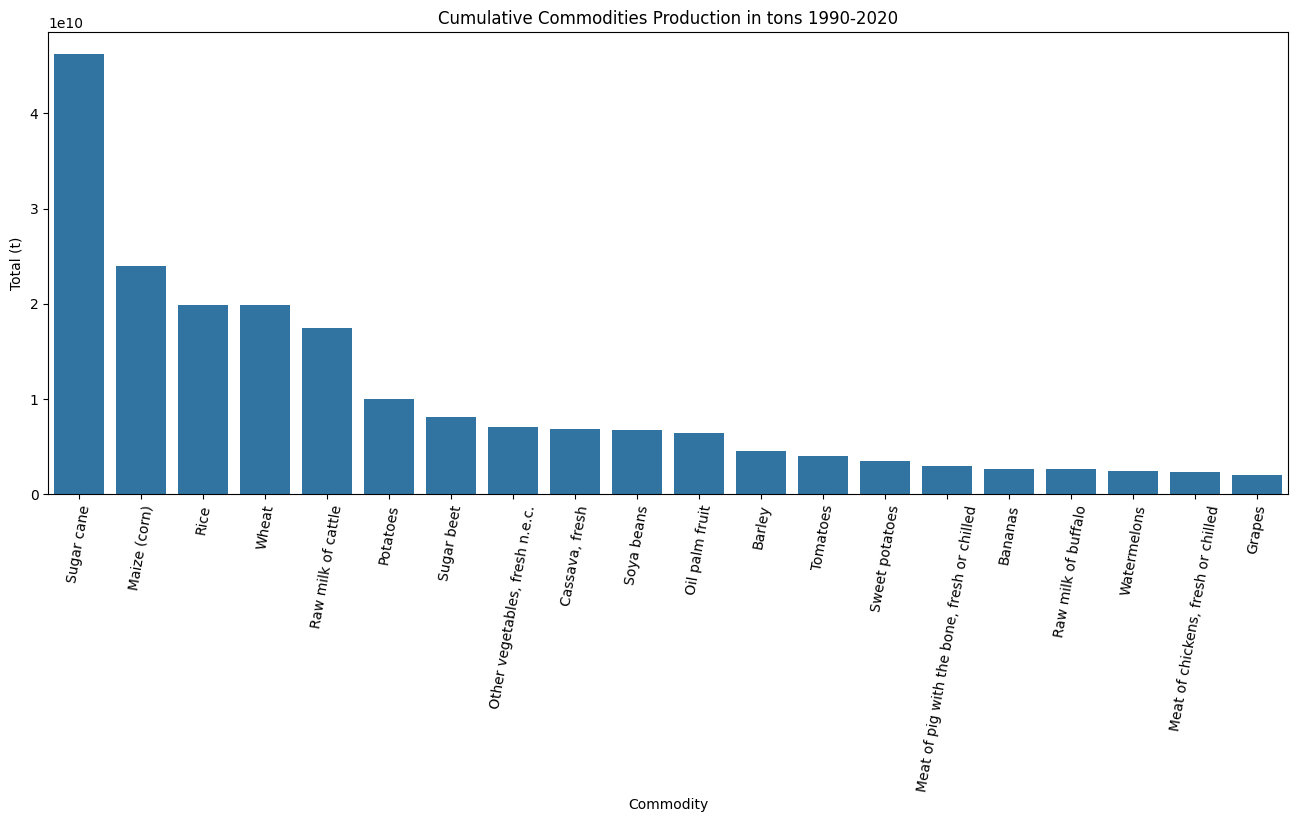

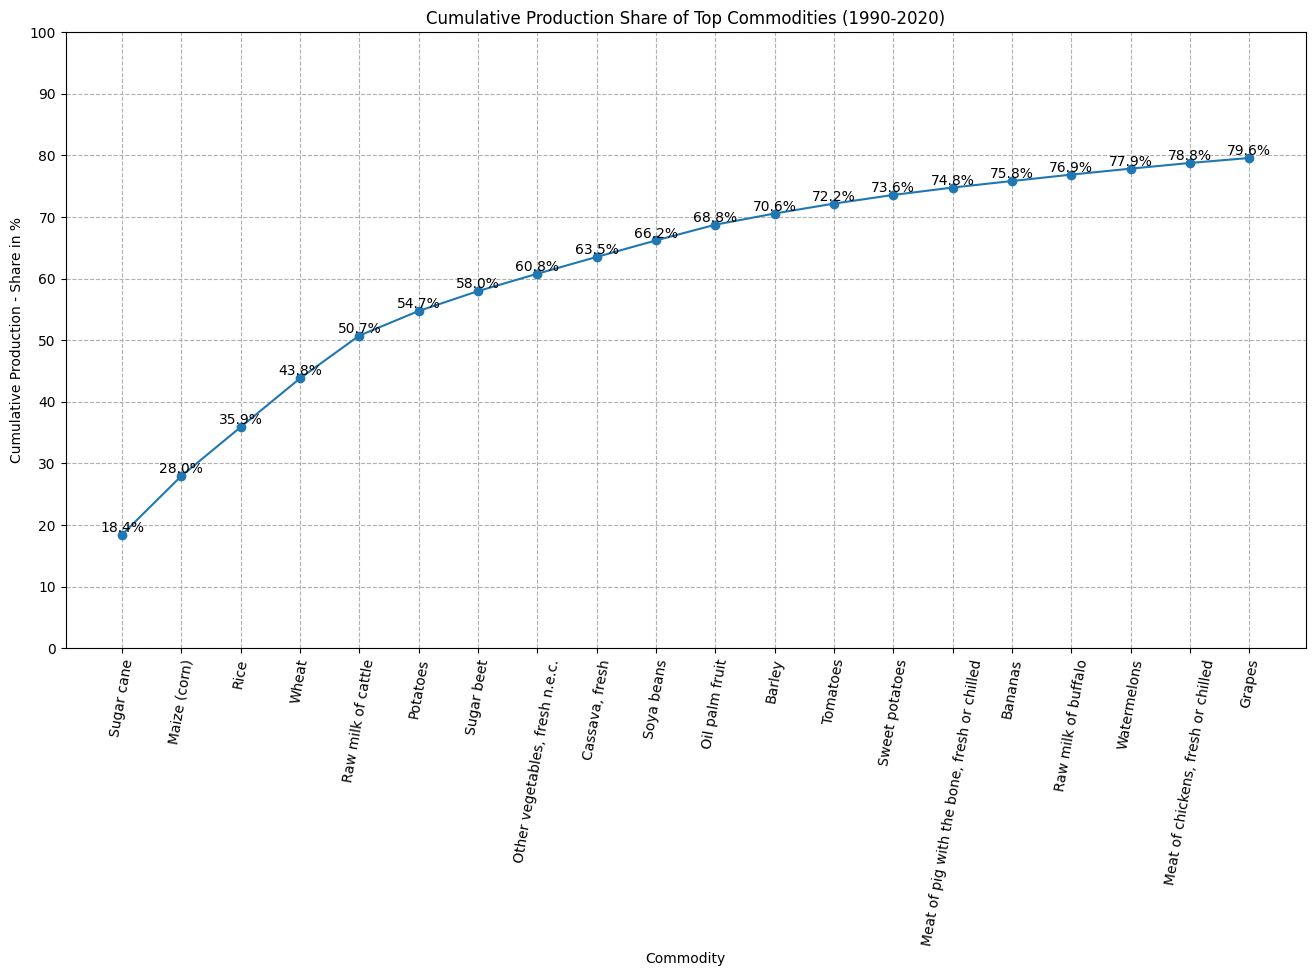

In [2]:
# Load in the dataset from the pickle
global_view_commodities = pd.read_pickle('pkl_jar/quick_pickle.pkl')


# CLEAN DATA
# replace column names with names that make sense:
global_view_commodities.rename(columns={'Unnamed: 0':'global', 'Unnamed: 1':'type','Unnamed: 2':'commodity_names'}, inplace=True)
# filter years
global_view_commodities = global_view_commodities.drop(columns=[col for col in global_view_commodities.columns if '2021' in col or '2022' in col])
# set the index to the commodity names
global_view_commodities.set_index('commodity_names', inplace=True)
# remove the code [00000.00] after commodity name for future searchability
global_view_commodities.index = global_view_commodities.index.str.replace(r'\s*\[.*?\]','', regex=True)



# DETERMINE THE TOP COMMODITIES
# skipping the first three rows (0,1 and 2) and making everything numeric - it makes a lot of NaNs, but I only care about the columns with numbers, so this is fine for now
top_global = global_view_commodities[2:].apply(pd.to_numeric, errors='coerce')
# sum the numeric values for each commodity across the years and save in new column 'Total'
top_global['Total'] = top_global.sum(axis=1)
# look at the top 20 commodities
top_crops = top_global['Total'].nlargest(20)
print(top_crops)



# VISUALIZE THIS DATA
# VISUAL 1 of 2: Cumulative Production in tons 1990-2020
# assign figure size
plt.figure(figsize=(16,6))
# plot
sns.barplot(top_crops)
# rotate labels
plt.xticks(rotation=80)
# labels:
plt.title('Cumulative Commodities Production in tons 1990-2020')
plt.ylabel('Total (t)')
plt.xlabel('Commodity')
plt.show()

# VISUAL 2 of 2: Cumulative Market Share of Top Commodities
#calculate total production of all commodities
total_all_commodities = top_global['Total'].sum()
#cumulative market share percentages
cumulative_totals = top_crops.sort_values(ascending=False).cumsum()
percentages = (cumulative_totals/total_all_commodities)*100
#Plot cumulative market share of top commodities
plt.figure(figsize=(16,8))
plt.plot(range(1, len(percentages)+1), percentages.values, marker='o')
plt.xticks(range(1, len(percentages)+1), percentages.index, rotation=80)
plt.ylim(0,100)
plt.yticks(np.arange(0,101,10))
plt.xlabel('Commodity')
plt.ylabel('Cumulative Production - Share in %')
plt.title('Cumulative Production Share of Top Commodities (1990-2020)')
plt.grid(True, linestyle='--') # dashed lines helped with interpretation/orientation
# add label for percentages at the markers on the graph
for i, (commodity, percentage) in enumerate(percentages.items(), 1):
    plt.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')
plt.tight_layout
plt.show()

• Almost 47 billion tons of sugar cane produced over the 1990-2020 year period.

• The top commodity, sugar cane, takes up an 18.4% market share of all agricultural commodities production for this 30 year time period

• The top 5 agricultural commodities contribute to 50.7% of the entire agricultural commodities market (out of the 211 commodities in the agricultural commodities dataset)

In [3]:
#want to include palm oil (quadrupled production between 1995-2015 according to some sources)
top_11 = list(top_crops.index[:11])
top_11

['Sugar cane',
 'Maize (corn)',
 'Rice',
 'Wheat',
 'Raw milk of cattle',
 'Potatoes',
 'Sugar beet',
 'Other vegetables, fresh n.e.c.',
 'Cassava, fresh',
 'Soya beans',
 'Oil palm fruit']

****
### Part 2: Which countries contribute most to the production of these top crops and animal products?


'bread_and_butter.pkl' contains country-level data about commodities and production

In [4]:
#LOAD DATA
commodities = pd.read_pickle('pkl_jar/bread_and_butter.pkl')
commodities.head()

Area Code Area Code (M49)         Area  Item Code Item Code (CPC)  \
0          2            '004  Afghanistan        221          '01371   
1          2            '004  Afghanistan        221          '01371   
2          2            '004  Afghanistan        221          '01371   
3          2            '004  Afghanistan        711          '01654   
4          2            '004  Afghanistan        711          '01654   

                                                Item  Element Code  \
0                                  Almonds, in shell          5312   
1                                  Almonds, in shell          5419   
2                                  Almonds, in shell          5510   
3  Anise, badian, coriander, cumin, caraway, fenn...          5312   
4  Anise, badian, coriander, cumin, caraway, fenn...          5419   

          Element      Unit  Y1961  ... Y2019N    Y2020  Y2020F Y2020N  \
0  Area harvested        ha    0.0  ...    NaN  22134.0       A    NaN   
1           Yield  100 g/ha    NaN  ...    NaN  17759.0       A    NaN   
2      Production         t    0.0  ...    NaN  39307.0       A    NaN   
3  Area harvested        ha    0.0  ...    NaN  25558.0       E    NaN   
4           Yield  100 g/ha    NaN  ...    NaN   7030.0       E    NaN   

     Y2021  Y2021F Y2021N    Y2022  Y2022F Y2022N  
0  36862.0       A    NaN  37000.0       A    NaN  
1  17432.0       A    NaN  17297.0       A    NaN  
2  64256.0       A    NaN  64000.0       A    NaN  
3  25357.0       E    NaN  25403.0       E    NaN  
4   7050.0       E    NaN   7040.0       E    NaN  

[5 rows x 195 columns]

Regardless of commodity item, which countries contribute most to percent production in market? 

In addition to this question, I want to filter the dataframe to just include the countries that contribute to the production of these top 11 commodities.

In [5]:
# CLEAN & MELT DATA
# year columns without flags(F) and without notes(N)-- just the ones that contain the values
year_columns = commodities.filter(regex=r'^Y\d{4}$').columns

# melt dataframe from wide to long format
df_melted = commodities.melt(id_vars=['Area', 'Item', 'Element'], 
                             value_vars=year_columns, # years columns to rows
                             var_name='Year', 
                             value_name='Value')

# Clean up year columns and names, filter years
# convert the year column to numeric and remove the 'Y' prefix
df_melted['Year'] = pd.to_numeric(df_melted['Year'].str[1:])
# filter to just the 30-yr period of interest: 1990-2020
df_melted = df_melted[(df_melted['Year'] >= 1990) & (df_melted['Year'] <= 2020)]
# 25 Dec 1991 = dissolution of USSR - for the sake of analysis, combine data
df_melted['Area'] = df_melted['Area'].replace({'USSR':'Russian Federation'})


# My data inlcudes regions- 'Africa', 'Americas', 'Developing Countries', etc.
# I want only countries, so I use pycountry to cross-reference the country and filter out regions
valid_countries = set(country.name for country in pycountry.countries)
# mapping for countries with alternative spellings
country_mapping = {
    "Türkiye": "Turkey",
    "United States of America": "United States",
    "Russian Federation": "Russia",
    "Viet Nam": "Vietnam",
    "Korea, Republic of": "South Korea",
    "Iran (Islamic Republic of)": "Iran"
}
# Cross reference country to list, removes non-country regions
def is_valid_country(country):
    # checks that country is in valid_countries
    if country in valid_countries:
        return True
    # if not it checks in mapped_countries for alt spelling
    mapped_country = country_mapping.get(country)
    # returns mapped country name 
    if mapped_country in valid_countries:
        return True
    # if it is not in valid countries or mapped countries, it is not a country
    else:
        return False
# Filter the dataframe
df_filtered_countries = df_melted[df_melted['Area'].apply(is_valid_country)]


# Which countries contribute most to production globally? Calculate top 20 countries
# isolate to just production rows under element
df_production = df_filtered_countries[df_filtered_countries['Element'] == 'Production']
# total up each country's(area's) production value 
country_totals = df_production.groupby('Area')['Value'].sum()
# total up all of each country's(area's) commodities production value
global_total = df_production['Value'].sum()
# calculate the proportion of production each country has out of global production
country_percentages = (country_totals / global_total) * 100
# df for ease
country_percents_df = country_percentages.reset_index()
# rename columns
country_percents_df.columns=['Area', 'Percentage']
# sort the df by percentage from highest to lowest and assign top 20 to the highest 20 percents
top_20 = country_percents_df.sort_values(by='Percentage', ascending=False).head(20)
print(top_20)


# Filter dataframe to ONLY have the countries that contribute to the top commodities
df_filtered = df_filtered_countries[df_filtered_countries['Item'].isin(top_11)]
# pivot the melted dataframe from long to wide
df_pivoted = df_filtered.pivot_table(index=['Area', 'Item', 'Year'], 
                                     columns='Element', # Area Harvested, Production, Yield etc to be new columns
                                     values='Value').reset_index()
# rename columns to inlcude underscores and Area == Country
df_pivoted.rename(columns={'Area harvested': 'Area_harvested', 'Area': 'Country'}, inplace=True)
# drop Milk Animals-- doesn't add anything to my data
df_pivoted = df_pivoted.drop('Milk Animals', axis=1)
# sort the dataframe by year then item and then country
df_commodities = df_pivoted.sort_values(['Year', 'Item', 'Country'])

                         Area  Percentage
33                      China   20.186543
78                      India   11.336297
180  United States of America    9.801266
21                     Brazil    9.609789
139        Russian Federation    3.138414
79                  Indonesia    2.922875
59                     France    2.109770
167                  Thailand    1.913976
110                    Mexico    1.890151
128                  Pakistan    1.846975
65                    Germany    1.819182
123                   Nigeria    1.731283
5                   Argentina    1.664994
176                   Türkiye    1.496363
178                   Ukraine    1.395083
29                     Canada    1.185502
7                   Australia    1.166680
83                      Italy    1.117515
134                    Poland    1.093848
159                     Spain    1.062892


• Over the 30 year period from 1990-2020, China has contributed to just over 20% of the global agricultural commodities production.

I am interested in what the production distributions and trends look like for each of my top 11 commodities. I decided to calculate percentage contribution for each commodity by country and use lineplots to visualize these trends. 

In [6]:
# I first need to calculate a Percentage column
total_production = df_commodities.groupby(['Item', 'Year'])['Production'].sum().reset_index()
total_production.columns = ['Item', 'Year', 'Total_Production']
# Merge total production back to the original dataframe
df_commodities = pd.merge(df_commodities, total_production, on=['Item', 'Year'])

# Calculate percentage contribution for each country
df_commodities['Percentage'] = df_commodities['Production'] / df_commodities['Total_Production'] * 100


In [7]:
df_commodities.Item.unique()

array(['Cassava, fresh', 'Maize (corn)', 'Oil palm fruit',
       'Other vegetables, fresh n.e.c.', 'Potatoes', 'Raw milk of cattle',
       'Rice', 'Soya beans', 'Sugar beet', 'Sugar cane', 'Wheat'],
      dtype=object)

In [8]:
df_aggregated = df_commodities.groupby(['Country', 'Item'], as_index=False).agg({'Production': 'sum'})
df_aggregated.head(20)

Country                            Item    Production
0   Afghanistan                    Maize (corn)  9.710795e+06
1   Afghanistan  Other vegetables, fresh n.e.c.  1.823993e+07
2   Afghanistan                        Potatoes  1.011526e+07
3   Afghanistan              Raw milk of cattle  4.303623e+07
4   Afghanistan                            Rice  1.510460e+07
5   Afghanistan                      Sugar beet  1.667070e+05
6   Afghanistan                      Sugar cane  1.626276e+06
7   Afghanistan                           Wheat  1.035887e+08
8       Albania                    Maize (corn)  8.276480e+06
9       Albania  Other vegetables, fresh n.e.c.  5.735515e+05
10      Albania                        Potatoes  5.467700e+06
11      Albania              Raw milk of cattle  2.612362e+07
12      Albania                            Rice  1.082800e+04
13      Albania                      Soya beans  2.468200e+04
14      Albania                      Sugar beet  1.442116e+06
15      Albania                           Wheat  9.612569e+06
16      Algeria                    Maize (corn)  4.647150e+04
17      Algeria  Other vegetables, fresh n.e.c.  1.555532e+07
18      Algeria                        Potatoes  7.733516e+07
19      Algeria              Raw milk of cattle  5.931165e+07

In [9]:
df_aggregated = df_commodities.groupby(['Country', 'Item'], as_index=False).agg({'Production': 'sum'})
df_aggregated.head(20)
def plot_commodity_choropleth(df):
    # Loop through each unique commodity
    for commodity in df['Item'].unique():
        # Filter the data for the specific commodity
        data = df[df['Item'] == commodity]

        # Create the choropleth map
        fig = px.choropleth(
            data_frame=data,
            locations='Country',  # Column with country names
            locationmode='country names',  # Use country names for mapping
            color='Production',  # Column to determine the color of the map
            hover_name='Country',  # Column to display as hover info
            color_continuous_scale=px.colors.sequential.Plasma,  # Color scale
            title=f'Cumulative Production of {commodity} by Country (1990-2020)'
        )

        # Show the map
        fig.show()

# Run the function with the aggregated data
plot_commodity_choropleth(df_aggregated)

I originally looked at the average contribution percentages for countries for these items, and while it was easier to handle the data (each country had one consistent line rather than broken lines for countries beating each other out certain years), it was not as accurate. I opted for true contribution percentages for each country for each year. This was an accurate representation of which countries led production, however, it increased the number of countries to analyze.

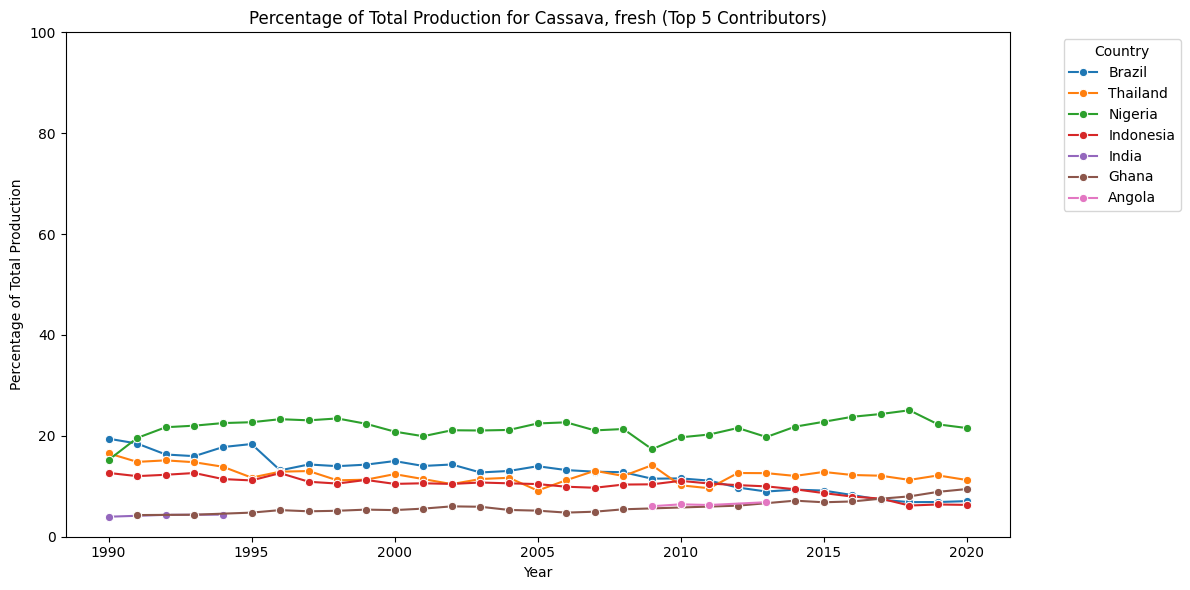

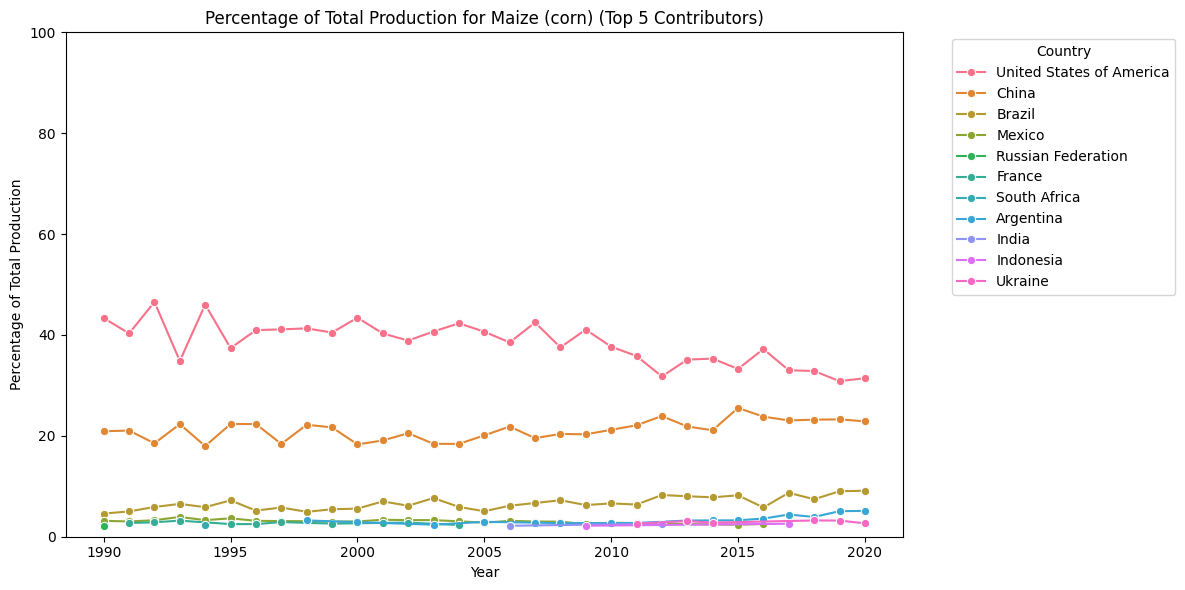

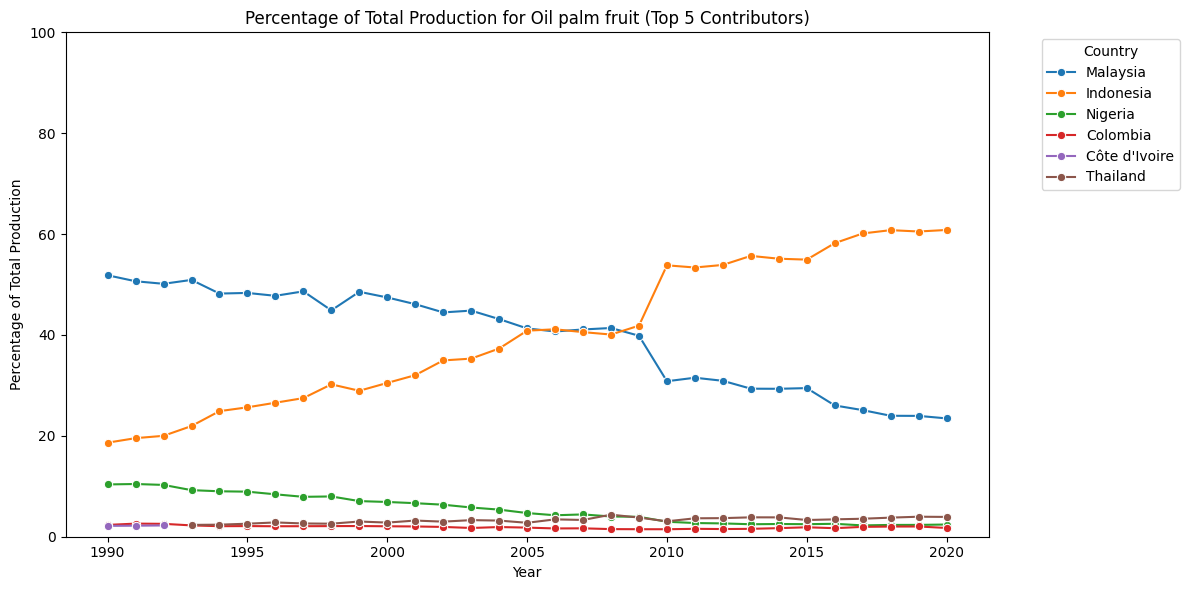

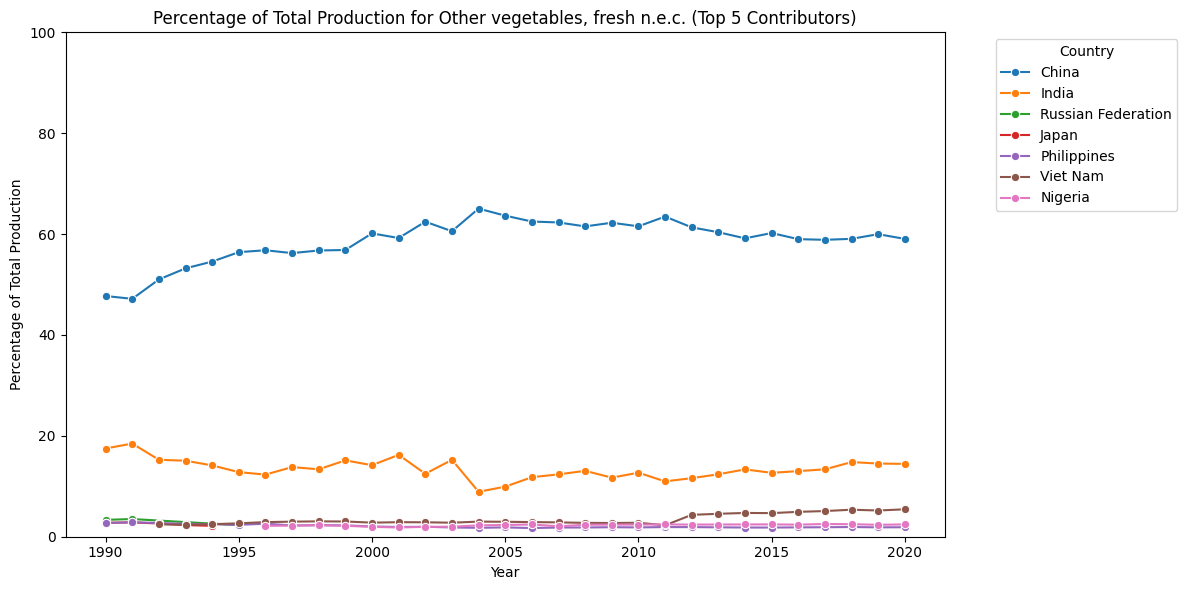

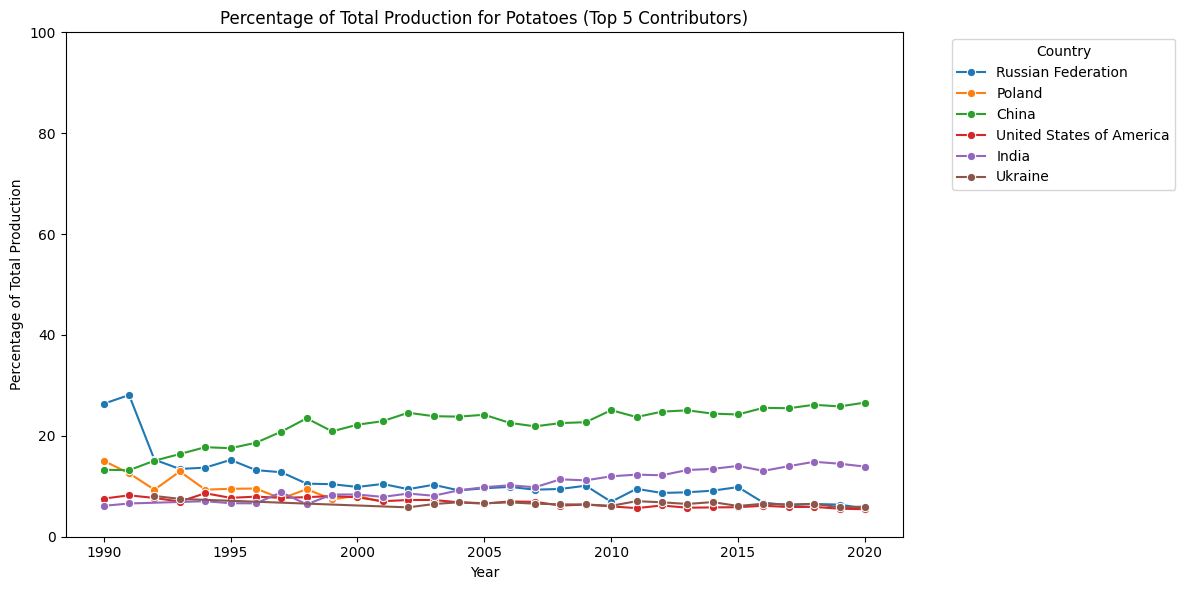

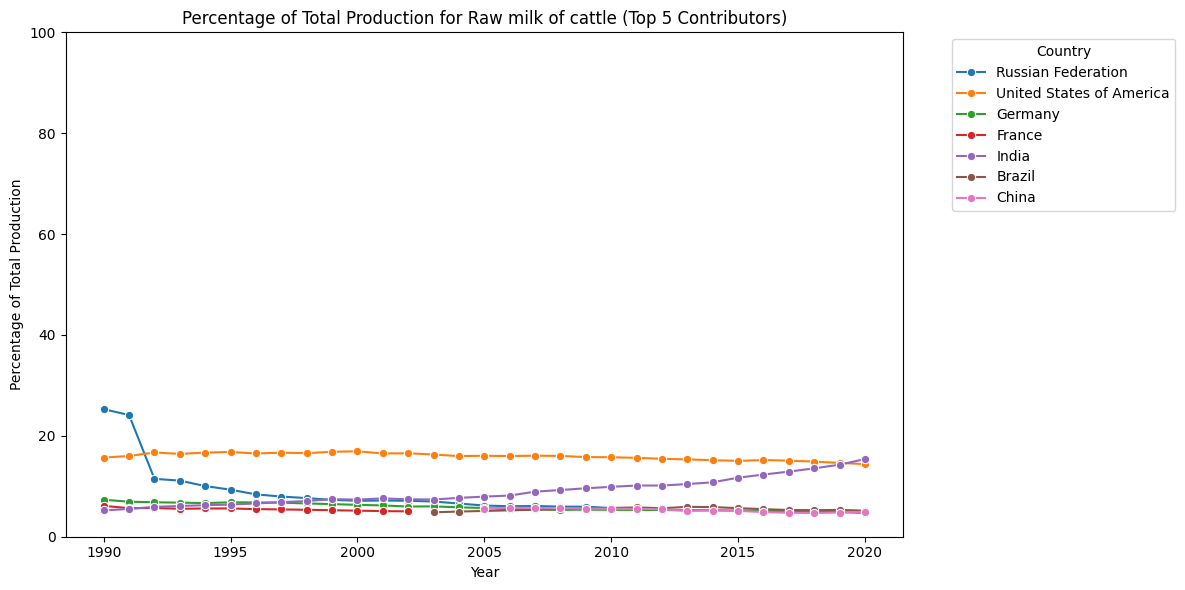

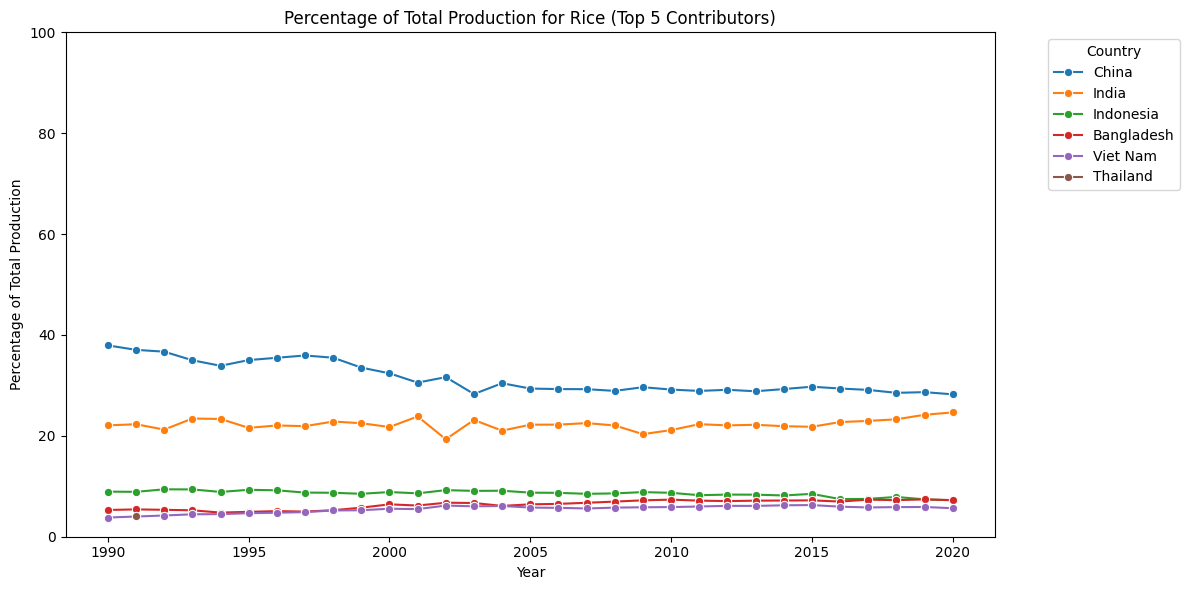

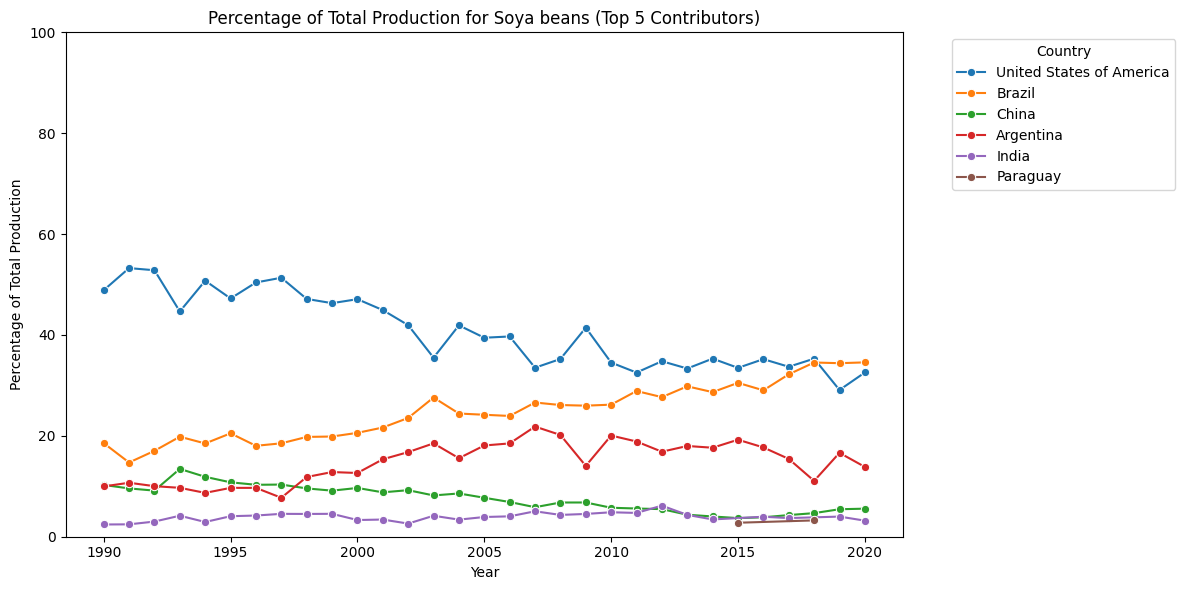

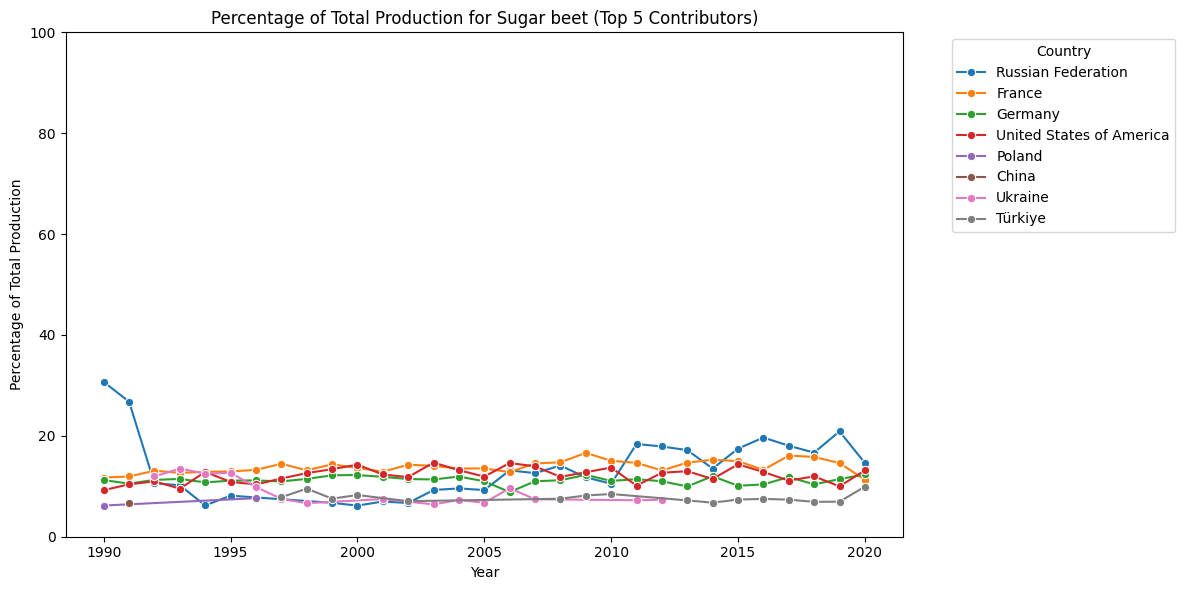

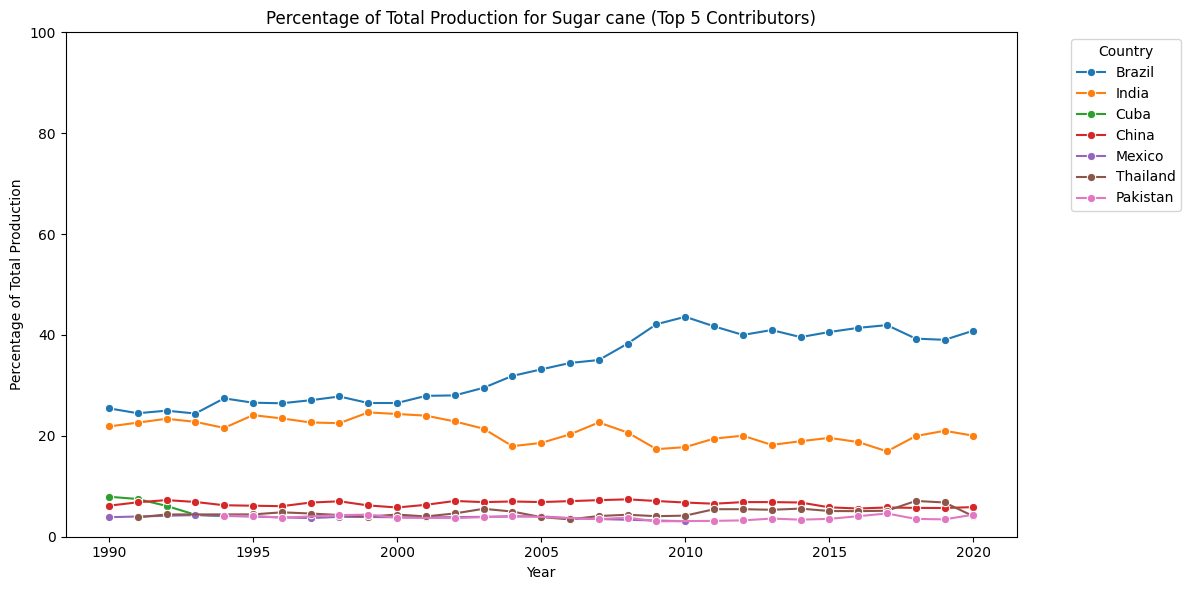

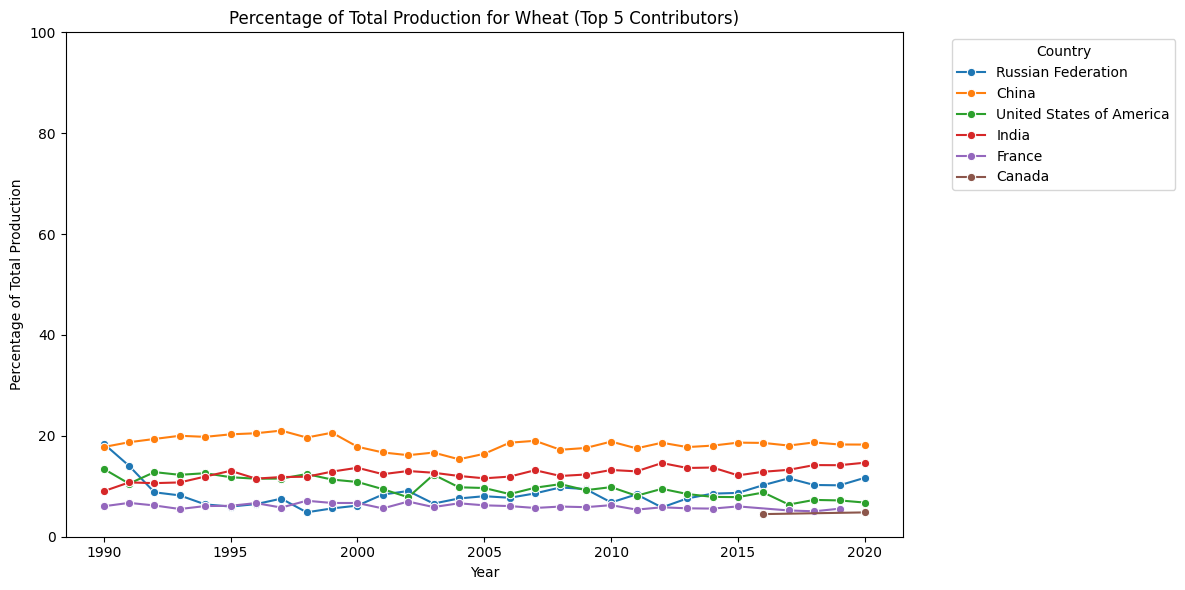

['Angola', 'Argentina', 'Bangladesh', 'Brazil', 'Canada', 'China', 'Colombia', 'Cuba', "Côte d'Ivoire", 'France', 'Germany', 'Ghana', 'India', 'Indonesia', 'Japan', 'Malaysia', 'Mexico', 'Nigeria', 'Pakistan', 'Paraguay', 'Philippines', 'Poland', 'Russian Federation', 'South Africa', 'Thailand', 'Türkiye', 'Ukraine', 'United States of America', 'Viet Nam']


In [10]:
def plot_top_contributors(df_commodities, top_n=5):
    # df to hold the top contributors for each item and year grouped and calculate percentage sums, maintain normal index in df
    top_contributors = (df_commodities.groupby(['Item', 'Year', 'Country'], as_index=False).agg(Percentage=('Percentage', 'sum')))
    # get top N contributors for each item and year, ascending order: Item=True (alphabetical), Year=True(1990-2020), Percentage=False(highest to lowest)
    top_contributors = (top_contributors.sort_values(['Item', 'Year', 'Percentage'], ascending=[True, True, False]).groupby(['Item', 'Year'], as_index=False).head(top_n))
    # pull and store unique countries - used to filter later
    unique_countries = top_contributors['Country'].unique()
    # pull and store unique item-country pairs - also used to filter later!
    unique_item_area_pairs = top_contributors[['Item', 'Country']].drop_duplicates().values.tolist()

    # Plotting
    # I was having a hard time successfully finding a way to go through each of the items with pandas for plotting purposes, so for-loop it is
    for item in top_contributors['Item'].unique():
        item_data = top_contributors[top_contributors['Item'] == item]
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=item_data, x='Year', y='Percentage', hue='Country', marker='o')
        # Set plot title and labels
        plt.title(f'Percentage of Total Production for {item} (Top {top_n} Contributors)')
        plt.xlabel('Year')
        plt.ylabel('Percentage of Total Production')
        plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%
        plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    return sorted(unique_countries), unique_item_area_pairs

# apply this function to the dataframe df_commodities, look for top 5 contributors
unique_countries_list, unique_item_area_pairs = plot_top_contributors(df_commodities, top_n=5)

# Unique sorted list of countries
# print(len(unique_countries_list))
print(unique_countries_list)

In [11]:
print(unique_item_area_pairs)
print(df_commodities.head())
print(df_commodities.shape)

[['Cassava, fresh', 'Brazil'], ['Cassava, fresh', 'Thailand'], ['Cassava, fresh', 'Nigeria'], ['Cassava, fresh', 'Indonesia'], ['Cassava, fresh', 'India'], ['Cassava, fresh', 'Ghana'], ['Cassava, fresh', 'Angola'], ['Maize (corn)', 'United States of America'], ['Maize (corn)', 'China'], ['Maize (corn)', 'Brazil'], ['Maize (corn)', 'Mexico'], ['Maize (corn)', 'Russian Federation'], ['Maize (corn)', 'France'], ['Maize (corn)', 'South Africa'], ['Maize (corn)', 'Argentina'], ['Maize (corn)', 'India'], ['Maize (corn)', 'Indonesia'], ['Maize (corn)', 'Ukraine'], ['Oil palm fruit', 'Malaysia'], ['Oil palm fruit', 'Indonesia'], ['Oil palm fruit', 'Nigeria'], ['Oil palm fruit', 'Colombia'], ['Oil palm fruit', "Côte d'Ivoire"], ['Oil palm fruit', 'Thailand'], ['Other vegetables, fresh n.e.c.', 'China'], ['Other vegetables, fresh n.e.c.', 'India'], ['Other vegetables, fresh n.e.c.', 'Russian Federation'], ['Other vegetables, fresh n.e.c.', 'Japan'], ['Other vegetables, fresh n.e.c.', 'Philippine

In [12]:
# filtering just the top crops and the top countries that produce them
item_country_df = pd.DataFrame(unique_item_area_pairs, columns=['Item', 'Country'])
# use MERGE TO FILTER df_commodities! cool technique https://realpython.com/pandas-merge-join-and-concat/
df_countries = df_commodities.merge(item_country_df, on=['Item', 'Country'], how='inner')
# yield is proportion of area harvested and production in this dataset
df_countries = df_countries.drop(columns = ['Yield'])
df_countries.head()

Country            Item  Year  Area_harvested  Production  \
0     Angola  Cassava, fresh  1990        388571.0   1600000.0   
1     Brazil  Cassava, fresh  1990       1937570.0  24322130.0   
2      Ghana  Cassava, fresh  1990        322800.0   2717000.0   
3      India  Cassava, fresh  1990        241600.0   4962000.0   
4  Indonesia  Cassava, fresh  1990       1311584.0  15829635.0   

   Total_Production  Percentage  
0       125156591.0    1.278399  
1       125156591.0   19.433359  
2       125156591.0    2.170880  
3       125156591.0    3.964633  
4       125156591.0   12.647864

Something very apparent in these graphs is the difference in contribution size. Whereas wheat and sugar beets, for example, all share similar contribution sizes, vegetables, palm fruit oil and corn all have large contributors and small contributors. I was curious if this affected market stability. Below, I categorized contribution size based on the other top contributors of the group and calculated the Herfindahl-Hirschman Index which is an economic factor that helps illustrate market stability.

In [13]:
# Category Buckets:
# categorize these observations
def categorize(df):
    # look at the rows and classify them as S, M, L, or XL.
    def categorize_row(row):
        if row['Percentage'] >= 40:
            return 'XL' #40% or higher
        elif row['Percentage'] >= 21:
            return 'L' # 21% - 39%
        elif row['Percentage'] >= 11:
            return 'M' # 11% - 20%
        elif row['Percentage'] >= 0:
            return 'S' # 0% - 10%
    
    return df.apply(categorize_row, axis=1)

# Apply the categorization function to the DataFrame
df_countries['Contributor Category'] = categorize(df_countries)

Below I wanted to determine some sort of stability index for the commodity based on the idea that if one country is repsonsible for the majority of the market or holds a monopoly, then the market is less stable for that commodity versus the situation where many countries contribute to the production of a product. If a disaster were to decimate the country that contributes 40% of the commodity to the global market, it could contribute to a huge loss in supply and shows that relying too heavily on a single producer is risky. 

The HHI seemed like a good place to start: https://www.investopedia.com/terms/h/hhi.asp#toc-what-the-herfindahl-hirschman-index-hhi-can-tell-you


summary table after merge: 
                               Item  Stability  Stability_1990  Stability_2020
0                   Cassava, fresh   1.000000        1.000000        1.000000
1                     Maize (corn)   0.885106        0.865677        0.912487
2                   Oil palm fruit   0.789766        0.839620        0.710020
3   Other vegetables, fresh n.e.c.   0.746859        0.828606        0.738831
4                         Potatoes   1.000000        1.000000        1.000000
5               Raw milk of cattle   1.000000        1.000000        1.000000
6                             Rice   0.993666        0.977280        1.000000
7                       Soya beans   0.890899        0.848520        0.913400
8                       Sugar beet   1.000000        1.000000        1.000000
9                       Sugar cane   0.967533        1.000000        0.929658
10                           Wheat   1.000000        1.000000        1.000000


/var/folders/ly/bxd94jrj5f1ffy3zk8_yklrh0000gn/T/ipykernel_35872/159491455.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



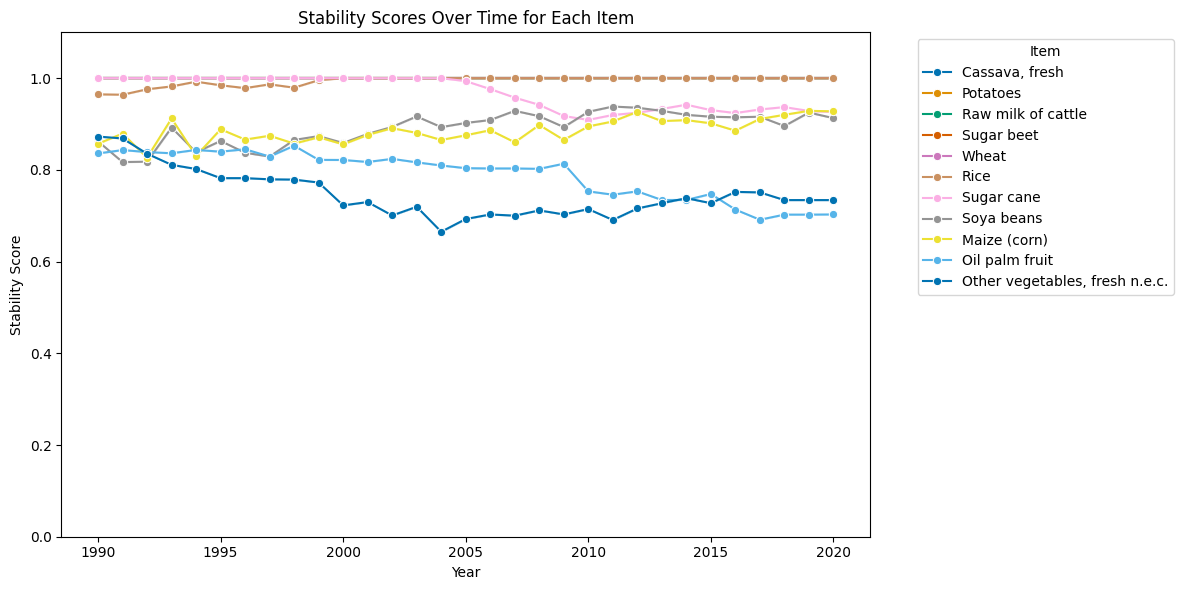

Item  Overall Average Stability (1990-2020)  \
0                   Cassava, fresh                               1.000000   
1                     Maize (corn)                               0.885106   
2                   Oil palm fruit                               0.789766   
3   Other vegetables, fresh n.e.c.                               0.746859   
4                         Potatoes                               1.000000   
5               Raw milk of cattle                               1.000000   
6                             Rice                               0.993666   
7                       Soya beans                               0.890899   
8                       Sugar beet                               1.000000   
9                       Sugar cane                               0.967533   
10                           Wheat                               1.000000   

         Trend  
0       Stable  
1   Increasing  
2   Decreasing  
3   Decreasing  
4       Stable  
5       Stable  
6   Increasing  
7   Increasing  
8       Stable  
9   Decreasing  
10      Stable

In [14]:
# STABILITY INDEX - quanitfy these observations
# Herfindahl-Hirschman Index Calcuation:
def calculate_stability(group):
    # HHI requires integers not floats for percentage:
    group['Percentage'] = pd.to_numeric(group['Percentage'], errors='coerce').fillna(0).astype(int)
    # calculate sum of squares - market share expressed as proportion
    ss = ((group['Percentage'] / 100)**2).sum()
    # number of groups for normalizing later
    n = len(group)
    # just in case we get 0
    if n == 0 or ss == 0:
        return 0
    # normalizes- puts on scale between 0 and 1
    normalized = (ss - 1/n) / (1 - 1/n) if n > 1 else 0
    # invert it so 1 is stable, 0 is unstable
    stability_score = 1 - normalized
    # makes sure it is returning a number between 0 and 1
    return max(0, min(stability_score, 1))
# apply this index to calculate stability scores for each item and the year
stability_scores = df_countries.groupby(['Item', 'Year']).apply(calculate_stability).reset_index()
stability_scores.columns = ['Item', 'Year', 'Stability']
# merge stability scores back to df_countries
df_countries = df_countries.merge(stability_scores, on=['Item', 'Year'], how='left')


# Build a summary table to help understand stability trends
# calculate overall average stability for the period 1990-2020
overall_avg_stability = df_countries.groupby('Item')['Stability'].mean().reset_index()
# Calculate average stability for the two periods to for calculation to determine trend
avg_stability_1990_1995 = df_countries[df_countries['Year'].between(1990, 1995)].groupby('Item')['Stability'].mean().reset_index() # between() - instead of having to slice or make a list and explode (depending on context), .between()!
avg_stability_2015_2020 = df_countries[df_countries['Year'].between(2015, 2020)].groupby('Item')['Stability'].mean().reset_index()
# Merge the averages back into the overall average stability DataFrame
summary_table = overall_avg_stability.merge(avg_stability_1990_1995, on='Item', how='left', suffixes=('', '_1990')) \
                                      .merge(avg_stability_2015_2020, on='Item', how='left', suffixes=('', '_2020'))
print(f'summary table after merge: \n {summary_table}')
# function for new column on trend increasing, decreasing, stable 2020 compared to 1990
def determine_trend(row):
    if row['Stability_1990'] < row['Stability_2020']:
        return 'Increasing'
    elif row['Stability_1990'] > row['Stability_2020']:
        return 'Decreasing'
    else:
        return 'Stable'
summary_table['Trend'] = summary_table.apply(determine_trend, axis=1)

# Select relevant columns for the final summary table
summary_table = summary_table[['Item', 'Stability', 'Trend']]
summary_table.columns = ['Item', 'Overall Average Stability (1990-2020)', 'Trend']



# Stability scores visual
avg_stability = df_countries.groupby('Item')['Stability'].mean().sort_values(ascending=False)
sorted_items = avg_stability.index.tolist()
plt.figure(figsize=(12, 6))
sns.set_palette("colorblind", n_colors=11)
sns.lineplot(data=df_countries, x='Year', y='Stability', hue='Item', marker='o', hue_order=sorted_items)
plt.ylim(0.00, 1.10)
plt.title('Stability Scores Over Time for Each Item')
plt.xlabel('Year')
plt.ylabel('Stability Score')
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

summary_table


Trend is determined by averaging the HHI for 1990-1995 and for 2015-2020 and finding the difference. An increase from 1990-1995 to 2015-2020 marks an increase in stability for the item. A 1 denotes stability. We have 3 Increasing, 3 Decreasing and 5 Stable.

In [15]:
df_countries.head()

Country            Item  Year  Area_harvested  Production  \
0     Angola  Cassava, fresh  1990        388571.0   1600000.0   
1     Brazil  Cassava, fresh  1990       1937570.0  24322130.0   
2      Ghana  Cassava, fresh  1990        322800.0   2717000.0   
3      India  Cassava, fresh  1990        241600.0   4962000.0   
4  Indonesia  Cassava, fresh  1990       1311584.0  15829635.0   

   Total_Production  Percentage Contributor Category  Stability  
0       125156591.0    1.278399                    S        1.0  
1       125156591.0   19.433359                    M        1.0  
2       125156591.0    2.170880                    S        1.0  
3       125156591.0    3.964633                    S        1.0  
4       125156591.0   12.647864                    M        1.0

****
### Part 3: Gather more information on trade - imports and GDP



'GarlicDillPickle.pkl' contains GDP information for each of the countries and years

• Data from World Bank:

• Data collection method: scraping


'trade.pkl' contains country-level data about imports and exports. 

• Data from FAOSTAT:

• Data collection method: downloaded 

• Unfortunately I discovered that this data set didn't have export information for some of the raw products. I considered inlcuding the processed equivalent, but felt that it could skew the data. In the future I would like to research the ratio of produced::exported for products like oil palm fruit and palm oil versus oil of palm kernel and raw cane or beet sugar--determining what the ratios are for each of those raw products that are in the combined export statistic.


GROSS DOMESTIC PRODUCT

In [16]:
# LOAD GDP DATA
gdp_df = pd.read_pickle('pkl_jar/GarlicDillPickle.pkl')
gdp_df.head()

Country Name                  1988                  1989  \
0   United States  5,236,438,000,000.00  5,641,580,000,000.00   
1           Japan  3,071,683,812,149.66  3,054,913,797,217.03   
2         Germany  1,401,233,225,303.49  1,398,967,436,804.33   
3          France  1,018,847,043,277.17  1,025,211,803,413.53   
4  United Kingdom    910,171,030,657.68    926,926,143,222.19   

                   1990                  1991                  1992  \
0  5,963,144,000,000.00  6,158,129,000,000.00  6,520,327,000,000.00   
1  3,132,817,652,848.04  3,584,420,964,070.07  3,908,808,434,705.26   
2  1,771,671,206,875.68  1,868,945,197,407.19  2,131,571,696,931.75   
3  1,269,179,616,913.63  1,269,276,828,275.78  1,401,465,923,172.24   
4  1,093,213,710,428.01  1,142,766,274,398.22  1,179,713,014,951.83   

                   1993                  1994                  1995  \
0  6,858,559,000,000.00  7,287,236,000,000.00  7,639,749,000,000.00   
1  4,454,144,444,407.90  4,998,797,262,443.29  5,545,564,892,181.15   
2  2,071,323,790,370.28  2,205,074,123,177.05  2,585,792,275,146.72   
3  1,322,815,612,694.00  1,393,982,750,472.59  1,601,094,756,209.75   
4  1,061,457,883,633.55  1,140,443,311,074.50  1,346,252,041,210.47   

                   1996  ...                   2013                   2014  \
0  8,073,122,000,000.00  ...  16,843,190,993,000.00  17,550,680,174,000.00   
1  4,923,393,495,138.77  ...   5,212,328,181,166.18   4,896,994,405,353.29   
2  2,497,244,606,186.64  ...   3,733,804,649,549.06   3,889,093,051,023.45   
3  1,605,675,086,549.56  ...   2,811,876,903,329.05   2,855,964,488,590.14   
4  1,421,711,933,486.21  ...   2,786,315,215,249.95   3,065,223,279,583.79   

                    2015                   2016                   2017  \
0  18,206,020,741,000.00  18,695,110,842,000.00  19,477,336,549,000.00   
1   4,444,930,651,964.18   5,003,677,627,544.24   4,930,837,369,151.42   
2   3,357,585,719,351.56   3,469,853,463,945.63   3,690,849,152,517.69   
3   2,439,188,643,162.50   2,472,964,344,587.23   2,595,151,045,197.67   
4   2,934,857,946,213.47   2,699,659,680,997.20   2,683,488,510,504.04   

                    2018                   2019                   2020  \
0  20,533,057,312,000.00  21,380,976,119,000.00  21,060,473,613,000.00   
1   5,040,880,939,324.86   5,117,993,853,016.51   5,048,789,595,589.43   
2   3,974,443,355,019.53   3,888,226,035,921.49   3,889,668,895,299.56   
3   2,790,956,878,746.61   2,728,870,246,705.83   2,639,008,701,648.21   
4   2,878,152,147,315.82   2,857,057,847,953.02   2,704,609,160,088.15   

                    2021 TooltipID  
0  23,315,080,560,000.00     53.00  
1   5,005,536,736,792.29     53.00  
2   4,259,934,911,821.64     53.00  
3   2,957,879,759,263.52     53.00  
4   3,122,480,345,924.54     53.00  

[5 rows x 36 columns]

In [17]:
# CLEAN
gdp_df = gdp_df.drop('TooltipID', axis=1)
# to match naming practices in df_countries 
gdp_df.rename(columns={'Country Name': 'Country'}, inplace=True)
# adjust names because there are different spellings used:
country_names = {
    'Turkey': 'Türkiye',
    "Cote d'Ivoire":"Côte d'Ivoire",
    'Vietnam': 'Viet Nam',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Korea, Rep.': 'Republic of Korea',
    'United States': 'United States of America'
}
# replace the country names with correct spellings
gdp_df['Country'] = gdp_df['Country'].replace(country_names)
# melt df to have a year column
gdp_df = gdp_df.melt(id_vars=['Country'], var_name='Year', value_name='GDP')
# remove the commas from the gdp numbers and convert to numeric
gdp_df['GDP'] = pd.to_numeric(gdp_df['GDP'].str.replace(',', '', regex=False), errors='coerce')
gdp_df['Year'] = gdp_df['Year'].astype(int)
# limit to just the countries that contribute the most to the top crops
gdp_df = gdp_df[gdp_df['Country'].isin(unique_countries_list)]
# limit to 1990--2020
gdp_df = gdp_df[(gdp_df['Year']>=1990)&(gdp_df['Year']<=2020)]
gdp_df.head()

Country  Year           GDP
386  United States of America  1990  5.963144e+12
387                     Japan  1990  3.132818e+12
388                   Germany  1990  1.771671e+12
389                    France  1990  1.269180e+12
392        Russian Federation  1990  5.168143e+11

IMPORTS

I have a suspicion that during more severe natural disasters, imports may increase to help support the population while the nation is recovering and rebuilding.

In [18]:
# TRADE INDICES - IMPORTS

# LOAD DATA FOR TRADE INDICES:
imports_df = pd.read_pickle('pkl_jar/trade.pkl')
imports_df.head()

Area Code Area Code (M49)         Area  Item Code Item Code (CPC)    Item  \
0          2            '004  Afghanistan        515          '01341  Apples   
1          2            '004  Afghanistan        515          '01341  Apples   
2          2            '004  Afghanistan        515          '01341  Apples   
3          2            '004  Afghanistan        515          '01341  Apples   
4          2            '004  Afghanistan        515          '01341  Apples   

   Element Code                               Element      Unit  Y1961  ...  \
0            64     Import Value Base Period Quantity  1000 USD    NaN  ...   
1            65        Import Value Base Period Price  1000 USD    NaN  ...   
2            94            Export Value Base Quantity  1000 USD    NaN  ...   
3            95               Export Value Base Price  1000 USD    NaN  ...   
4           462  Import Value Index (2014-2016 = 100)       NaN    NaN  ...   

     Y2018  Y2018F    Y2019  Y2019F    Y2020  Y2020F    Y2021  Y2021F  \
0  11877.0       E  12248.0       E  82229.0       E  74546.0       E   
1   2989.0       E   1444.0       E    840.0       E    426.0       E   
2  20104.0       E  16024.0       E  23507.0       E  22940.0       E   
3   8415.0       E  10221.0       E  27265.0       E  22680.0       E   
4      5.0       E      3.0       E     10.0       E      5.0       E   

     Y2022  Y2022F  
0  32718.0       E  
1    100.0       E  
2  15105.0       E  
3  12970.0       E  
4      0.0       E  

[5 rows x 133 columns]

In [19]:
# CLEAN
# drop the year flag columns and rename the years and filter to 1990-2022:
year_columns = imports_df.filter(regex=r'^Y\d{4}$').columns
# select the columns to be included and inlcude the years
imports_df = imports_df[['Area', 'Item', 'Element'] + year_columns.tolist()]
# remove the Y prefix from Y1990 --> 1990
imports_df.columns = imports_df.columns.str.replace('Y', '')
# rename area --> country for unifromity with other dataframes
imports_df.rename(columns={'Area':'Country'}, inplace=True)

# filtering countries sooner rather than later makes this much faster (15 seconds versus 2)
# filter to only the unique countries
imports_df = imports_df[imports_df['Country'].isin(unique_countries_list)]
# melt so that year has its own column 
imports_df = imports_df.melt(id_vars = ['Country', 'Item', 'Element'],var_name='Year',value_name='Value')
imports_df['Year'] = imports_df['Year'].astype(int)
# trade_df=trade_df[(trade_df['Year'] >= 1990) & (trade_df['Year']<=2022)]
imports_df = imports_df[(imports_df['Year'] >= 1990) & (imports_df['Year'] <= 2020)]
# unit is in 1000USD so I am going to multiply the values for accuracy:
imports_df['Value'] *= 1000
# replace USSR with Russian Federation
imports_df['Country'] = imports_df['Country'].replace({'USSR':'Russian Federation'})
# pivot so the columns in Element become their own columns: Total Import Value and Total Import Quantity
imports_df = imports_df.pivot_table(index=['Country', 'Item', 'Year'],columns ='Element',values = 'Value').reset_index()
# drop unnecessary columns
cols_to_drop = imports_df.filter(like='Index').columns
# exports was disappointing - the commodities for production were different than export even though they came from same data source
cols_to_drop = cols_to_drop.append(imports_df.filter(like='Export').columns)
imports_df = imports_df.drop(columns =cols_to_drop)


# imports_df.head(50)
imports_df = imports_df.groupby(['Country', 'Year']).agg(Total_Import_Value=('Import Value Base Period Price', 'sum'), Total_Import_Quantity = ('Import Value Base Period Quantity', 'sum')).reset_index()
imports_df.head()


Country  Year  Total_Import_Value  Total_Import_Quantity
0  Angola  1990        3.734841e+09           1.148759e+10
1  Angola  1991        3.022205e+09           1.220963e+10
2  Angola  1992        3.414009e+09           1.366026e+10
3  Angola  1993        2.667819e+09           1.157886e+10
4  Angola  1994        2.943748e+09           1.135122e+10

I wanted to include exports but ran into some issues with commodities items. Whereas I have Sugar Cane and Sugar Beets for production, I have a combined Raw sugar(sugarcane and sugarbeets) for exports. For oil palm fruit in porduction, there is palm oil for exports. I would guess that a country that produces a lot of a product may process some of it too. Without detailed reports of the ratios of different sugars or what percentage of palm fruit goes into palm oil processing, it was hard to use the export information. 

****
### Part 4: Natural Disasters



'nat_dillsaster.pkl' contains data on natural disasters

• Data from EM-DAT:

• Data collection method: download


In [20]:
# LOAD DATA FOR NATURAL DISASTERS
natural_disasters = pd.read_pickle('pkl_jar/nat_dillsaster.pkl')
natural_disasters.head()

DisNo. Historic Classification Key Disaster Group Disaster Subgroup  \
0  1990-0001-LKA      Yes    nat-hyd-flo-riv        Natural      Hydrological   
1  1990-0002-TUN      Yes    nat-hyd-flo-riv        Natural      Hydrological   
2  1990-0003-WSM      Yes    nat-met-sto-tro        Natural    Meteorological   
3  1990-0004-FRA      Yes    nat-hyd-mmw-ava        Natural      Hydrological   
4  1990-0005-IDN      Yes    nat-hyd-flo-riv        Natural      Hydrological   

         Disaster Type  Disaster Subtype External IDs Event Name  ISO  ...  \
0                Flood    Riverine flood          NaN        NaN  LKA  ...   
1                Flood    Riverine flood          NaN        NaN  TUN  ...   
2                Storm  Tropical cyclone          NaN        Ofa  WSM  ...   
3  Mass movement (wet)   Avalanche (wet)          NaN        NaN  FRA  ...   
4                Flood    Riverine flood          NaN        NaN  IDN  ...   

  Reconstruction Costs ('000 US$) Reconstruction Costs, Adjusted ('000 US$)  \
0                             NaN                                       NaN   
1                             NaN                                       NaN   
2                             NaN                                       NaN   
3                             NaN                                       NaN   
4                             NaN                                       NaN   

  Insured Damage ('000 US$) Insured Damage, Adjusted ('000 US$)  \
0                       NaN                                 NaN   
1                       NaN                                 NaN   
2                       NaN                                 NaN   
3                       NaN                                 NaN   
4                       NaN                                 NaN   

  Total Damage ('000 US$) Total Damage, Adjusted ('000 US$)        CPI  \
0                     NaN                               NaN  42.880732   
1                242800.0                          566222.0  42.880732   
2                200000.0                          466410.0  42.880732   
3                     NaN                               NaN  42.880732   
4                  4800.0                           11194.0  42.880732   

  Admin Units  Entry Date  Last Update  
0         NaN  2005-12-20   2023-09-25  
1         NaN  2006-07-19   2023-09-25  
2         NaN  2005-12-20   2023-09-25  
3         NaN  2005-12-21   2023-09-25  
4         NaN  2006-07-19   2023-09-25  

[5 rows x 46 columns]

In [21]:
print(natural_disasters.shape)
natural_disasters.isna().sum()

(11586, 46)


DisNo.                                           0
Historic                                         0
Classification Key                               0
Disaster Group                                   0
Disaster Subgroup                                0
Disaster Type                                    0
Disaster Subtype                                 0
External IDs                                  9496
Event Name                                    8621
ISO                                              0
Country                                          0
Subregion                                        0
Region                                           0
Location                                       737
Origin                                        7985
Associated Types                              8608
OFDA/BHA Response                                0
Appeal                                           0
Declaration                                      0
AID Contribution ('000 US$)    

In [22]:
# CLEANING
# the apostrophe between d and Ivoire is not a recognized character
natural_disasters['Country'] = natural_disasters['Country'].replace({"Côte d’Ivoire":"Côte d'Ivoire"})
#filtering to just the countries in that top list:
natural_disasters = natural_disasters[natural_disasters['Country'].isin(unique_countries_list)]
# after looking at isna().sum() and column meanings, i filtered to these
columns_to_keep = [
    'Disaster Group',
    'Disaster Subgroup',
    'Disaster Type',
    'Disaster Subtype',
    'Country',
    'Start Year',
    'End Year',
    'OFDA/BHA Response',
    'Total Affected' # this has a lot of NaNs, but i wanted to keep it for a side-analysis seen below
]
# filter to the selected columns
natural_disasters = natural_disasters[columns_to_keep]

In [23]:
natural_disasters.head()

Disaster Group Disaster Subgroup        Disaster Type Disaster Subtype  \
3         Natural      Hydrological  Mass movement (wet)  Avalanche (wet)   
4         Natural      Hydrological                Flood   Riverine flood   
8         Natural       Geophysical           Earthquake  Ground movement   
10        Natural      Hydrological                Flood   Riverine flood   
11        Natural       Geophysical    Volcanic activity         Ash fall   

        Country  Start Year  End Year OFDA/BHA Response  Total Affected  
3        France        1990      1990                No             NaN  
4     Indonesia        1990      1990               Yes         21000.0  
8   Philippines        1990      1990                No         34504.0  
10     Paraguay        1990      1990               Yes         15000.0  
11    Indonesia        1990      1990               Yes         10265.0

For some preliminary exploratory data analysis, I wanted to know what the most common disasters were and also what the spread of disasters by country looked like:

Disaster Type
Flood                  1999
Storm                  1824
Earthquake              434
Epidemic                317
Mass movement (wet)     309
Extreme temperature     250
Wildfire                190
Drought                 140
Volcanic activity        75
Mass movement (dry)      12
Infestation               9
Impact                    1
Name: count, dtype: int64


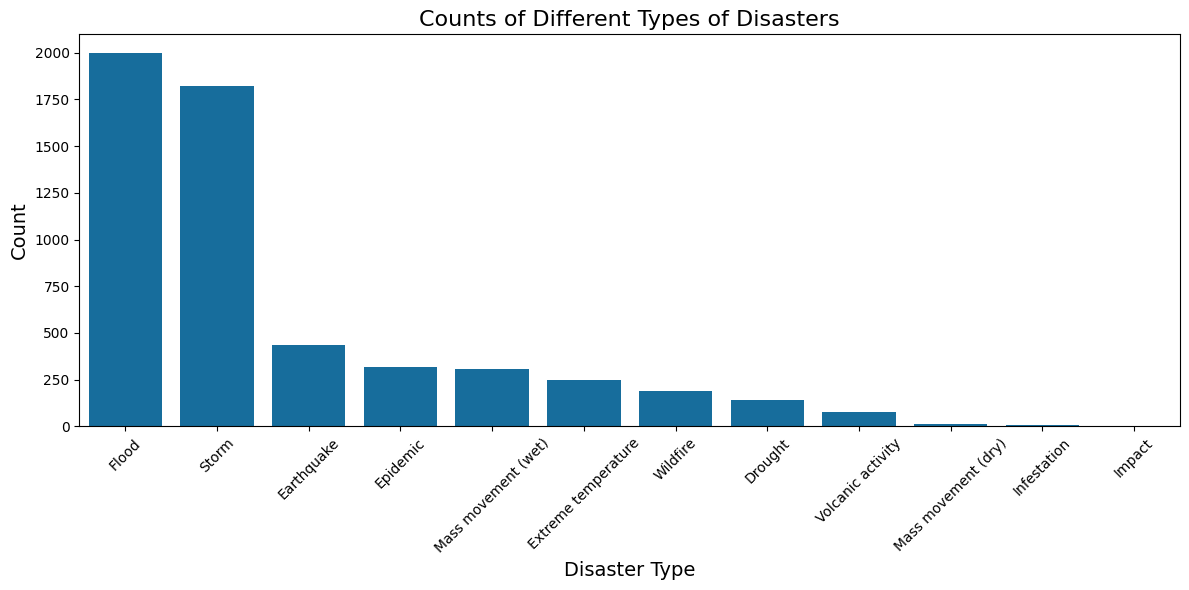

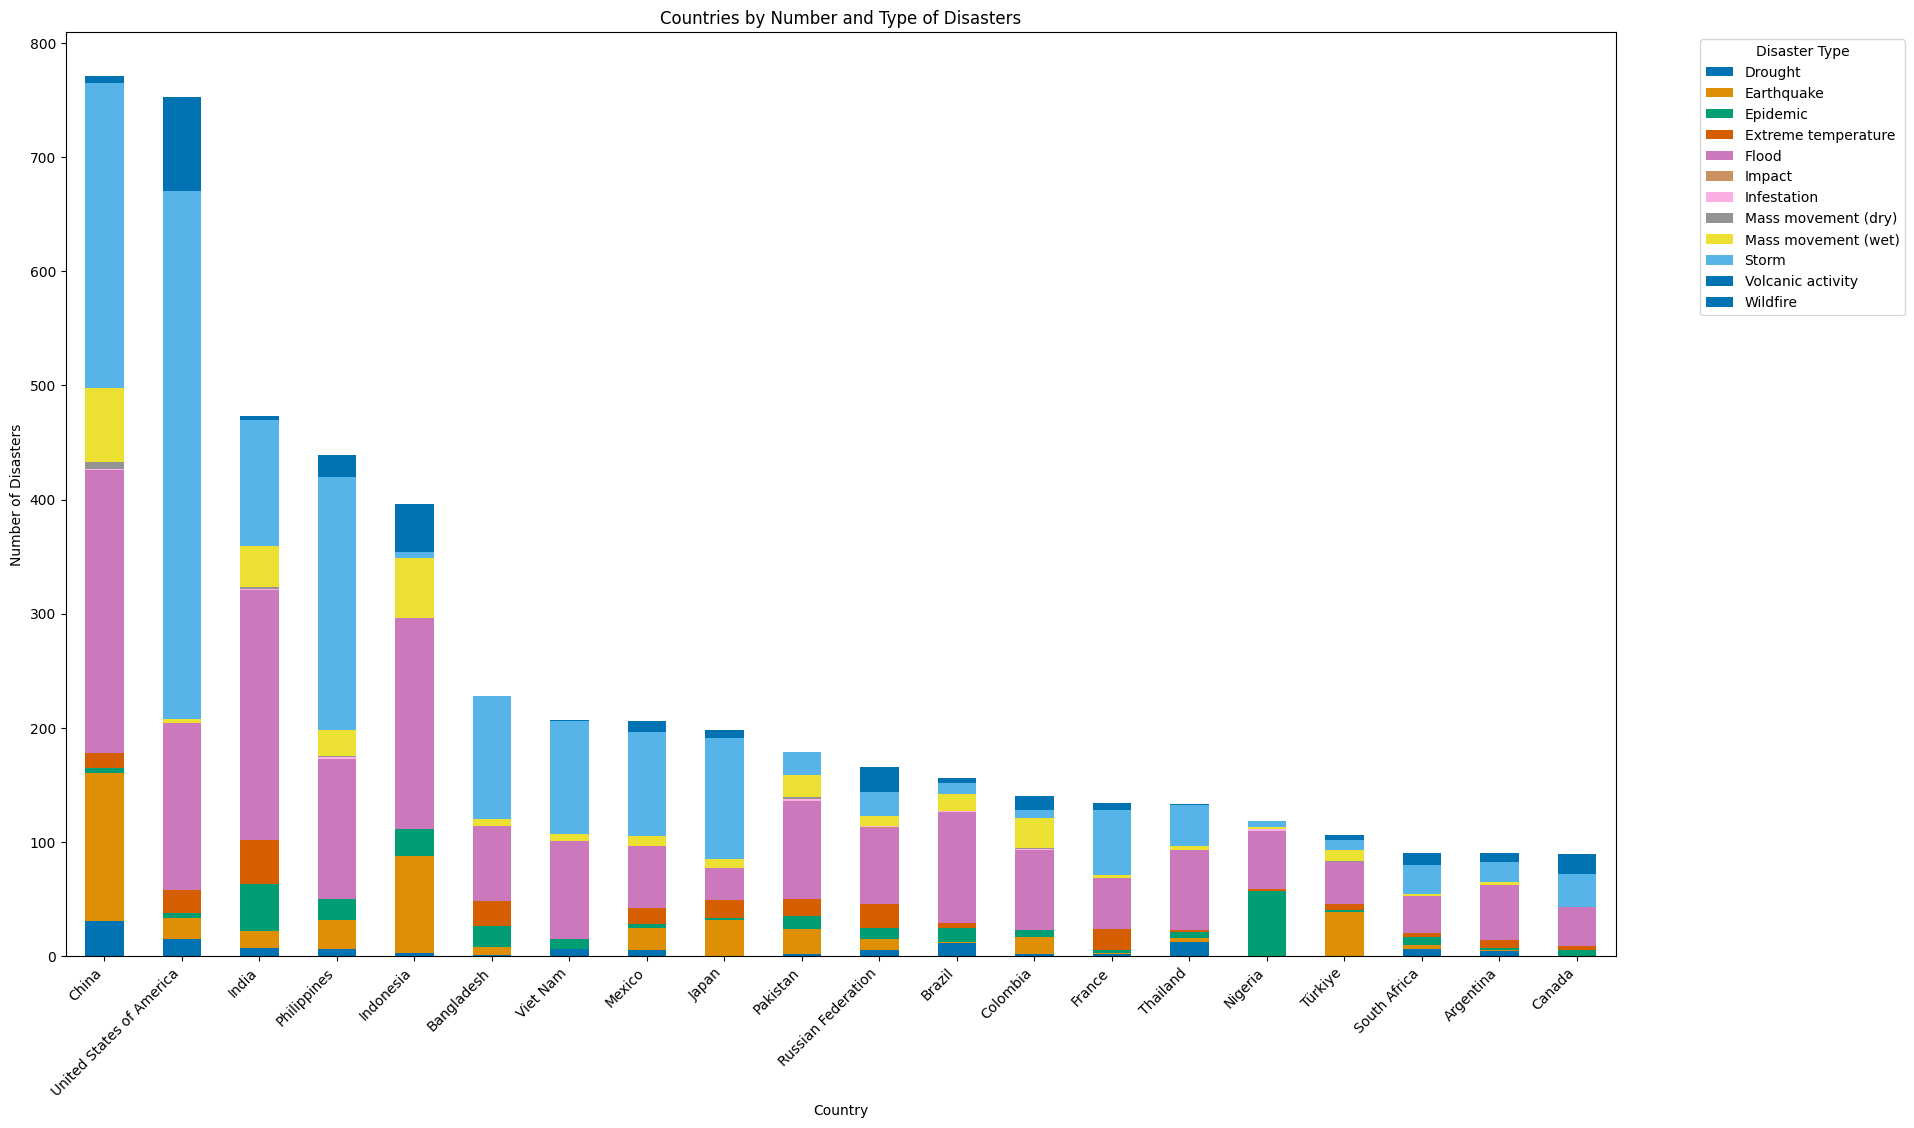

In [24]:
# PLOT 1 - basic idea of distribution of different natural disasters in data set
# tally up the counts for different types of disasters
disaster_counts = natural_disasters['Disaster Type'].value_counts()
print(disaster_counts)
# Count occurrences of each disaster type
disaster_counts = natural_disasters['Disaster Type'].value_counts()  # Replace 'Disaster Type' with the actual column name
# bar plot
plt.figure(figsize=(12, 6))  # Set the figure size
sns.barplot(x=disaster_counts.index, y=disaster_counts.values)
# titles and labels
plt.title('Counts of Different Types of Disasters', fontsize=16)
plt.xlabel('Disaster Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)  # Rotate x labels for better visibility
# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


# PLOT 2 - distribution of disasters by country (all)
# count the occurrence of a country in the dataframe
country_disaster_counts = natural_disasters['Country'].value_counts()
# get a look at the top 20 countries (i have 29, but 20 is ok to just get an idea)
top_countries = country_disaster_counts.nlargest(min(20, len(country_disaster_counts))).index
# Create a pivot table
disaster_pivot = pd.pivot_table(natural_disasters, 
                                values='Start Year',  # using 'Start Year' for counting disaster occurrences
                                index='Country', # each row corresponds to a country
                                columns='Disaster Type', # each column corresponds to a disaster type
                                aggfunc='count', # counting occurrences 
                                fill_value=0) # 0 instead of NaN
# sort the pivot table by total disasters and select top countries
disaster_pivot = disaster_pivot.loc[top_countries]
# plot
fig, ax = plt.subplots(figsize=(20, 12))
# stacked bar chart
disaster_pivot.plot(kind='bar', stacked=True, ax=ax)
plt.title('Countries by Number and Type of Disasters')
plt.xlabel('Country')
plt.ylabel('Number of Disasters')
plt.legend(title='Disaster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# rotate x labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()

I was curious about timelines for countries and items, but felt that a line plot for all the different types of disasters may not be good to look at or interpret. Below, I experimetned with plotly for plotting disasters over time, first by country and then by commodity.

In [25]:
# PLOTLY 1 bubble chart : Disasters by time and country

# similar approach as above - count the occurrences by country:
# group by Country, Disaster Type, Start Year, and End Year
disaster_counts = natural_disasters.groupby(['Country', 'Disaster Type', 'Start Year', 'End Year']).size().reset_index(name='Count')

# create the initial bubble chart
fig = px.scatter(disaster_counts, 
                 x='Start Year', 
                 y='Country', 
                 size='Count', 
                 color='Disaster Type',
                 hover_name='Country',
                 hover_data=['Disaster Type', 'Count'],
                 title='Disasters by Country, Type, and Year',
                 labels={'Count': 'Number of Disasters'},
                 height=800,
                 width=1200,)
                #  color_discrete_sequence=px.colors.qualitative.Set1) # mixed success with color palettes

# I wanted to capture the duration of disasters since they vary so i used a scatterplot to make lines
# add lines to represent the duration of each disaster
for index, row in disaster_counts.iterrows():
    fig.add_trace(go.Scatter(
        x=[row['Start Year'], row['End Year']], # draw a line for the duration of disaster
        y=[row['Country'], row['Country']], # by country
        mode='lines',
        line=dict(color='blue', width=2),
        showlegend=False # no legend
    ))

# labels and layout
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Country',
    legend_title='Disaster Type',
    font=dict(size=10),
    xaxis=dict(tickangle=45)
)

fig.show()

In [26]:
# PLOTLY 2 bubble chart : plot disaster type by year and commodity

# merge the natural_disasters df with df_countries to inlcude commodities data
merged_data = natural_disasters.merge(df_countries[['Country', 'Item']], on='Country', how='left')
# get counts with size() and group by Item, Disaster Type, Start Year, and End Year
disaster_counts = merged_data.groupby(['Item', 'Disaster Type', 'Start Year', 'End Year']).size().reset_index(name='Count')

# create the bubble chart
fig = px.scatter(disaster_counts, 
                 x='Start Year', 
                 y='Item', # i want commodities (Items) on the y axis instead of countries like above
                 size='Count', 
                 color='Disaster Type',
                 hover_name='Item',
                 hover_data=['Disaster Type', 'Count'],
                 title='Disasters by Item, Type, and Year',
                 labels={'Count': 'Number of Disasters'},
                 height=800,
                 width=1200,)
                #  color_discrete_sequence=px.colors.qualitative.Set1)

# same strategy as above, using scatterplot to plot lines to represent the length of each disaster. bubble plots are basically a type of fancy scatterplot...
for index, row in disaster_counts.iterrows():
    fig.add_trace(go.Scatter(
        x=[row['Start Year'], row['End Year']],
        y=[row['Item'], row['Item']],
        mode='lines',
        line=dict(color='blue', width=2),
        showlegend=False #no legend
    ))

# labeling and layout
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Item', # by commodity
    legend_title='Disaster Type',
    font=dict(size=10),
    xaxis=dict(tickangle=45)
)
fig.show()

2006 was a big year for floods

After looking at columns and NaNs, I realized I didn't really have an option for determining the intensity of the disaster as it relates to production: a lot of the Total Affected, Total Deaths, Location, Latitude, Longitude (if I could cross-reference this with locations for where commodities are produced within a country) data were majority NA. I was curious if the OFDA/BHA Response could serve as a proxy for this. If a disaster is really bad, it gets a response.

*(OFDA - Office of U.S. Foreign Disaster Assistance, BHA - Bureau for Humanitarian Assistance)

To test this idea, I isolated the data down to just the rows that contain information about the Total Affected and looked at the OFDA/BHA Response to see if a response ocurred when more people were affected. I needed to employ bootstrapping because of the size difference in the two groups. I then tested the statistical significance of this.

Maximum affected: 330000000.0
Minimum affected: 1.0


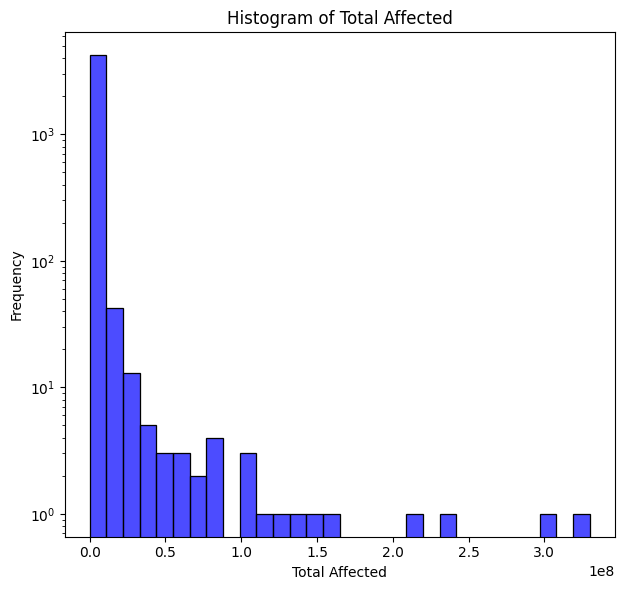

In [27]:
# to begin this exploratory data analysis, I dropped the rows that didn't have data for Total Affected
total_affected_clean = natural_disasters['Total Affected'].dropna()
# to gain more understanding of total number of people affected by disasters in this df
max_val = total_affected_clean.max()
min_val = total_affected_clean.min()
print(f'Maximum affected: {max_val}')
print(f'Minimum affected: {min_val}')

# PLOT: distribution of people affected
plt.figure(figsize=(12, 6))
# Histogram
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(total_affected_clean, bins=30, kde=False, color='blue', alpha=0.7)
plt.title('Histogram of Total Affected')
plt.xlabel('Total Affected')
plt.ylabel('Frequency')
plt.yscale('log') # i put it on log scale for visual purposes- we have a disaster that affected 300,000,000 people, and some that affected 1.
plt.tight_layout()
plt.show()

The minimum number of people affected in this subset of the data is 1 person, the maximum number of people affected is 330,000,000 (a drought in India).

I then set out to determine if OFDA/BHA Response disasters could be a proxy for determining intensity of a disaster based on how many people were impacted. To do this I ran a bootstrap of the data and looked at the confidence intervals and mean difference.

In [28]:
# for this analysis I dropped NaN rows - I want to explore the OFDA/BHA response in relation to total affected
intensity_subset = natural_disasters[natural_disasters['Total Affected'].notna()]

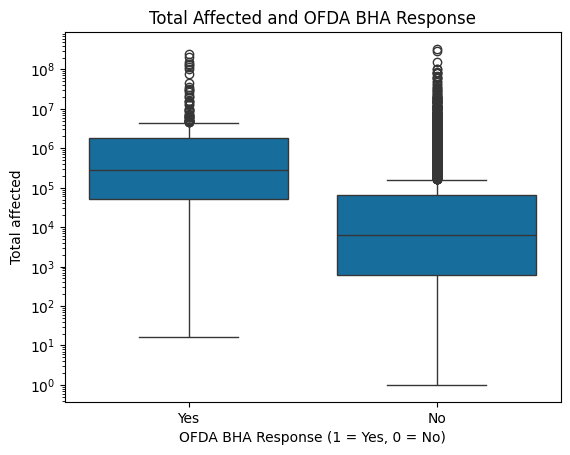

In [29]:
# to see what I am analyzing right now
sns.boxplot(x='OFDA/BHA Response', y='Total Affected', data=intensity_subset)
plt.title('Total Affected and OFDA BHA Response')
plt.xlabel('OFDA BHA Response (1 = Yes, 0 = No)')
plt.ylabel('Total affected')
plt.yscale('log')  # Log scale for better visibility
plt.show()

In [30]:
# then, separate the data into two groups based on OFDA/BHA Response
group_yes = intensity_subset[intensity_subset['OFDA/BHA Response'] == 'Yes']['Total Affected']
group_no = intensity_subset[intensity_subset['OFDA/BHA Response'] == 'No']['Total Affected']
# check the size of each group
print(f'Group Yes Size: {len(group_yes)}')
print(f'Group No Size: {len(group_no)}')
# they are quite different in size, so let's bootstrap this


# Function to perform bootstrapping adapted from: https://www.digitalocean.com/community/tutorials/bootstrap-sampling-in-python, and various stackoverflows and google searches
def bootstrap(data, num_samples=1000):
    bootstrapped_means = []
    # runs 1000 times
    for _ in range(num_samples): 
        #random sampling from dataset with replacement, size of sample should be equal to size of dataset
        sample = np.random.choice(data, size=len(data), replace=True)
        # calculates mean of sample and appends to bootstrapped_means
        bootstrapped_means.append(np.mean(sample))  # can change this to np.median for median
    return np.array(bootstrapped_means)

# can also use scipy
# bootstrapping for both groups
bootstrapped_means_yes = bootstrap(group_yes)
bootstrapped_means_no = bootstrap(group_no)

# calculate confidence intervals 2.5, 97.5 = 95% ci
ci_yes = np.percentile(bootstrapped_means_yes, [2.5, 97.5])
ci_no = np.percentile(bootstrapped_means_no, [2.5, 97.5])

print(f'Bootstrapped Mean for Group Yes: {np.mean(bootstrapped_means_yes)}')
print(f'95% Confidence Interval for Group Yes: {ci_yes}')

print(f'Bootstrapped Mean for Group No: {np.mean(bootstrapped_means_no)}')
print(f'95% Confidence Interval for Group No: {ci_no}')

# compare the means, subtract
mean_diff = np.mean(bootstrapped_means_yes) - np.mean(bootstrapped_means_no)
print(f'Mean Difference: {mean_diff}')

Group Yes Size: 295
Group No Size: 4009
Bootstrapped Mean for Group Yes: 6149099.486471185
95% Confidence Interval for Group Yes: [3609057.00957627 9448644.07415254]
Bootstrapped Mean for Group No: 892328.1287031679
95% Confidence Interval for Group No: [ 666862.68899351 1177514.99564729]
Mean Difference: 5256771.357768018


Sample results for MEAN (I did not set a seed):
Bootstrapped Mean for Group Yes: 6071152.038528813
This is the average number of people affected in the OFDA/BHA==Yes group, so 6,071,152
95% Confidence Interval for Group Yes: [3453909.26974576 8985011.64177966]
We are 95% confident that the true mean lies somewhere between this range.

Bootstrapped Mean for Group No: 897984.0888570716
This is the average number of people affected in the OFDA/BHA==No group, 897,984
95% Confidence Interval for Group No: [ 660800.23882514 1205945.62929035]
and we are 95% confident that the true mean for this group lies in this range

There is usually no overlap in the confidence intervals and a huge mean difference between the two groups, which supports the idea that these are statistically significantly different

Mean Difference: 5173167.949671742





Sample results for MEDIAN:
Group Yes Size: 295
Group No Size: 4009
Bootstrapped Mean for Group Yes: 280492.807
95% Confidence Interval for Group Yes: [192488. 386021.]
Bootstrapped Mean for Group No: 6591.177
95% Confidence Interval for Group No: [5600. 8000.]
Mean Difference: 273901.62999999995

****
****
## Part 5: COMBINED DATA ANALYSIS
### Combine the dataframes into 1, explore and assess the connections between variables



In [31]:
# Exploding natural disasters
# groupby country and year and use size to count disasters, add to new column called Disaster Count
disaster_counts = natural_disasters.groupby(['Country', 'Start Year', 'End Year', 'Disaster Subgroup', 'Disaster Type', 'OFDA/BHA Response']).size().reset_index(name='Disaster_Count')
# rename column names with underscores
disaster_counts = disaster_counts.rename(columns={
    'Start Year': 'Start_Year',
    'End Year': 'End_Year',
    'Disaster Subgroup': 'Disaster_Subgroup',
    'Disaster Type': 'Disaster_Type',
    'OFDA/BHA Response': 'OFDA_BHA_Response'
})
# calculate disaster duration for new column
disaster_counts['Disaster_Duration'] = disaster_counts['End_Year'] - disaster_counts['Start_Year'] + 1
# create a range of years for each disaster - this makes a list of years that inlcude the start and end year
disaster_counts['Year_Range'] = disaster_counts.apply(lambda row: list(range(row['Start_Year'], row['End_Year'] + 1)), axis=1)
# explode the dataframe based on the Year_Range column we just made - it now shows up if a drought lasted 3 years, it will show up in each year
expanded_disaster_counts = disaster_counts.explode('Year_Range')
# rename the exploded column to 'Year'
expanded_disaster_counts = expanded_disaster_counts.rename(columns={'Year_Range': 'Year'})
# reset the index, good form after using explode
expanded_disaster_counts = expanded_disaster_counts.reset_index(drop=True)
# make sure 'Year' is an int 
expanded_disaster_counts['Year'] = expanded_disaster_counts['Year'].astype(int)
# reorder columns
columns_order = ['Country', 'Year', 'Start_Year', 'End_Year', 'Disaster_Subgroup', 'Disaster_Type', 'OFDA_BHA_Response', 'Disaster_Count', 'Disaster_Duration']
expanded_disaster_counts = expanded_disaster_counts[columns_order]
print(expanded_disaster_counts)


# THE GREAT MERGE
# merge gdp and imports on coutnry and year, they share the same structure
gdp_imports_df = pd.merge(gdp_df, imports_df, on=['Country', 'Year'])
# merge df_countries and expanded disaster counts, since they share a similar structure
merged_df = pd.merge(df_countries, expanded_disaster_counts, on=['Country', 'Year'], how='left')
# merge those two
merged_df = pd.merge(merged_df, gdp_imports_df, on=['Country', 'Year'], how='left')


# A little more cleaning
# fill NAs with zeroes to indicate no disaster
merged_df['Disaster_Count'] = merged_df['Disaster_Count'].fillna(0)
# drop milk animals column, OFDA_BHA-->binary, absence of disaster-->0 for numeric cols:
merged_df['OFDA_BHA_Response'] = (merged_df['OFDA_BHA_Response']=='Yes').astype(int)
# for non-disasters:
merged_df[['Disaster_Count', 'Disaster_Duration', 'OFDA_BHA_Response']] = merged_df[['Disaster_Count', 'Disaster_Duration', 'OFDA_BHA_Response']].fillna(0)
merged_df['Disaster_Subgroup'] = merged_df['Disaster_Subgroup'].fillna('No Disaster')
merged_df['Disaster_Type'] = merged_df['Disaster_Type'].fillna('No Disaster')

merged_df.head()

       Country  Year  Start_Year  End_Year Disaster_Subgroup Disaster_Type  \
0       Angola  1995        1995      1995        Biological      Epidemic   
1       Angola  1997        1997      1998    Climatological       Drought   
2       Angola  1998        1997      1998    Climatological       Drought   
3       Angola  1998        1998      1998        Biological      Epidemic   
4       Angola  1999        1999      1999        Biological      Epidemic   
...        ...   ...         ...       ...               ...           ...   
2619  Viet Nam  2019        2019      2019    Meteorological         Storm   
2620  Viet Nam  2019        2019      2020    Climatological       Drought   
2621  Viet Nam  2020        2019      2020    Climatological       Drought   
2622  Viet Nam  2020        2020      2020      Hydrological         Flood   
2623  Viet Nam  2020        2020      2020    Meteorological         Storm   

     OFDA_BHA_Response  Disaster_Count  Disaster_Duration  
0  

Country            Item  Year  Area_harvested  Production  Total_Production  \
0  Angola  Cassava, fresh  1990        388571.0   1600000.0       125156591.0   
1  Brazil  Cassava, fresh  1990       1937570.0  24322130.0       125156591.0   
2   Ghana  Cassava, fresh  1990        322800.0   2717000.0       125156591.0   
3   India  Cassava, fresh  1990        241600.0   4962000.0       125156591.0   
4   India  Cassava, fresh  1990        241600.0   4962000.0       125156591.0   

   Percentage Contributor Category  Stability  Start_Year  End_Year  \
0    1.278399                    S        1.0         NaN       NaN   
1   19.433359                    M        1.0      1990.0    1990.0   
2    2.170880                    S        1.0         NaN       NaN   
3    3.964633                    S        1.0      1990.0    1990.0   
4    3.964633                    S        1.0      1990.0    1990.0   

  Disaster_Subgroup Disaster_Type  OFDA_BHA_Response  Disaster_Count  \
0       No Disaster   No Disaster                  0             0.0   
1      Hydrological         Flood                  0             2.0   
2       No Disaster   No Disaster                  0             0.0   
3        Biological      Epidemic                  0             2.0   
4      Hydrological         Flood                  0             4.0   

   Disaster_Duration           GDP  Total_Import_Value  Total_Import_Quantity  
0                0.0  1.122952e+10        3.734841e+09           1.148759e+10  
1                1.0  4.649891e+11        2.132859e+10           3.138074e+10  
2                0.0  5.889175e+09        1.315328e+09           6.608512e+09  
3                1.0  3.209790e+11        8.257328e+09           5.964786e+10  
4                1.0  3.209790e+11        8.257328e+09           5.964786e+10

In [32]:
# Additional metrics
# average production for each country-item pairing
merged_df['Average_Production'] = merged_df.groupby(['Country', 'Item'])['Production'].transform('mean')
# calculate the change in production from one year to the next
merged_df['Production_Increase'] = merged_df.groupby(['Country', 'Item'])['Production'].diff()
# calculate the percent change in production year over year
merged_df['Production_Change'] = merged_df.groupby(['Country', 'Item'])['Production'].pct_change()

# Calculate Expected Production (3-year rolling average)
# apply rolling window of 3 to production vals in each group, minperiods=1 can return a mean even if there is only one value in the window
merged_df['Expected_Production'] = merged_df.groupby(['Country', 'Item'])['Production'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# years with lower production (below 80% of expected): True / False
merged_df['Production_Below_Expected'] = merged_df['Production'] < (0.8 * merged_df['Expected_Production'])

In [33]:
merged_df.head()

Country            Item  Year  Area_harvested  Production  Total_Production  \
0  Angola  Cassava, fresh  1990        388571.0   1600000.0       125156591.0   
1  Brazil  Cassava, fresh  1990       1937570.0  24322130.0       125156591.0   
2   Ghana  Cassava, fresh  1990        322800.0   2717000.0       125156591.0   
3   India  Cassava, fresh  1990        241600.0   4962000.0       125156591.0   
4   India  Cassava, fresh  1990        241600.0   4962000.0       125156591.0   

   Percentage Contributor Category  Stability  Start_Year  ...  \
0    1.278399                    S        1.0         NaN  ...   
1   19.433359                    M        1.0      1990.0  ...   
2    2.170880                    S        1.0         NaN  ...   
3    3.964633                    S        1.0      1990.0  ...   
4    3.964633                    S        1.0      1990.0  ...   

   Disaster_Count Disaster_Duration           GDP  Total_Import_Value  \
0             0.0               0.0  1.122952e+10        3.734841e+09   
1             2.0               1.0  4.649891e+11        2.132859e+10   
2             0.0               0.0  5.889175e+09        1.315328e+09   
3             2.0               1.0  3.209790e+11        8.257328e+09   
4             4.0               1.0  3.209790e+11        8.257328e+09   

   Total_Import_Quantity  Average_Production  Production_Increase  \
0           1.148759e+10        7.981655e+06                  NaN   
1           3.138074e+10        2.272465e+07                  NaN   
2           6.608512e+09        1.221567e+07                  NaN   
3           5.964786e+10        6.467513e+06                  NaN   
4           5.964786e+10        6.467513e+06                  0.0   

   Production_Change  Expected_Production  Production_Below_Expected  
0                NaN            1600000.0                      False  
1                NaN           24322130.0                      False  
2                NaN            2717000.0                      False  
3                NaN            4962000.0                      False  
4                0.0            4962000.0                      False  

[5 rows x 24 columns]

In [34]:
merged_df.describe()

Year  Area_harvested    Production  Total_Production  \
count  8993.000000    8.126000e+03  8.993000e+03      8.993000e+03   
mean   2004.806961    8.657841e+06  6.073609e+07      5.144299e+08   
std       8.517729    1.113195e+07  8.641351e+07      3.890297e+08   
min    1990.000000    8.000000e+04  7.999400e+05      5.980475e+07   
25%    1998.000000    7.834700e+05  1.455268e+07      2.328891e+08   
50%    2004.000000    3.435601e+06  3.036621e+07      4.231661e+08   
75%    2012.000000    1.100979e+07  7.027921e+07      6.339757e+08   
max    2020.000000    4.817800e+07  7.685942e+08      1.930119e+09   

        Percentage    Stability   Start_Year     End_Year  OFDA_BHA_Response  \
count  8993.000000  8993.000000  8867.000000  8867.000000        8993.000000   
mean     12.356011     0.933194  2004.798466  2004.906958           0.103525   
std      12.824097     0.091039     8.470040     8.506538           0.304660   
min       0.133309     0.665117  1990.000000  1990.000000           0.000000   
25%       3.880326     0.879222  1998.000000  1998.000000           0.000000   
50%       7.247695     1.000000  2005.000000  2005.000000           0.000000   
75%      16.419449     1.000000  2012.000000  2012.000000           0.000000   
max      65.050257     1.000000  2020.000000  2022.000000           1.000000   

       Disaster_Count  Disaster_Duration           GDP  Total_Import_Value  \
count     8993.000000        8993.000000  7.235000e+03        7.235000e+03   
mean         2.681085           1.092961  2.513372e+12        1.014697e+11   
std          3.201377           0.373482  4.620292e+12        1.176262e+11   
min          0.000000           0.000000  3.390500e+09        4.736350e+08   
25%          1.000000           1.000000  2.597101e+11        2.496482e+10   
50%          1.000000           1.000000  5.264997e+11        4.632764e+10   
75%          3.000000           1.000000  2.039126e+12        1.244141e+11   
max         27.000000           5.000000  2.138098e+13        5.063253e+11   

       Total_Import_Quantity  Average_Production  Production_Increase  \
count           7.235000e+03        8.993000e+03         8.916000e+03   
mean            1.245916e+11        6.073609e+07         2.591428e+05   
std             4.635482e+11        8.116999e+07         4.493912e+06   
min             1.873542e+09        1.549094e+06        -7.973346e+07   
25%             4.140295e+10        1.448070e+07         0.000000e+00   
50%             6.720996e+10        3.061110e+07         0.000000e+00   
75%             1.214376e+11        7.610807e+07         0.000000e+00   
max             1.911390e+13        5.256242e+08         9.559287e+07   

       Production_Change  Expected_Production  
count        8916.000000         8.993000e+03  
mean            0.008984         6.047776e+07  
std             0.093401         8.592963e+07  
min            -0.781854         7.999400e+05  
25%             0.000000         1.450376e+07  
50%             0.000000         3.036621e+07  
75%             0.000000         7.027921e+07  
max             2.050656         7.685942e+08

For each country, plot the Production and Expected Production for each commodity as well as the natural disaster count.

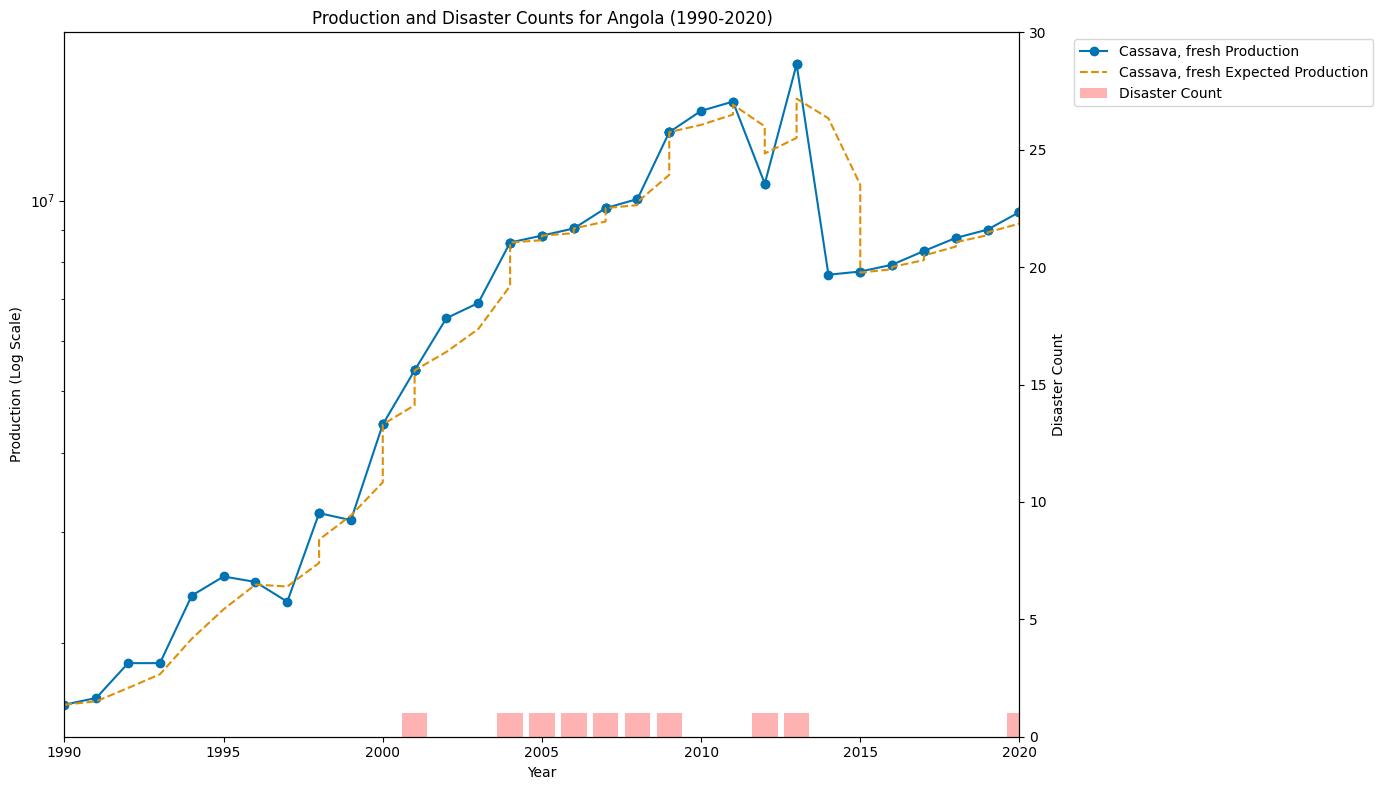

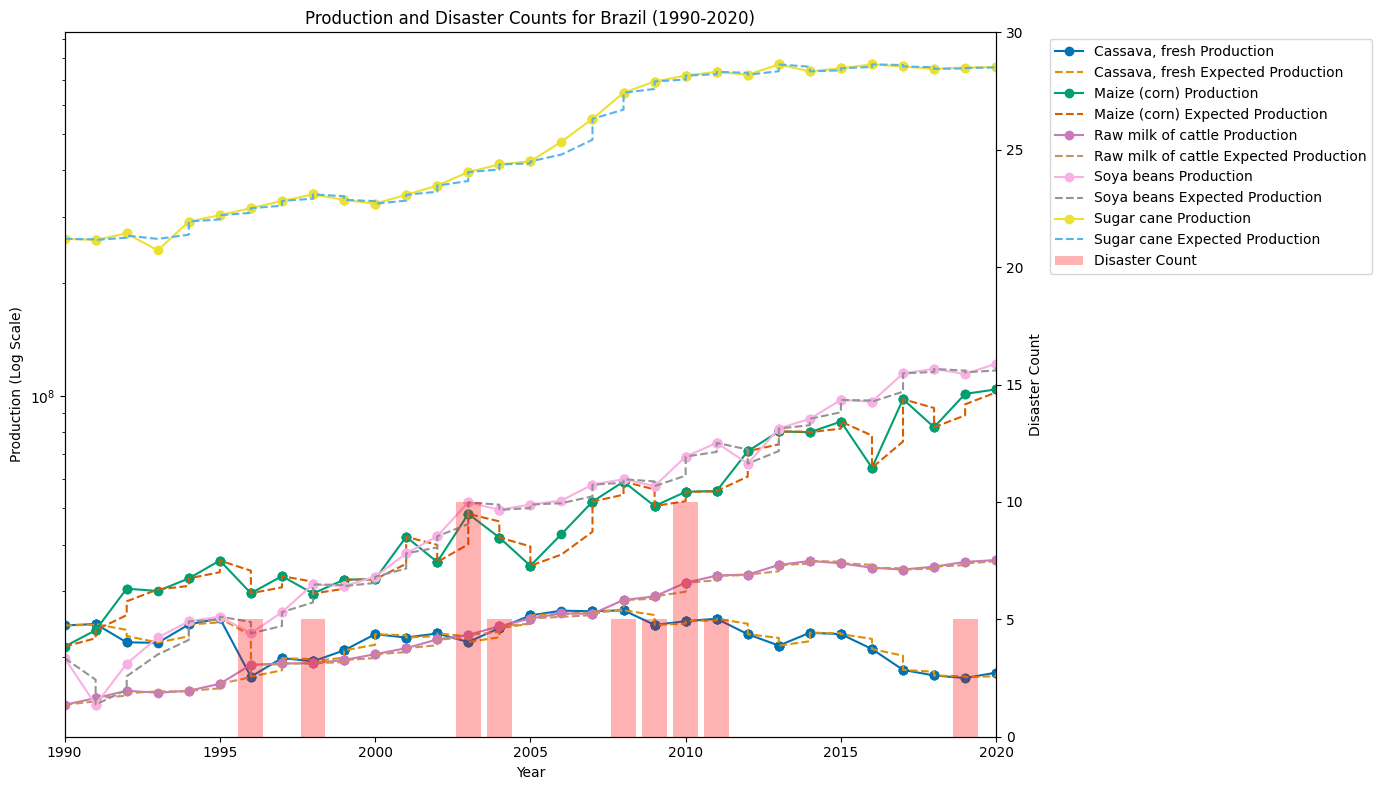

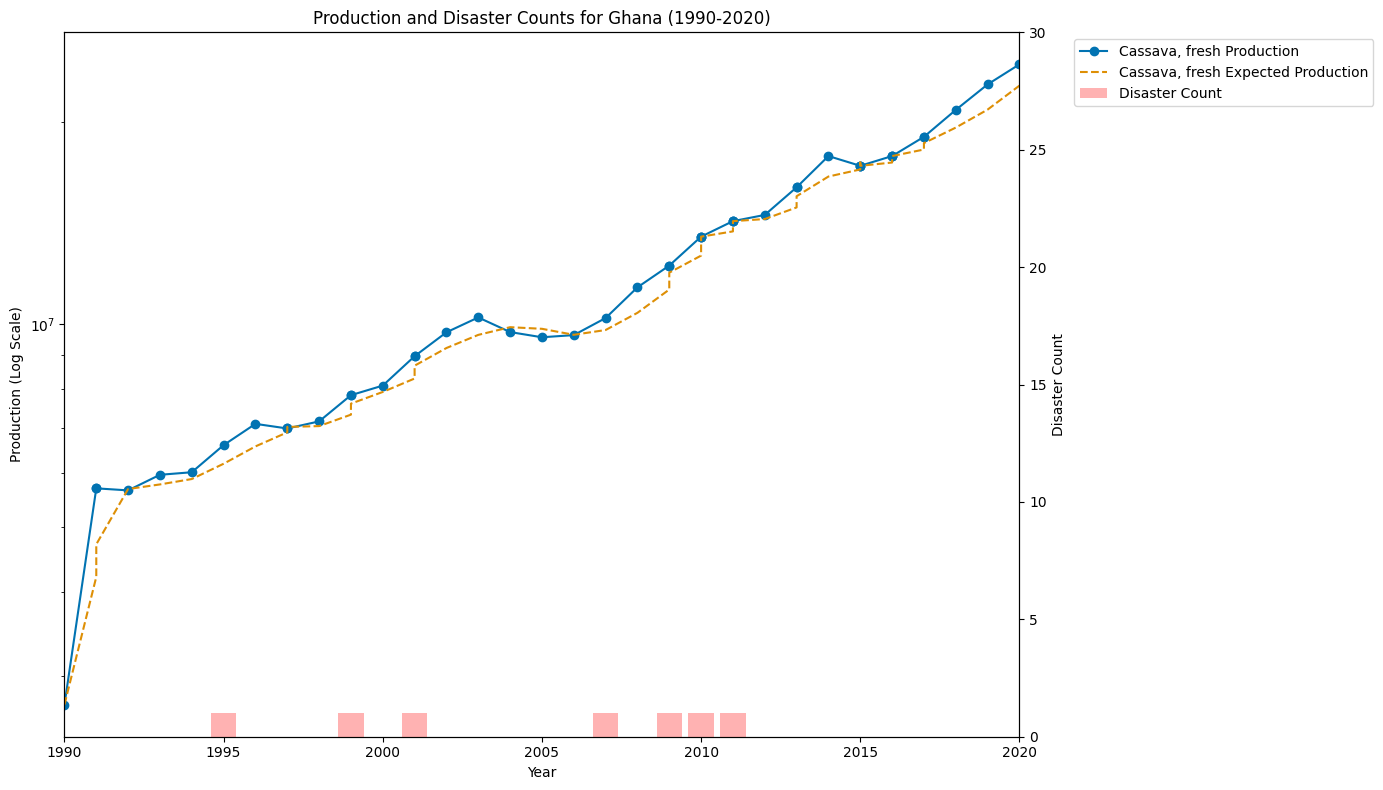

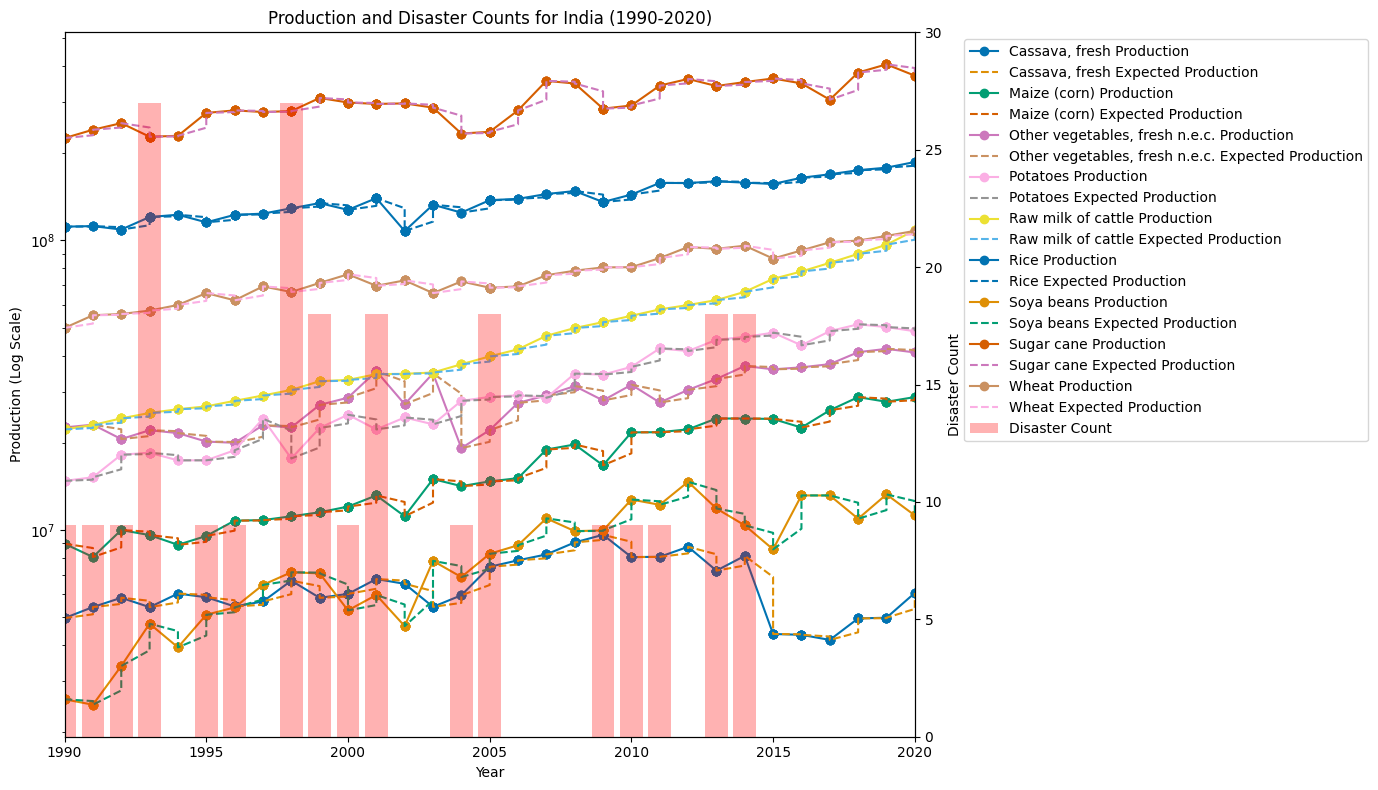

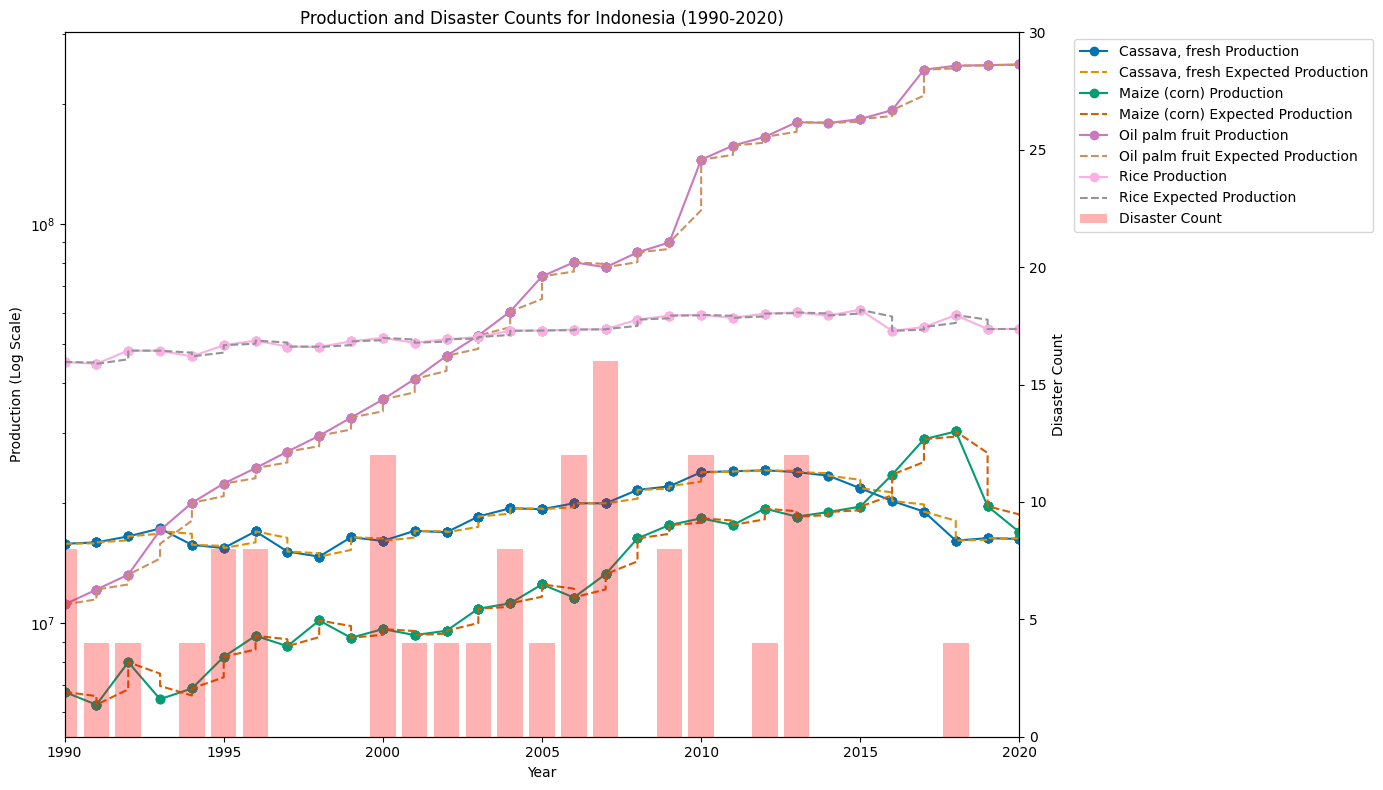

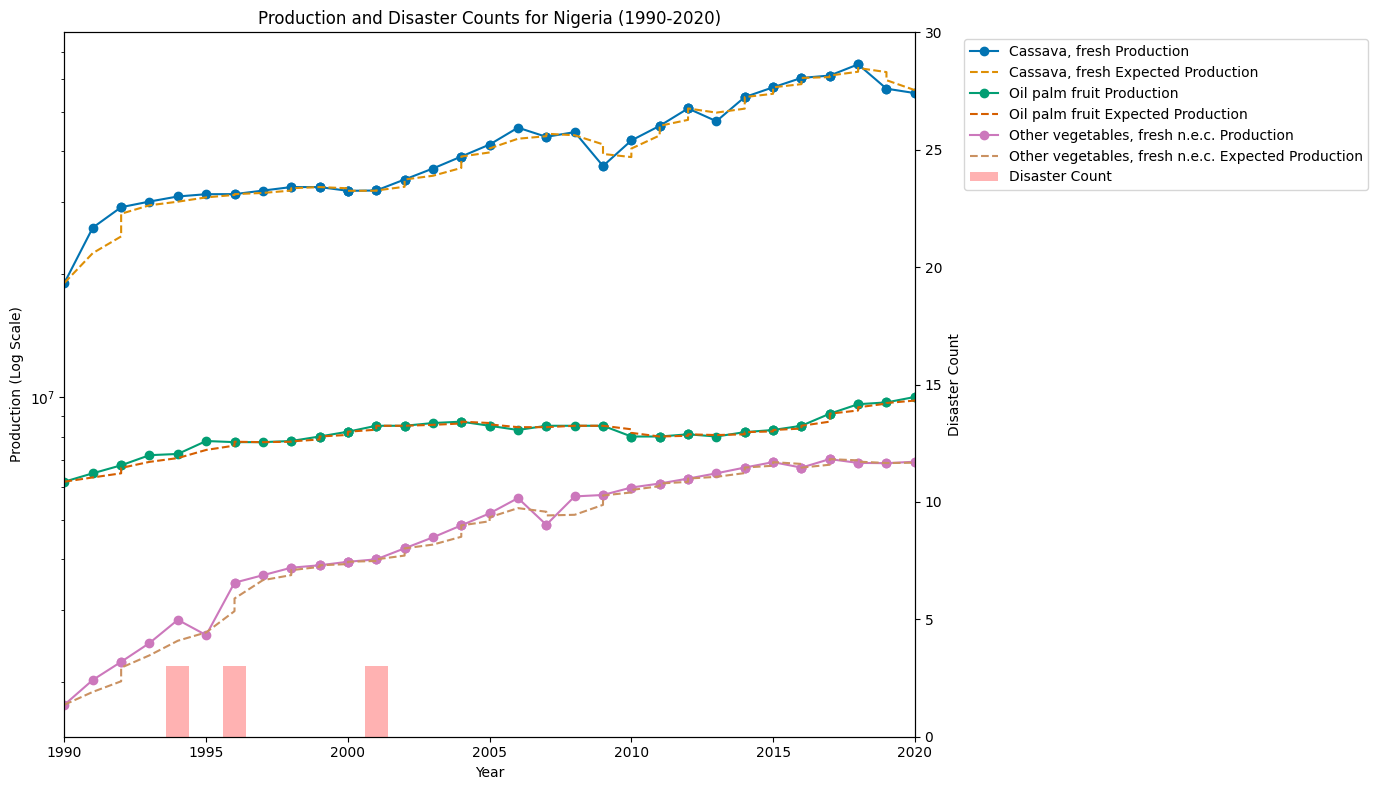

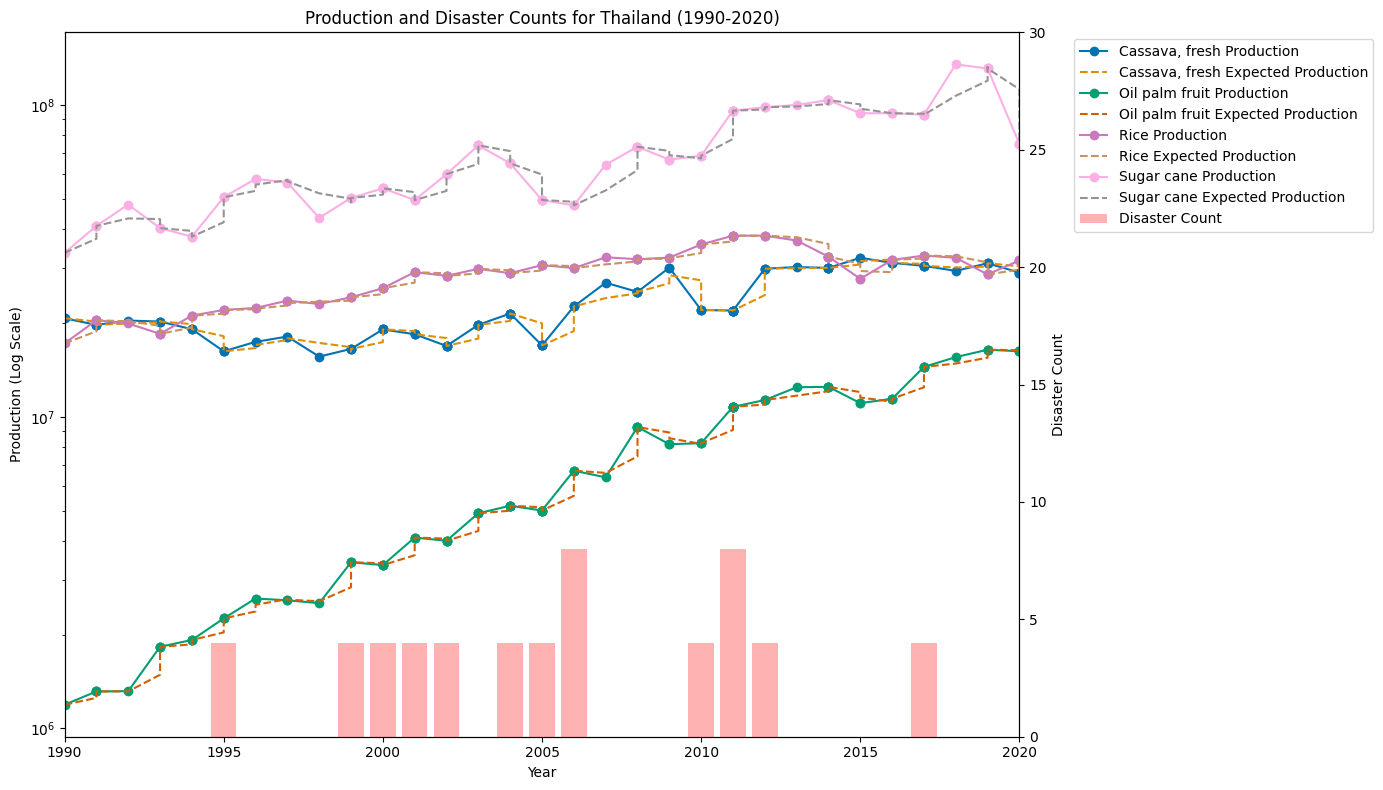

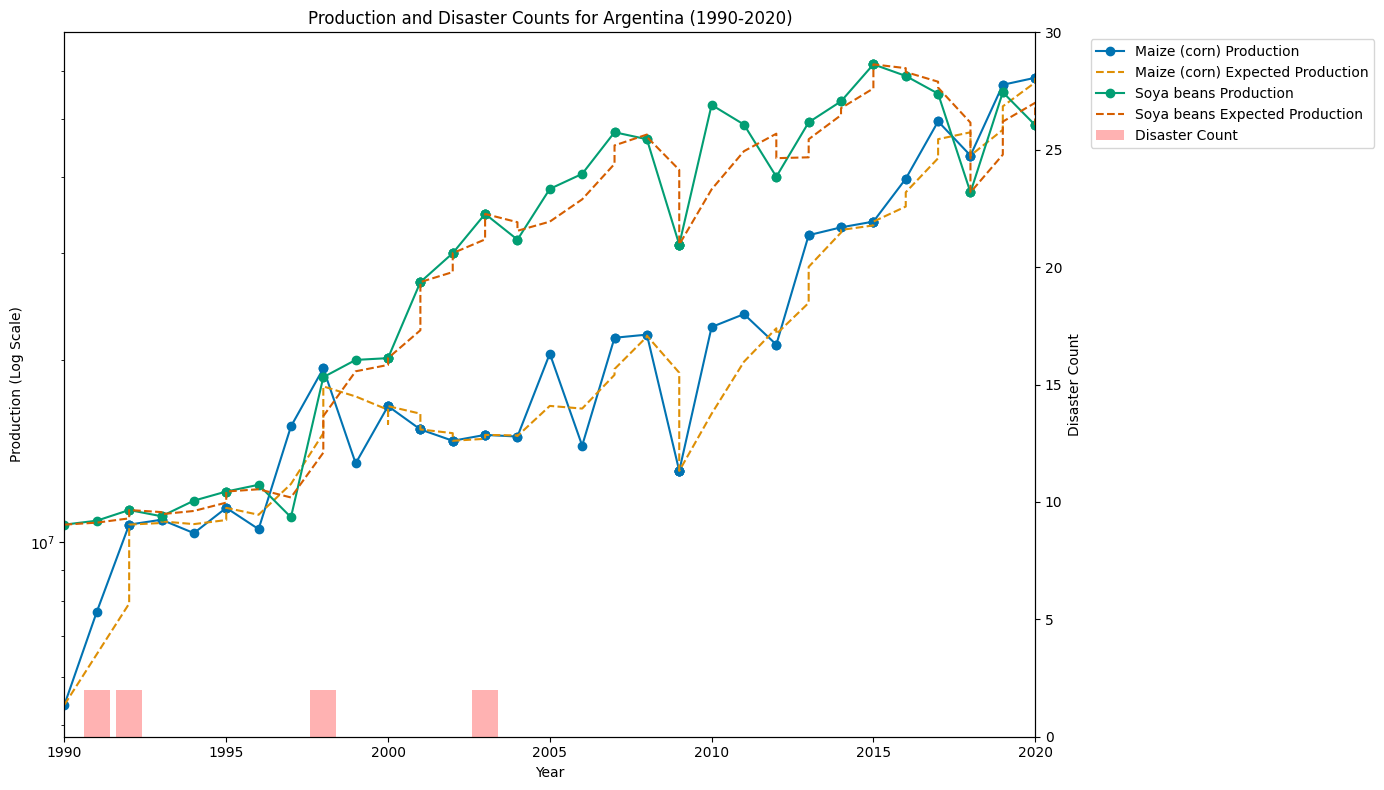

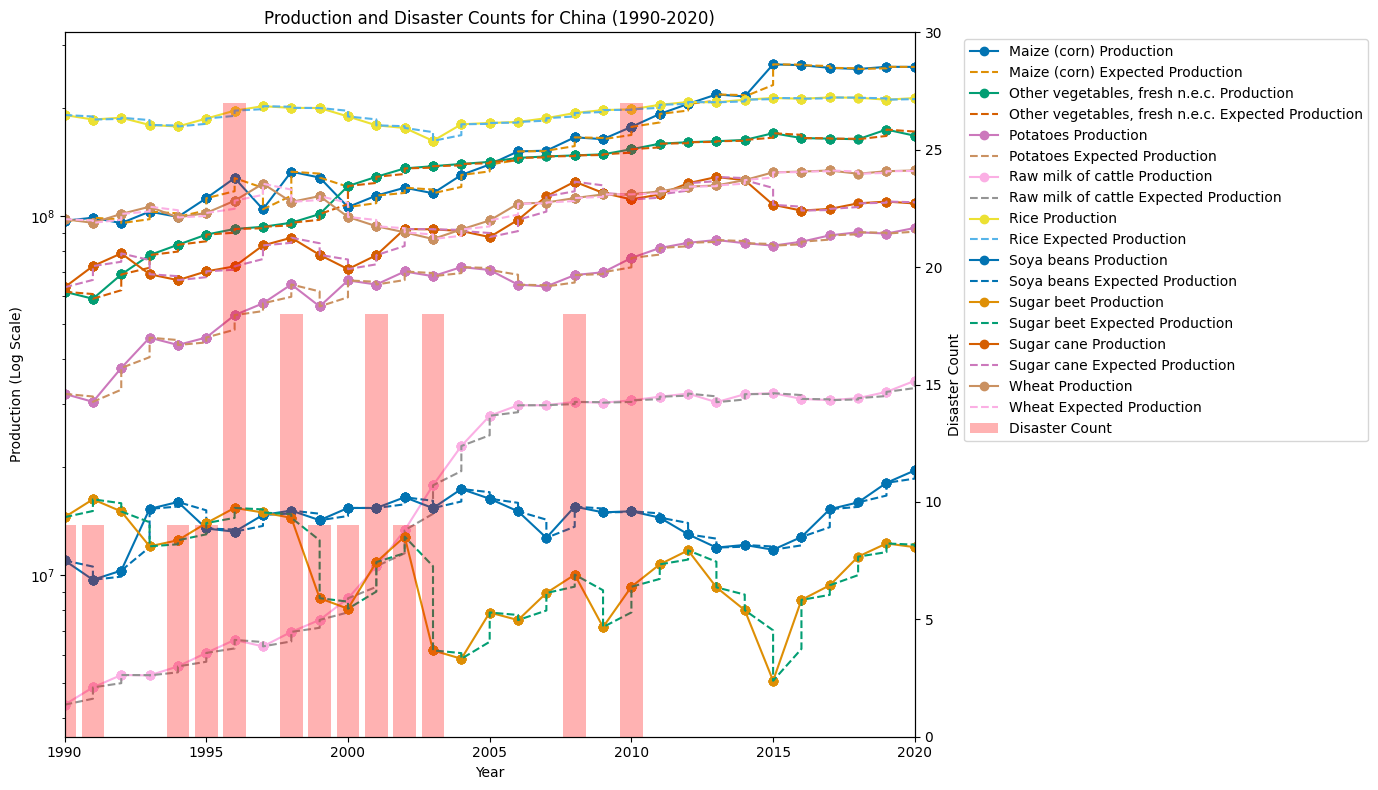

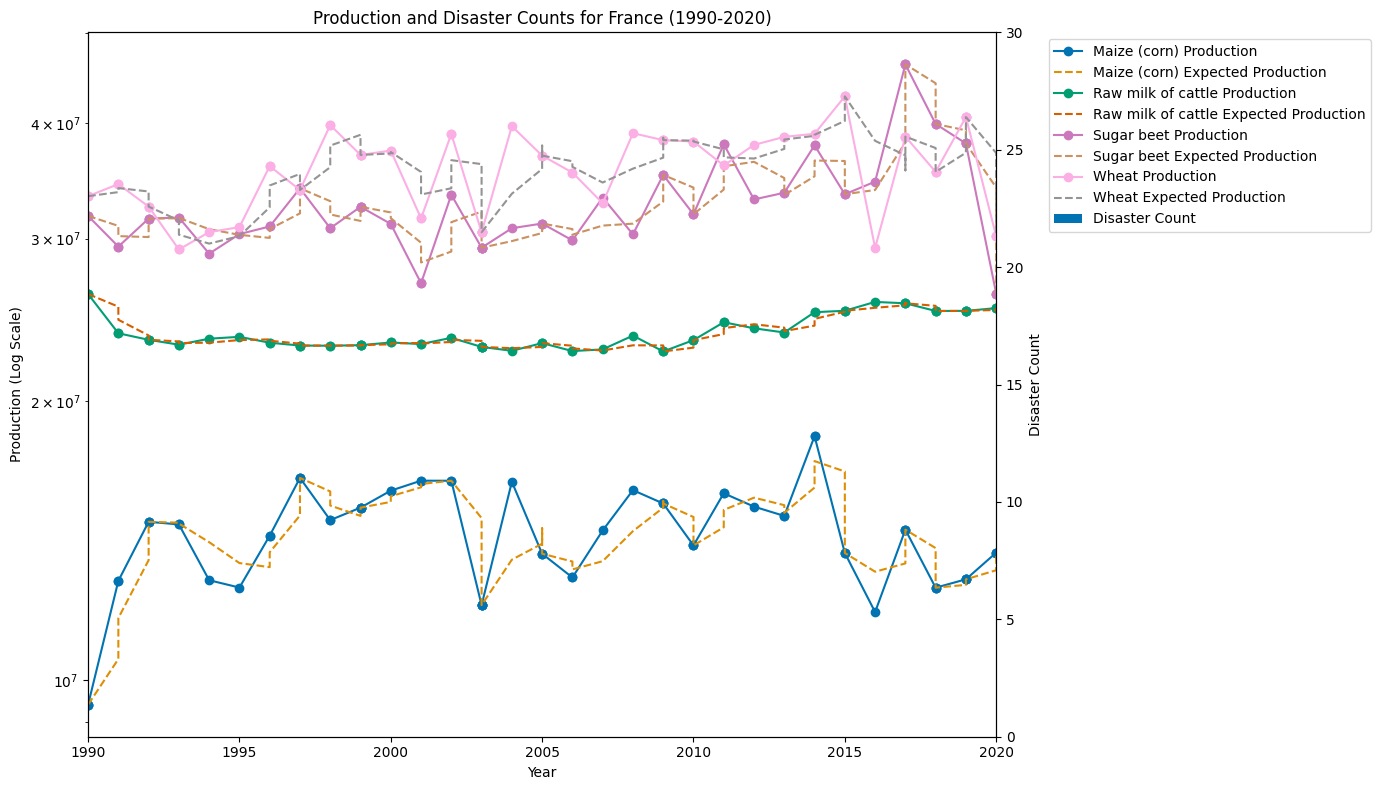

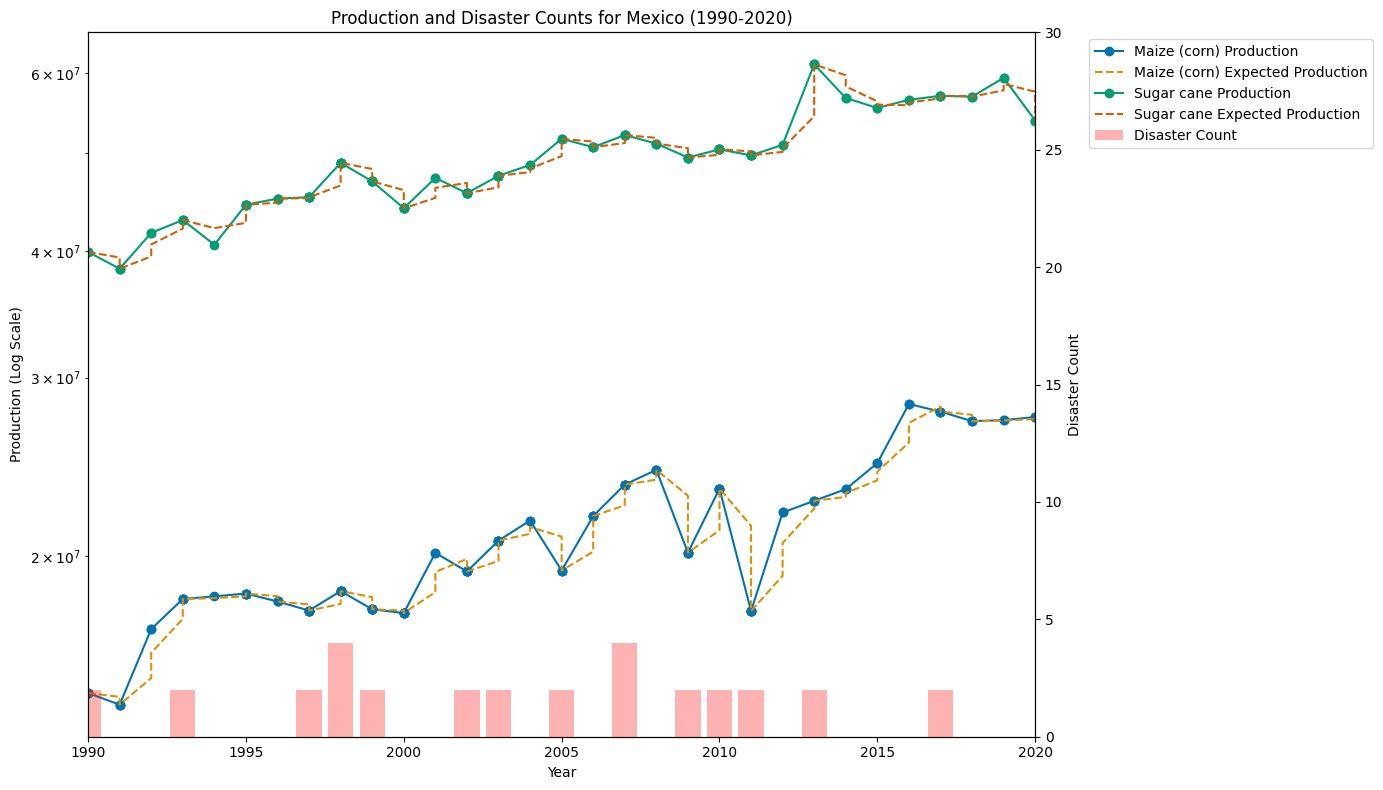

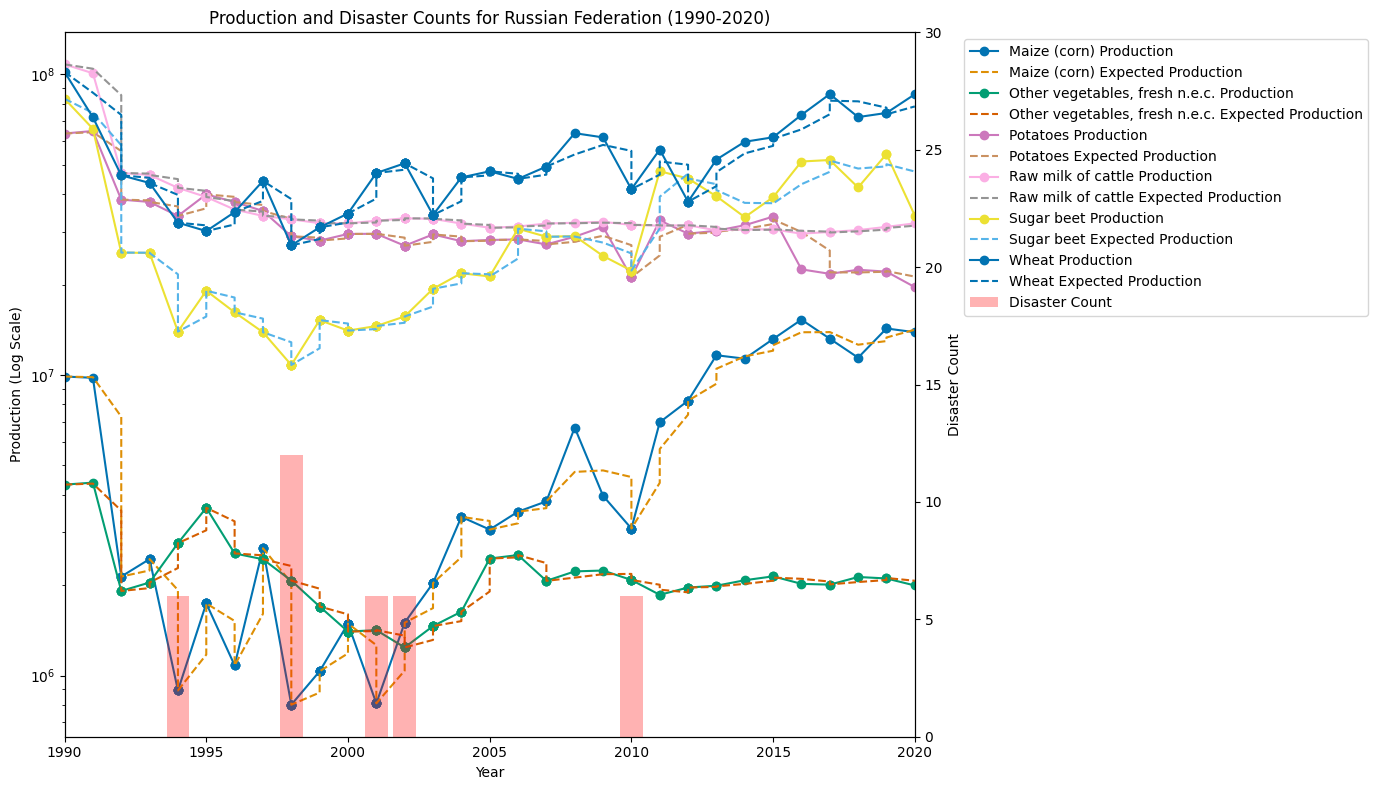

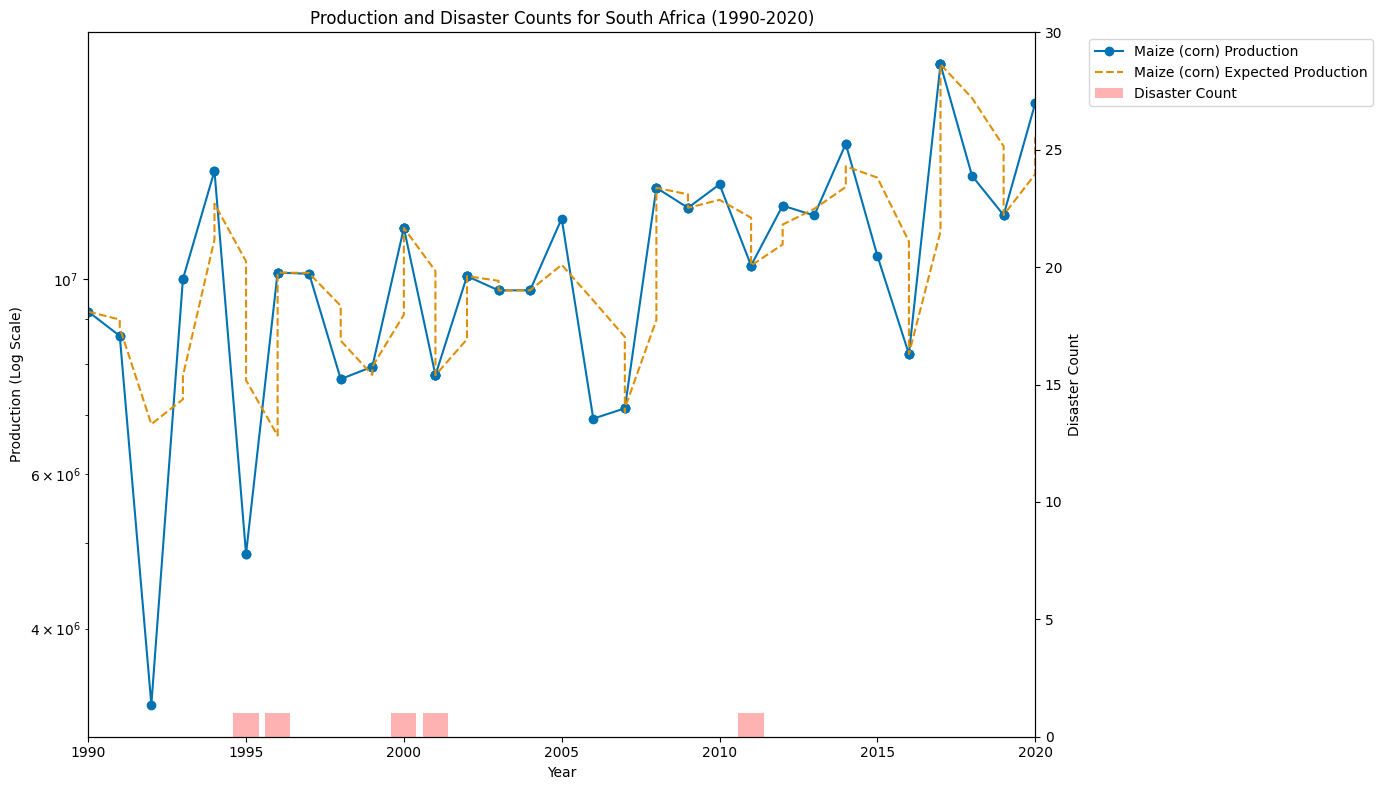

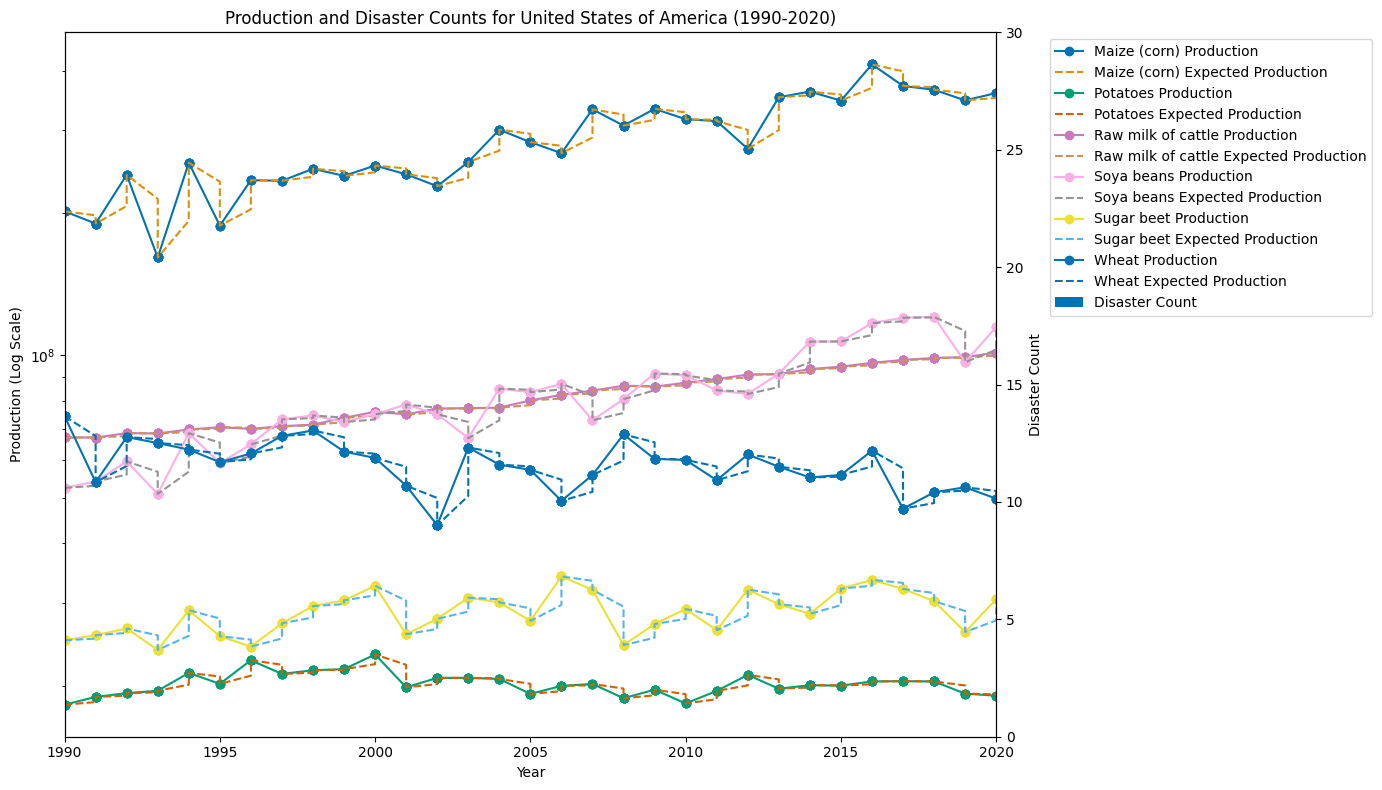

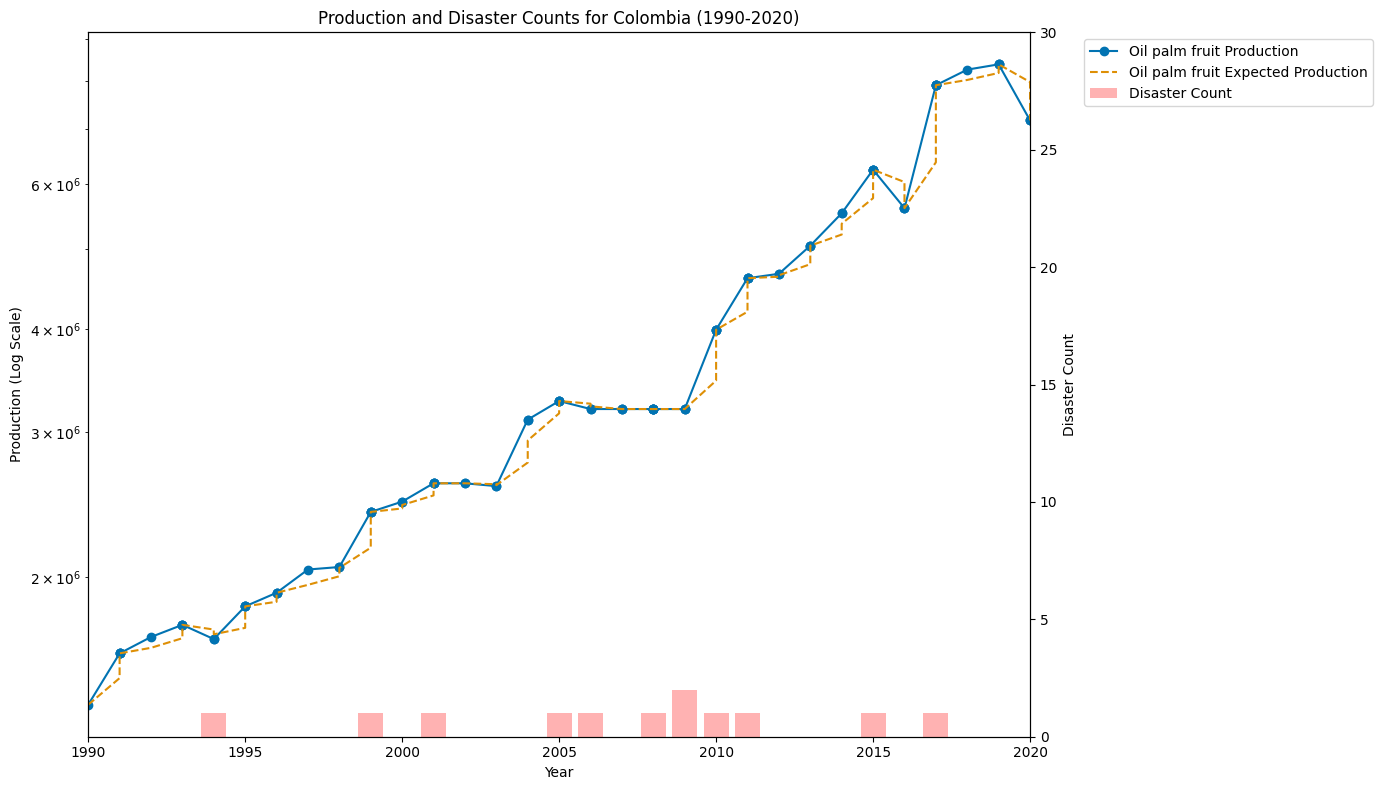

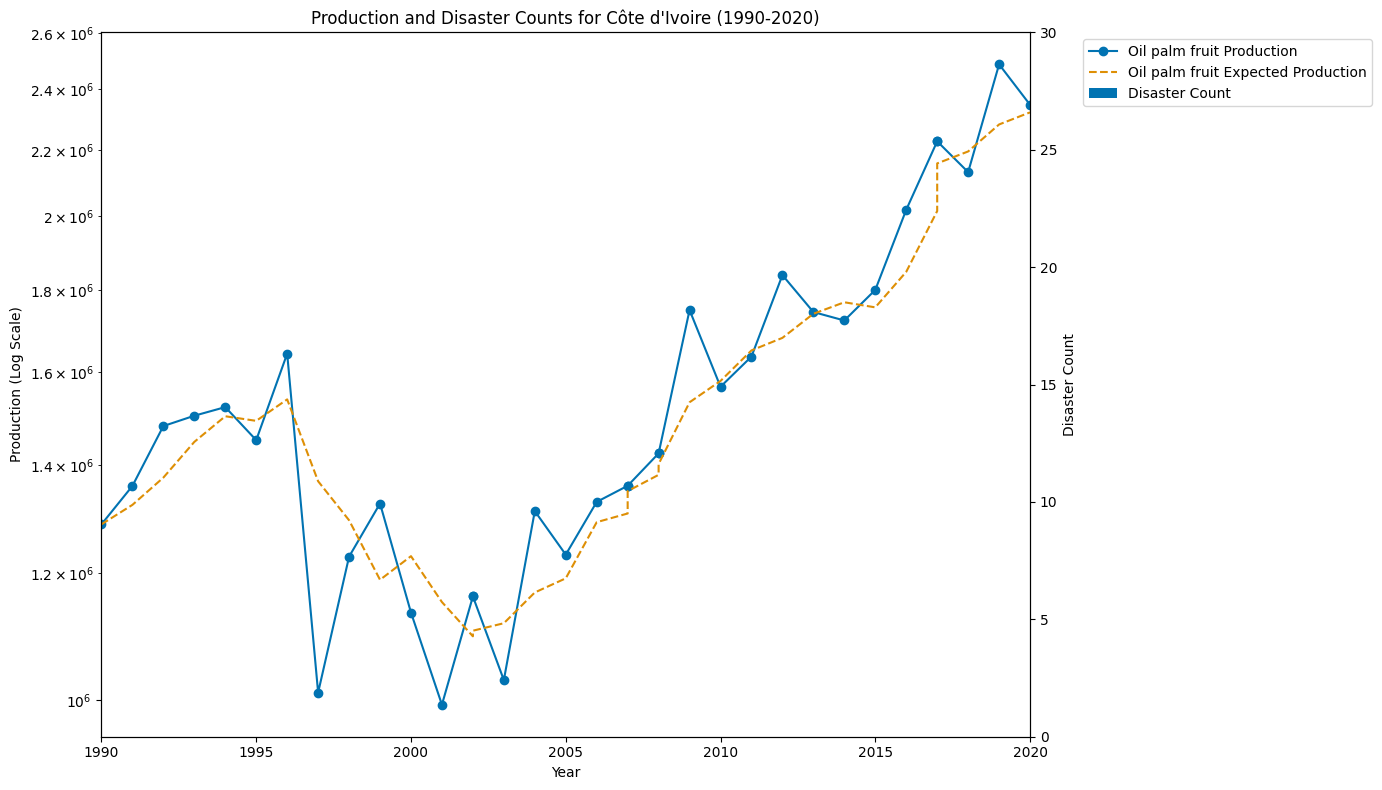

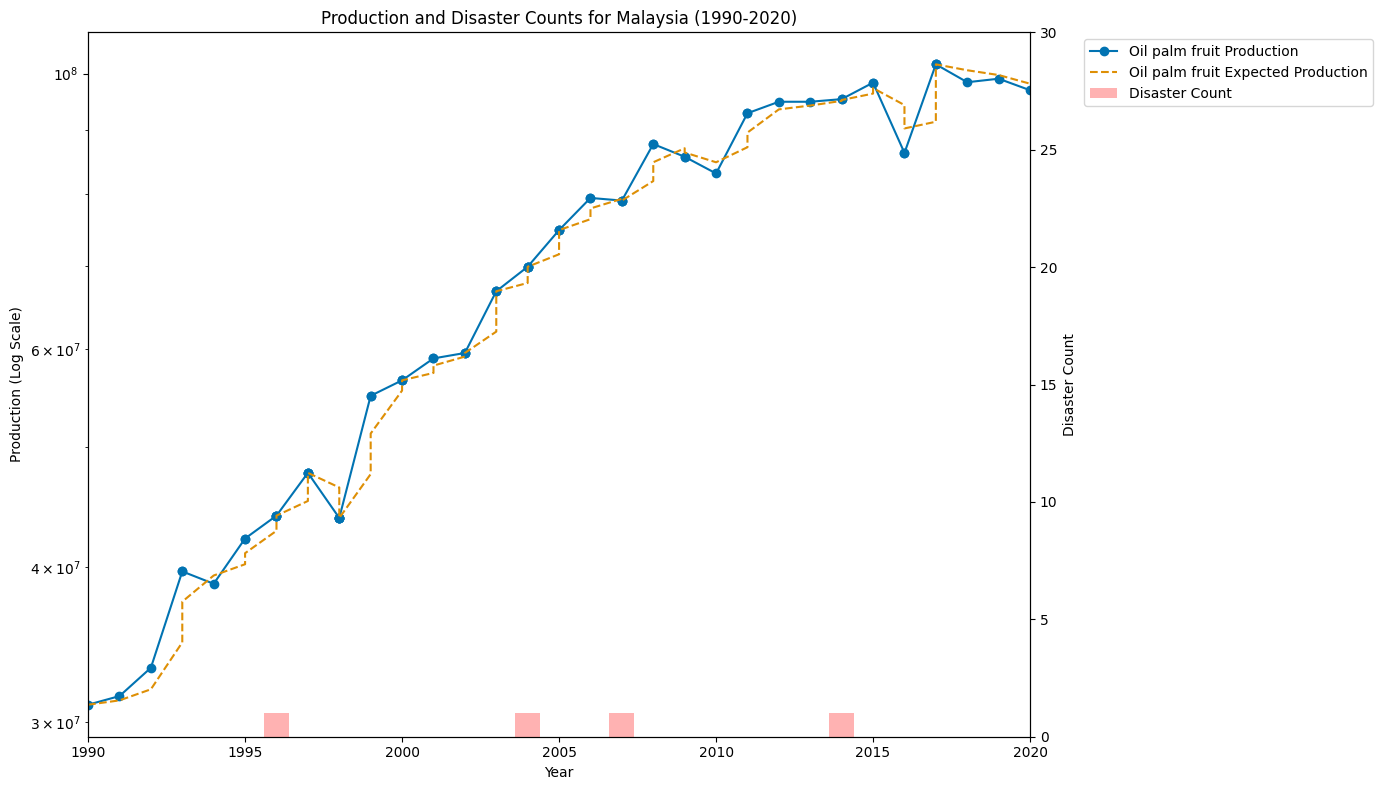

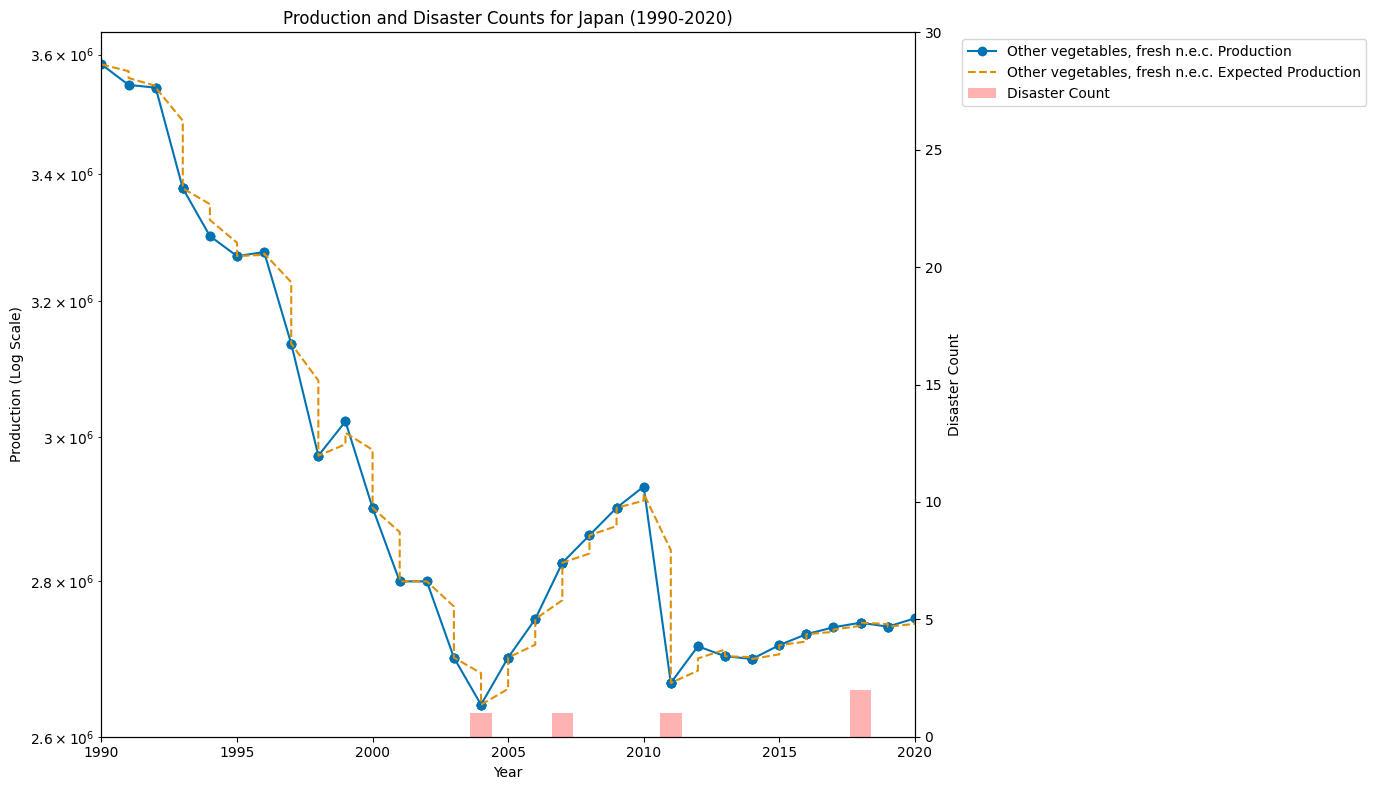

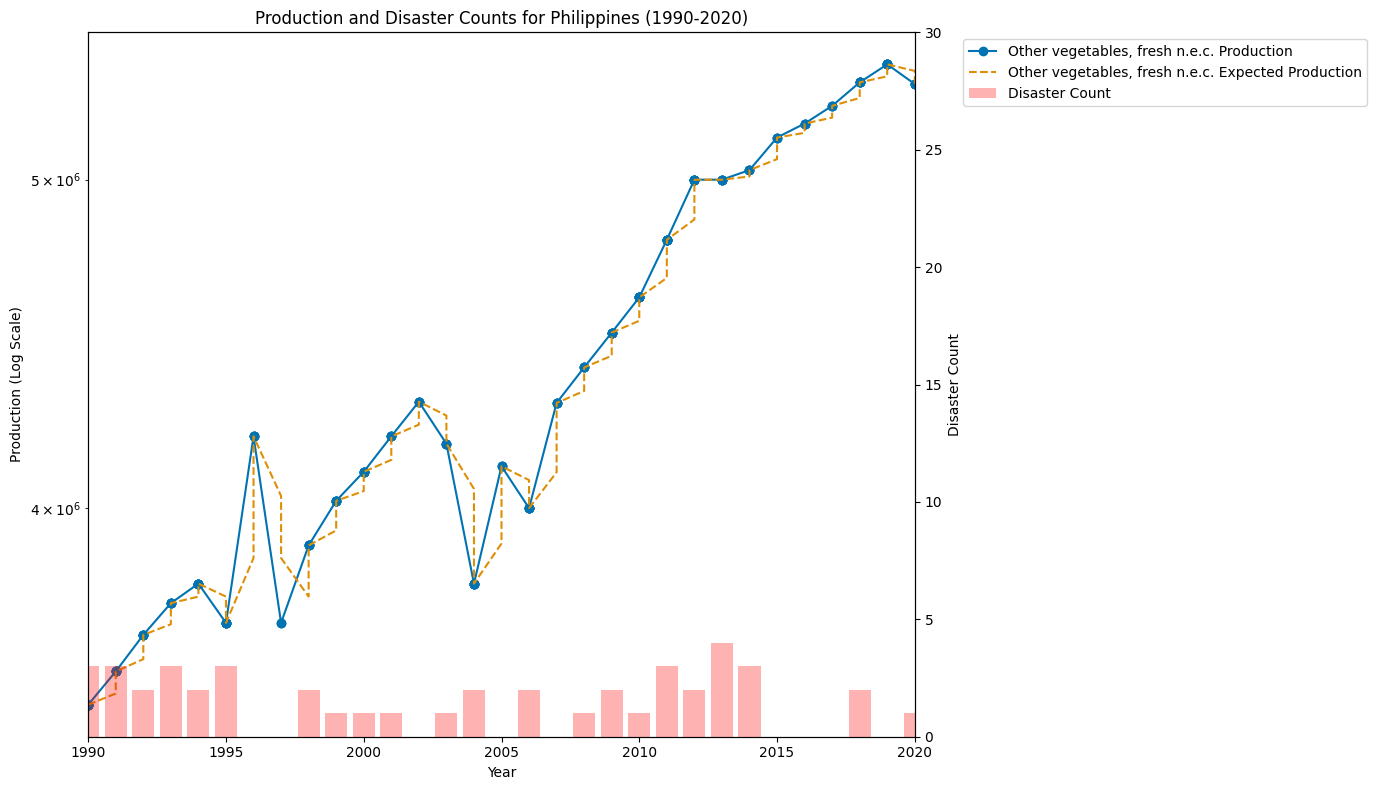

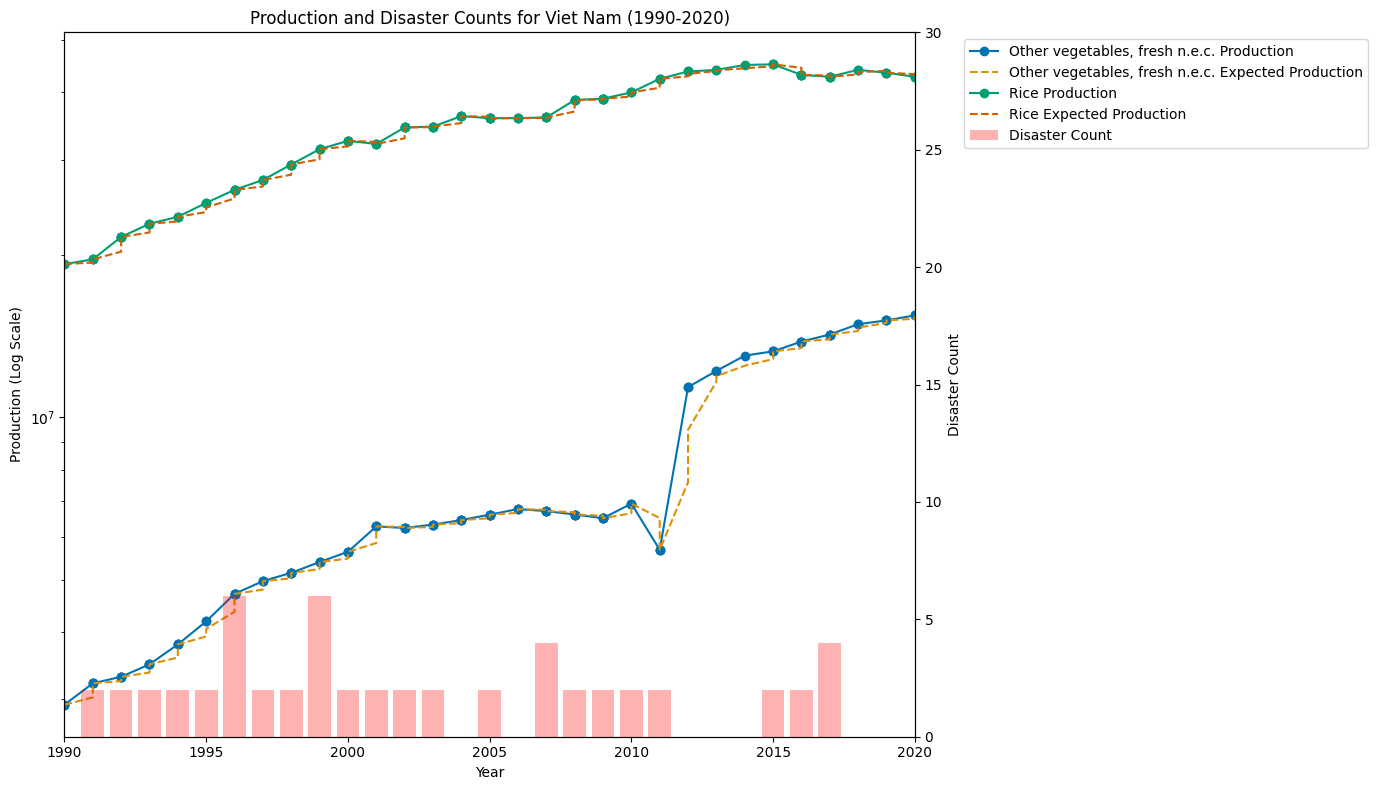

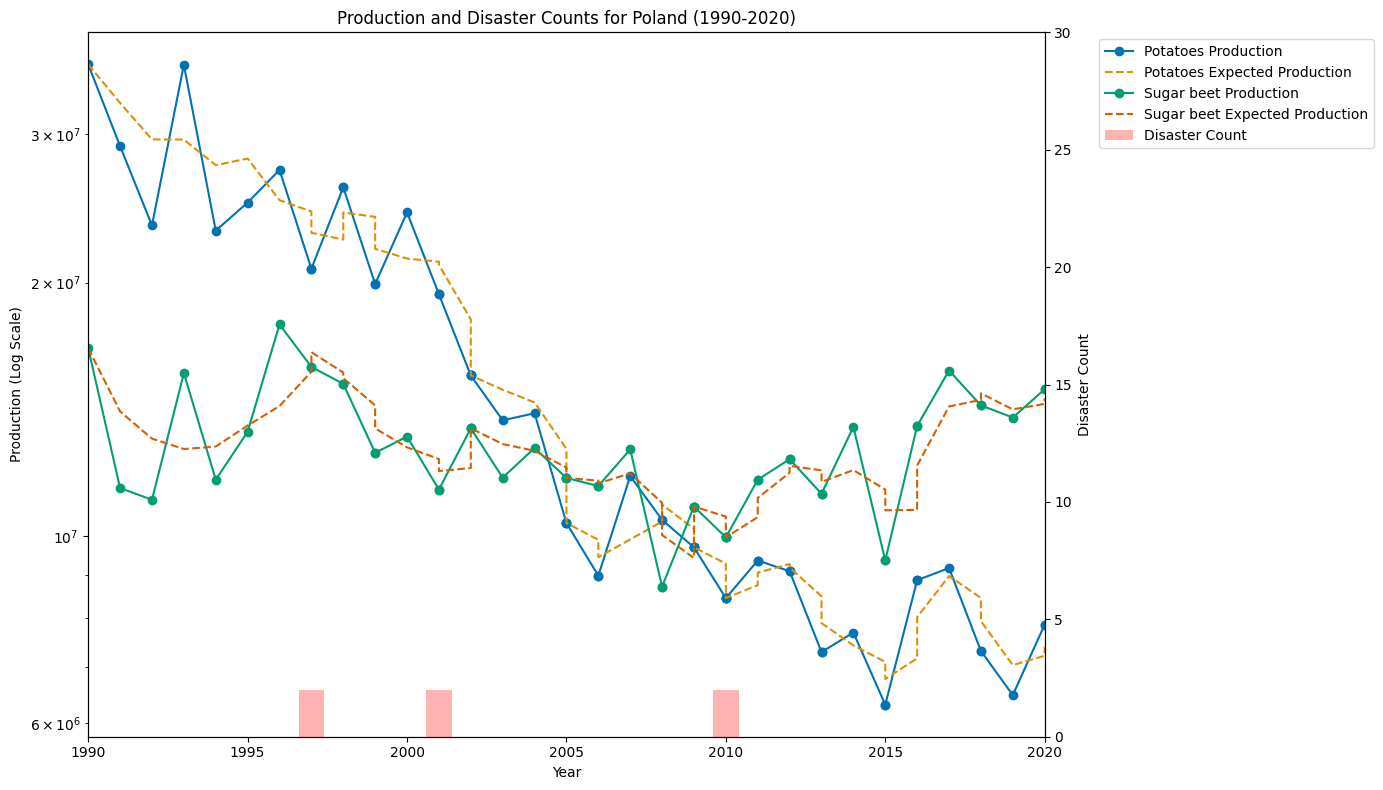

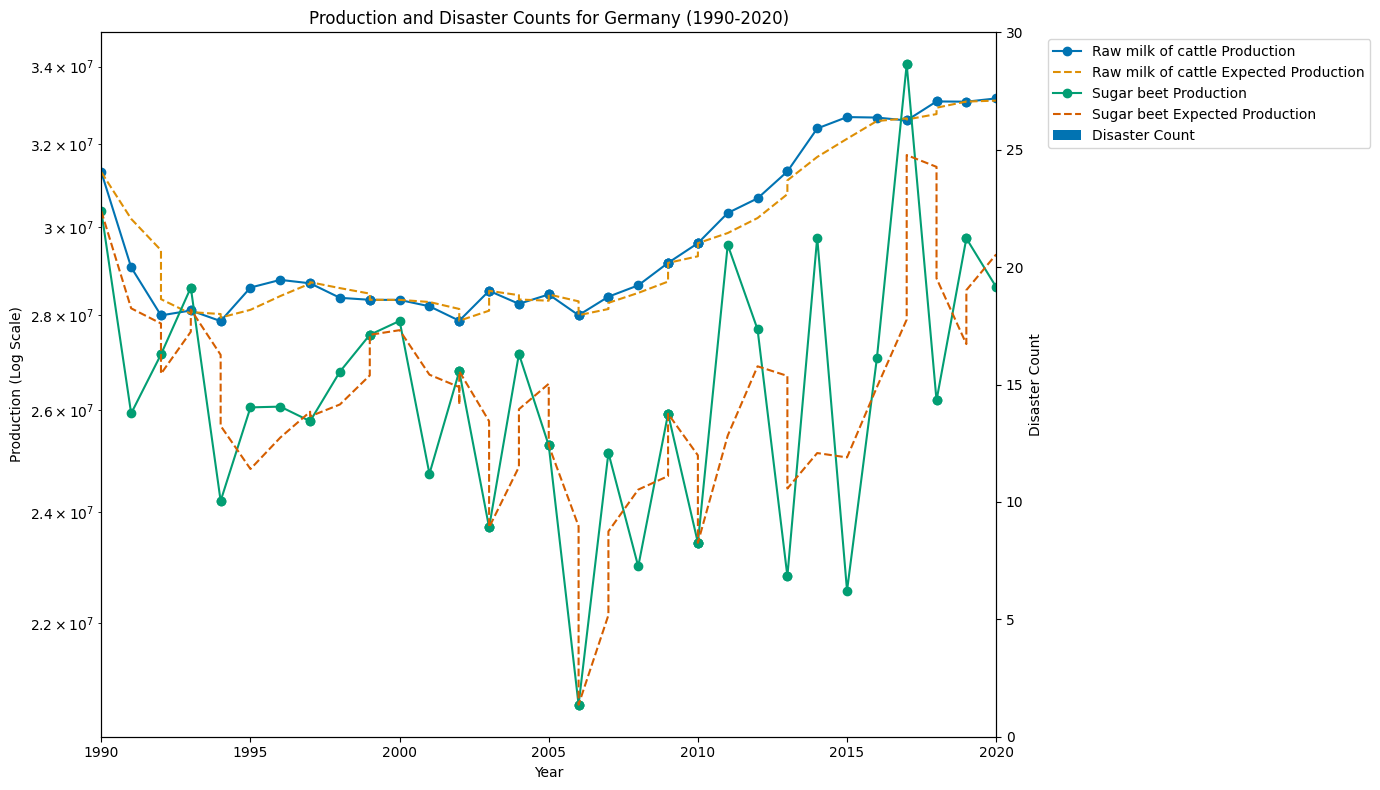

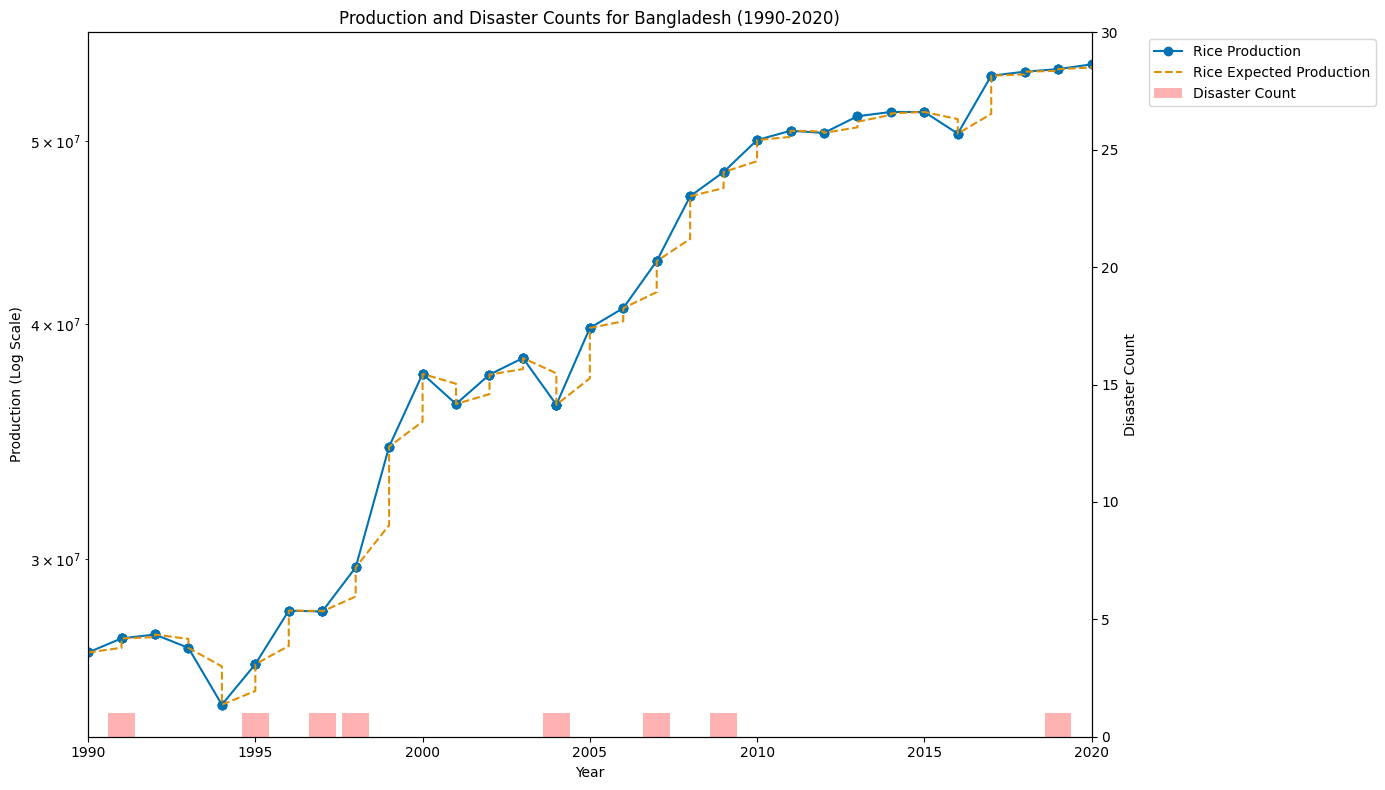

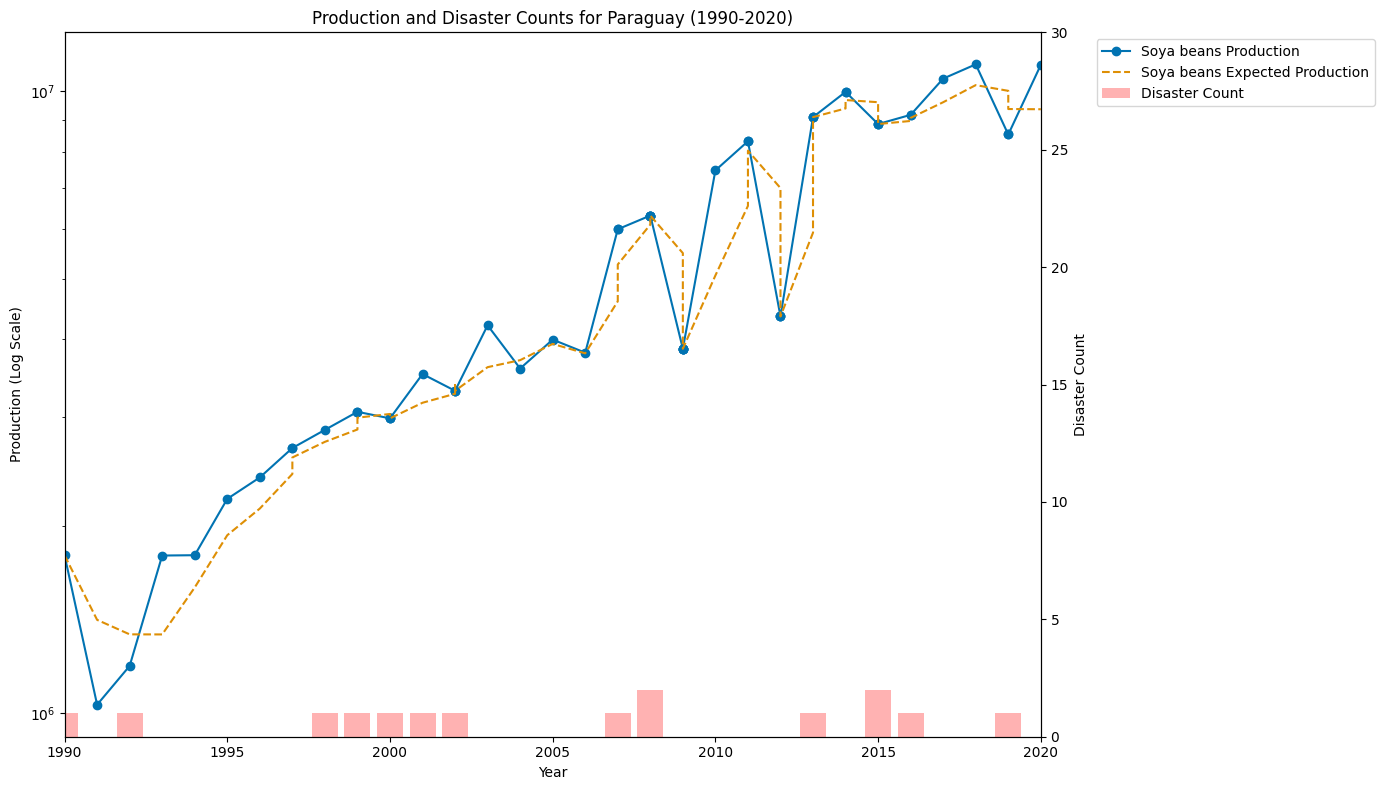

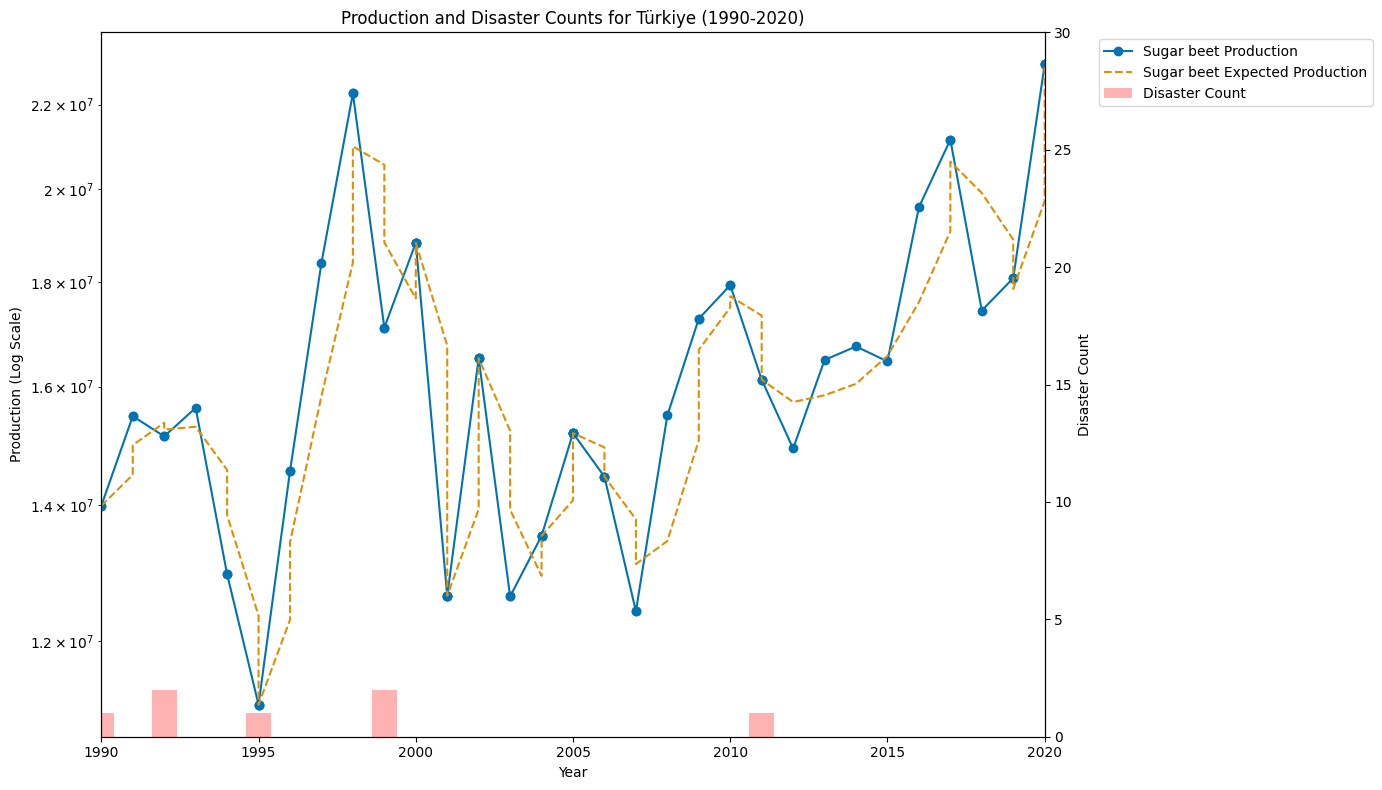

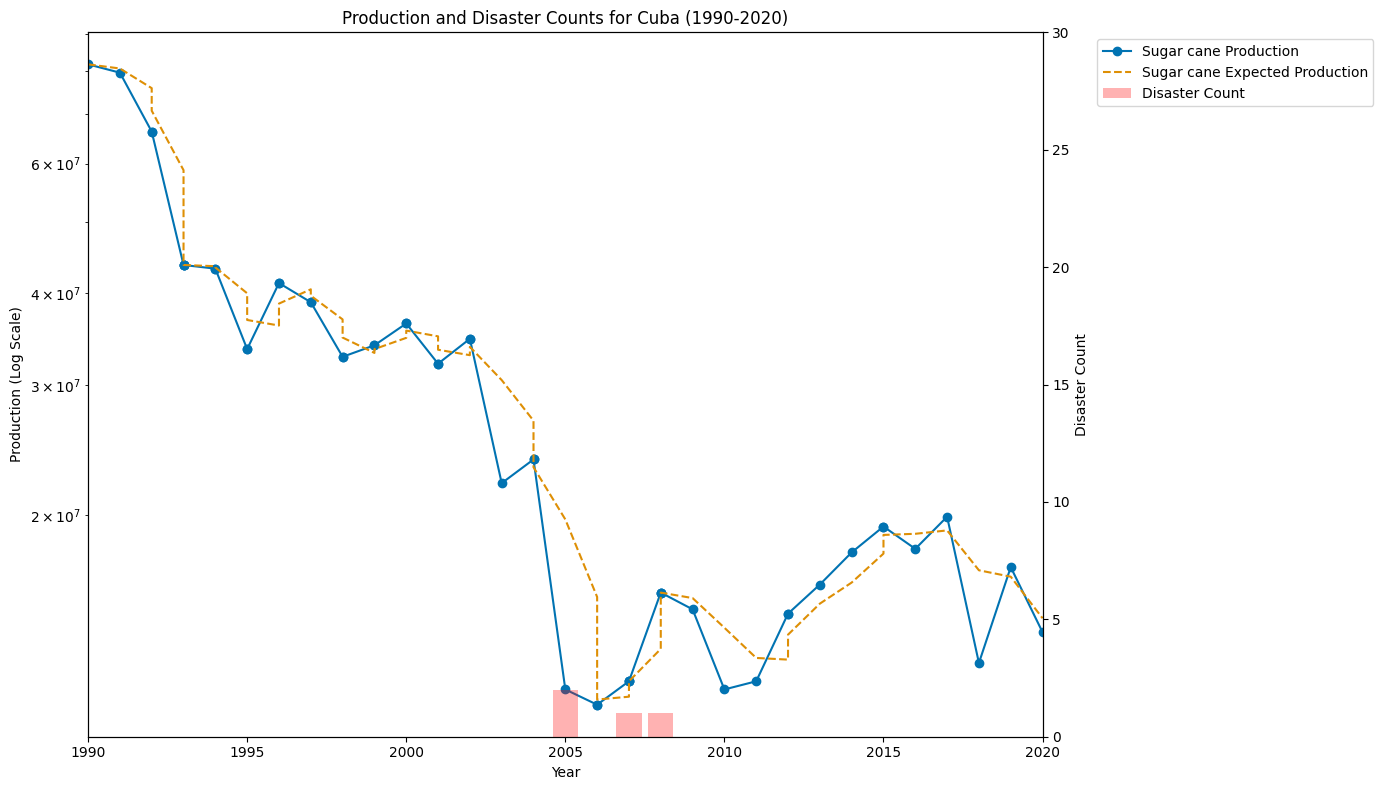

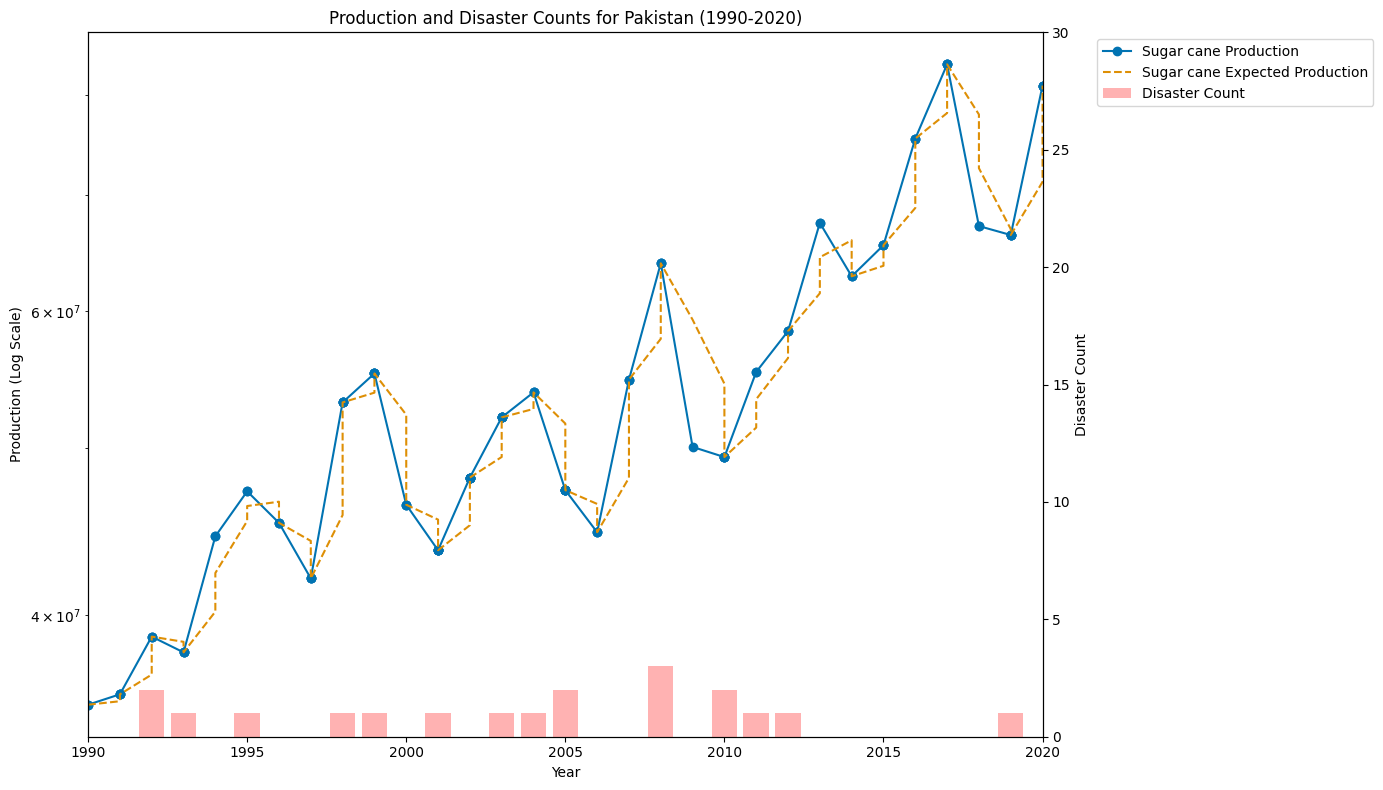

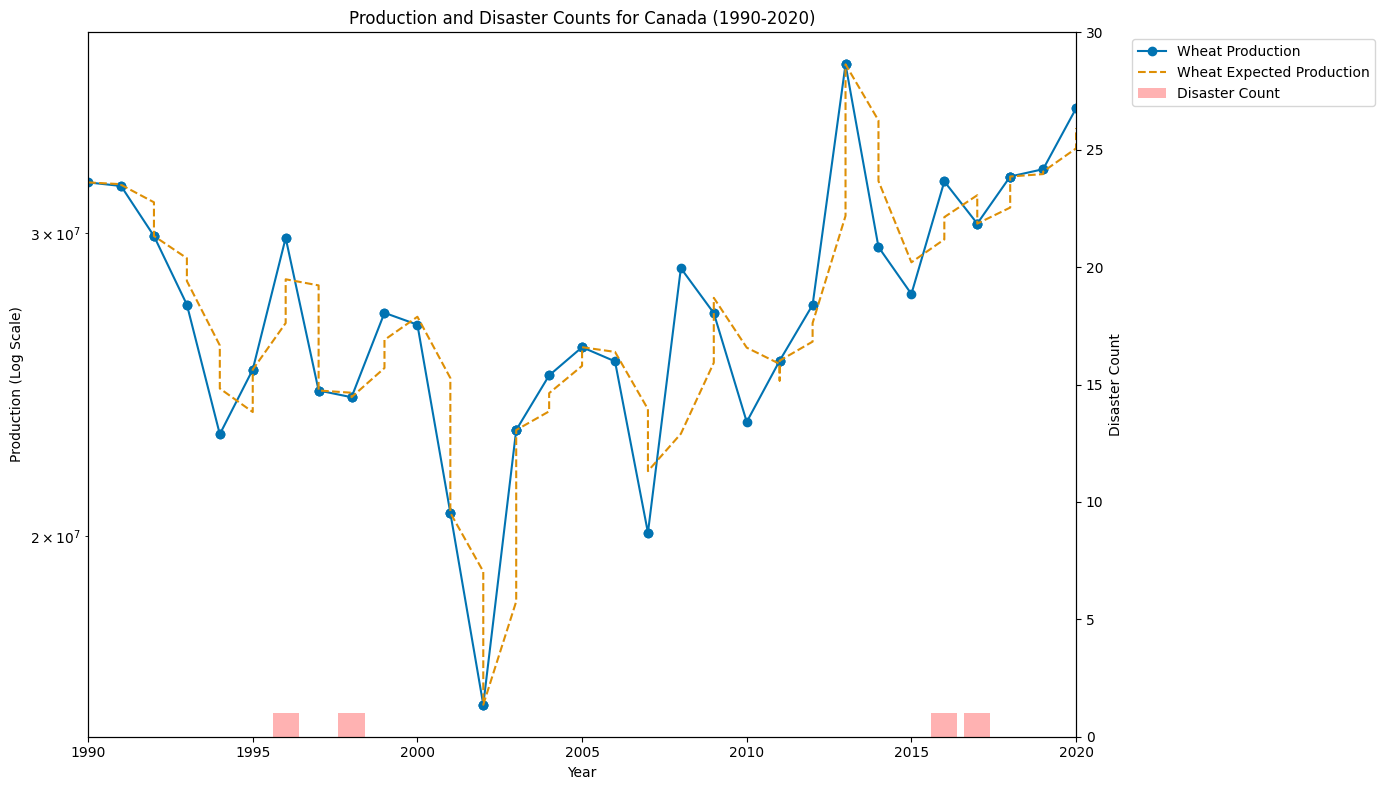

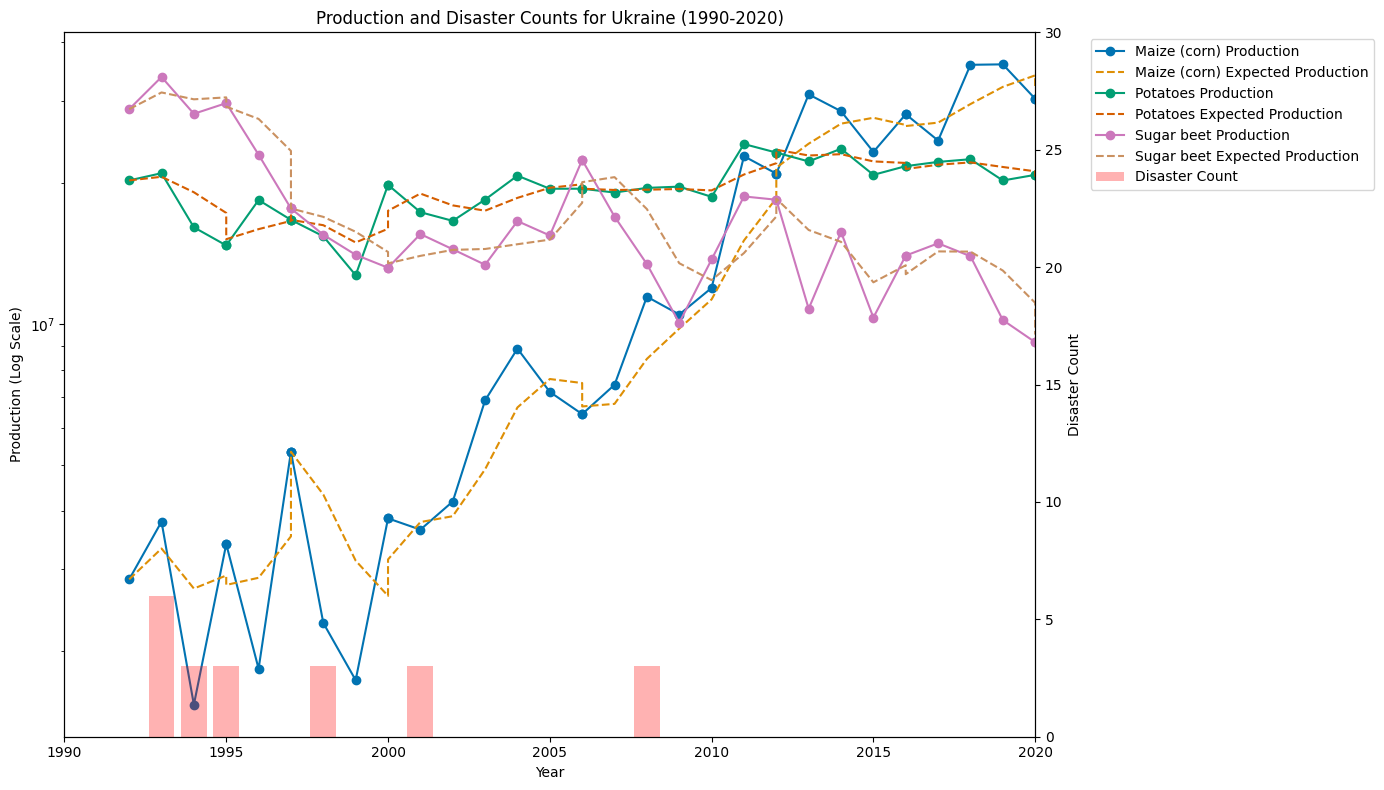

In [35]:
# get country data for each country in teh dataframe
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    
    # create a figure for each country
    fig, ax1 = plt.subplots(figsize=(14, 8))
    # COMMODITIES DATA
    # find the unique commodities for the country and plot them
    for item in country_data['Item'].unique():
        item_data = country_data[country_data['Item'] == item]
        # plot production
        ax1.plot(item_data['Year'], item_data['Production'], label=f'{item} Production', marker='o')
        # plot expected production
        ax1.plot(item_data['Year'], item_data['Expected_Production'], label=f'{item} Expected Production', linestyle='--')
    # set up the left y-axis for production
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Production (Log Scale)')
    ax1.set_yscale('log') # for better visibility
    ax1.tick_params(axis='y')


    # create a twin axis for disaster counts
    ax2 = ax1.twinx()
    # DISASTER DATA
    # count disasters with OFDA_BHA_Response of 1
    disaster_counts = country_data[country_data['OFDA_BHA_Response'] == 1]
    disaster_counts_summary = disaster_counts.groupby('Year')['Disaster_Count'].sum().reset_index()
    # plot disaster counts as bars
    ax2.bar(disaster_counts_summary['Year'], disaster_counts_summary['Disaster_Count'], 
            alpha=0.3, color='red', label='Disaster Count')
    # set up the right y-axis for disaster counts
    ax2.set_ylabel('Disaster Count')
    ax2.set_ylim(0, 30)
    ax2.tick_params(axis='y')

    # labels and title
    plt.title(f'Production and Disaster Counts for {country} (1990-2020)')
    plt.xlim(1990, 2020)
    # combine the legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

Some more visualizations to explore the combined data and check suspicions about trends.

Item                 Cassava, fresh  Maize (corn)  Oil palm fruit  \
Disaster_Type                                                       
Drought                    0.584746     -0.953490        1.767415   
Earthquake                -0.652195      2.996628        2.244068   
Epidemic                   4.425185      6.305285        2.640152   
Extreme temperature        0.086496      1.759167        0.000000   
Flood                      2.787433     10.453291        2.067065   
Impact                     0.000000      0.416663        0.000000   
Infestation               -0.071959     -0.420322        0.095855   
Mass movement (dry)        0.083024      0.022978        0.195783   
Mass movement (wet)        0.037403     -0.358685        0.231091   
No Disaster               -0.127621      0.307872        0.482867   
Storm                      0.110820      1.266447       -0.110933   
Volcanic activity          0.025682      0.348223        0.318567   
Wildfire                   0.07551

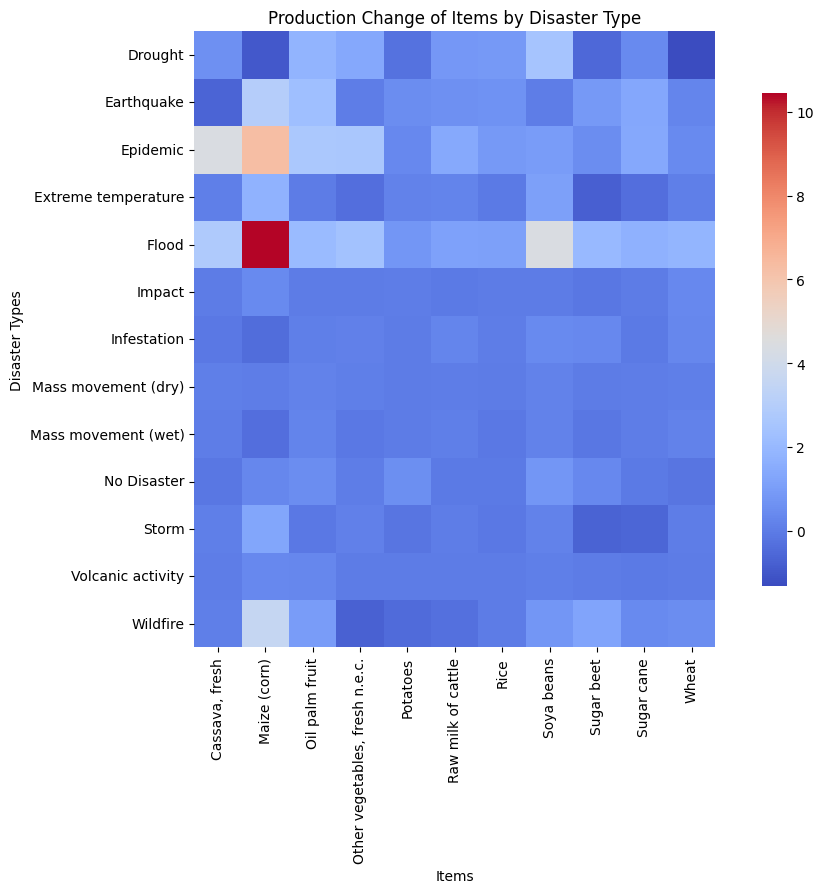

In [36]:
# Group by 'Disaster_Type' and 'Item', summing 'Total_Production'
production_by_disaster = merged_df.groupby(['Disaster_Type', 'Item'])['Production_Change'].sum().unstack(fill_value=0)
print(production_by_disaster)
# Create a heatmap to visualize the total production of each item under different disaster types
plt.figure(figsize=(12, 8))
# Create the heatmap
sns.heatmap(production_by_disaster, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# Set titles and labels
plt.title('Production Change of Items by Disaster Type')
plt.xlabel('Items')
plt.ylabel('Disaster Types')
# Show the plot
plt.show()

According to this heatmap, floods seem to have a more positive impact on production compared to other disasters. Droughts seem to have varying impacts on crops. 

                   Production  Disaster_Count  Disaster_Duration  \
Production           1.000000        0.104486           0.066648   
Disaster_Count       0.104486        1.000000          -0.118440   
Disaster_Duration    0.066648       -0.118440           1.000000   
OFDA_BHA_Response   -0.029462       -0.172070           0.013149   

                   OFDA_BHA_Response  
Production                 -0.029462  
Disaster_Count             -0.172070  
Disaster_Duration           0.013149  
OFDA_BHA_Response           1.000000  


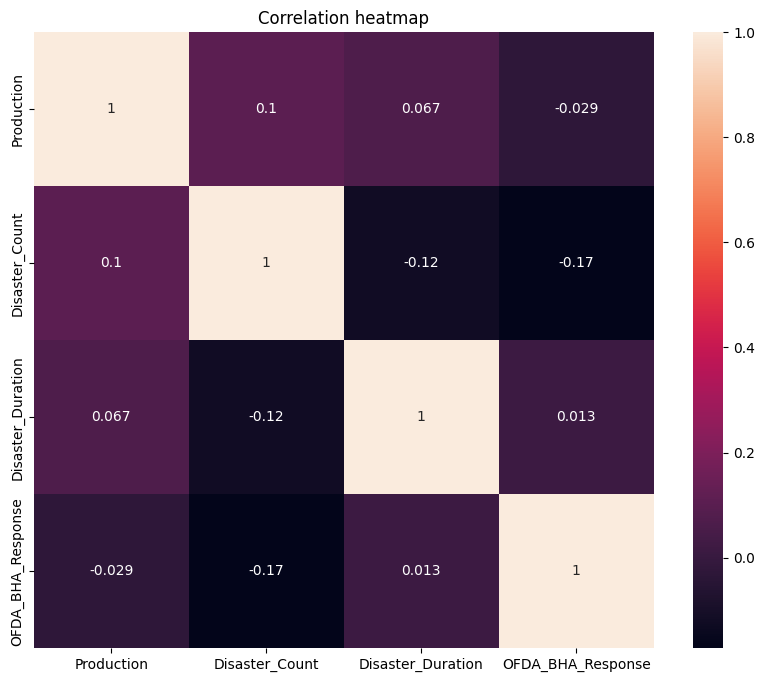

In [37]:
# Correlation 
correlation = merged_df[['Production', 'Disaster_Count', 'Disaster_Duration', 'OFDA_BHA_Response']].corr()
print(correlation)
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True)
plt.title('Correlation heatmap')
plt.show()

This heatmap points to a lot more research and investigation to be done. There are weak correlations across the board and more questions than answers for disasters in particular. It would be interesting to dig more into the Disaster Duration, Disaster Count, and OFDA/BHA Reponse (or a true intensity score). There is sentiment that extreme weather events are increasing in frequency and intensity, and another study to explore that sentiment would be really interesting. 

Below, this boxplot is to explore the suspicion that more severe disasters that call on an OFDA/BHA Reponse would also have the country import more goods to support the population while recovering and rebuilding. 

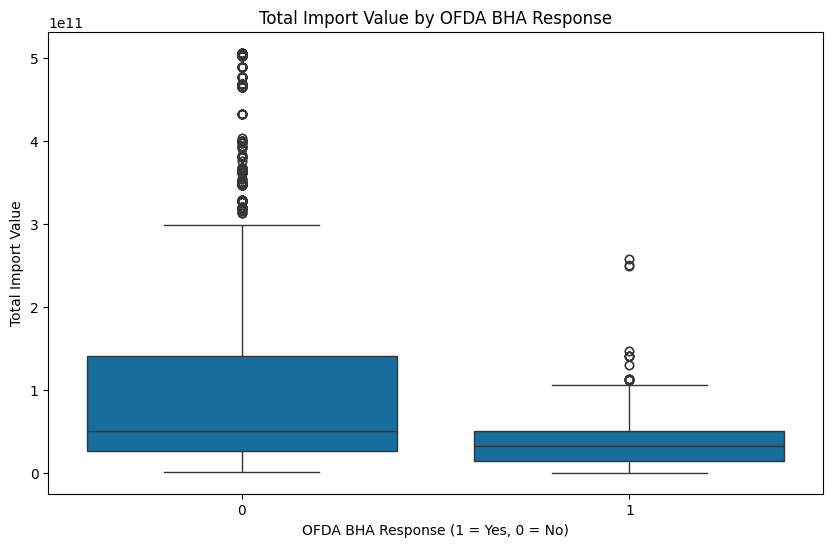

In [38]:
#plot of Total Import Value vs OFDA BHA Response
plt.figure(figsize=(10, 6))
sns.boxplot(x='OFDA_BHA_Response', y='Total_Import_Value', data=merged_df)
plt.title('Total Import Value by OFDA BHA Response')
plt.xlabel('OFDA BHA Response (1 = Yes, 0 = No)')
plt.ylabel('Total Import Value')
plt.show()

# Separate the data into two groups
group_yes = merged_df[merged_df['OFDA_BHA_Response'] == 1]['Total_Import_Value']
group_no = merged_df[merged_df['OFDA_BHA_Response'] == 0]['Total_Import_Value']

This suspicion is proved incorrect by this plot. To gain a more accurate result, investigation into what the top food imports are during disasters would be helpful to filter the import data.

****
ANALYSIS

To assess the relationship between disasters and commodities, I opted for a Poisson Generalized Linear Model. I looked at disasters that required an OFDA/BHA Response (since they seem to be more severe as far as how many they affect) and Year and Production of various commodities in various countries.

In [47]:
# shaprio test for normality
normality_test = merged_df.drop_duplicates(subset=['Year', 'Disaster_Type']).copy()
stat, p = shapiro(normality_test['Production'])
print(f'Production: statistic={stat:.3f}, p-value={p:.3f}')

Production: statistic=0.413, p-value=0.000


In [40]:
# group the data by Country and Item
for country in merged_df['Country'].unique():
    for item in merged_df[merged_df['Country'] == country]['Item'].unique():
        # filter data for the current country and item
        df = merged_df[(merged_df['Country'] == country) & (merged_df['Item'] == item)].copy()
        # count only disasters with OFDA_BHA_Response of 1 and record in new column
        df['OFDA_BHA_Disaster_Count'] = df['OFDA_BHA_Response'].apply(lambda x: 1 if x == 1 else 0)

        # Perform GLM
        # independent variables
        X = sm.add_constant(df[['Year', 'OFDA_BHA_Disaster_Count']])
        # dependent variable
        y = df['Production']
        
        # fit GLM model
        model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log())).fit()
        
        # Interpret the results
        # catch the p-value
        disaster_pvalue = model.pvalues['OFDA_BHA_Disaster_Count']
        # Only print out significant results:
        if disaster_pvalue < 0.05:
            # country and item
            print(f"\nSignificant results for {country}, {item}:")
            # summary table of results
            print(model.summary().tables[1])
            # print out the p-value to 4 decimals
            print(f"The p-value for OFDA_BHA_Disaster_Count is {disaster_pvalue:.4f}")
            # if it is a positive relationship, increased production
            if model.params['OFDA_BHA_Disaster_Count'] > 0:
                print("The impact is positive (disasters associated with increased production).")
            else:
                # if less than 0, or negative, then we see a decrease in production
                print("The impact is negative (disasters associated with decreased production).")
            
            # Calculate and print pseudo R-squared (deviance explained)
            null_model = sm.GLM(y, sm.add_constant(np.ones_like(y)), family=sm.families.Poisson(link=sm.families.links.Log())).fit()
            pseudo_r_squared = 1 - (model.deviance / null_model.deviance)
            print(f"Pseudo R-squared (deviance explained): {pseudo_r_squared:.4f}")
            
            # to help separate outputs do a newline followed by ======== and then another newline
            print("\n" + "="*50 + "\n")


Significant results for Angola, Cassava, fresh:
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -67.8921      0.012  -5601.729      0.000     -67.916     -67.868
Year                        0.0417   6.03e-06   6913.408      0.000       0.042       0.042
OFDA_BHA_Disaster_Count     0.2399      0.000   2136.952      0.000       0.240       0.240
The p-value for OFDA_BHA_Disaster_Count is 0.0000
The impact is positive (disasters associated with increased production).
Pseudo R-squared (deviance explained): 0.4975



Significant results for Brazil, Cassava, fresh:
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      21.5722      0.005   4295.568      0.000      21.562      21

I think the next step is to break disasters down by type and analyze their effect. Different commodities respond to floods and droughts differently. Rice is quite tolerant to floods and sensitive to droughts. I went ahead and looked at the top producer of rice (China) and the year of production increase and decrease and looked at disasters... this didn't seem to confirm this at all, but it is only one point and I think the concept warrants more investigation.

In [49]:
china_dec = merged_df[(merged_df['Country'] == 'China') & (merged_df['Production_Change'] < 0) & (merged_df['Item'] == 'Rice')]
china_dec = china_dec.drop_duplicates(subset=['Year', 'Disaster_Type'])
print("Negative Change in Rice Production in China by Disaster Type")
china_dec[['Disaster_Type', 'Disaster_Count', 'Year', 'Production_Change']]

Negative Change in Rice Production in China by Disaster Type


Disaster_Type  Disaster_Count  Year  Production_Change
373       Epidemic             1.0  1991          -0.028651
888        Drought             1.0  1993          -0.045381
1161       Drought             1.0  1994          -0.009750
2296    Earthquake             6.0  1998          -0.010851
2627       Drought             1.0  1999          -0.000839
2988       Drought             3.0  2000          -0.052841
3336   Infestation             1.0  2001          -0.055368
3698      Epidemic             2.0  2002          -0.016522
4061      Epidemic             1.0  2003          -0.079606
7079       Drought             1.0  2013          -0.001716
7885       Drought             1.0  2016          -0.004875
8409    Earthquake             2.0  2018          -0.001638
8655      Wildfire             1.0  2019          -0.012489

In [48]:
china_inc= merged_df[(merged_df['Country'] == 'China') & (merged_df['Production_Change'] > 0) & (merged_df['Item'] == 'Rice')]
china_inc = china_inc.drop_duplicates(subset=['Year', 'Disaster_Type'])
print("Positive Change in Rice Production in China by Disaster Type")
china_inc[['Disaster_Type', 'Disaster_Count', 'Year', 'Production_Change']]

Positive Change in Rice Production in China by Disaster Type


Disaster_Type  Disaster_Count  Year  Production_Change
626        Drought             1.0  1992           0.011644
1438       Drought             1.0  1995           0.052269
1720    Earthquake             3.0  1996           0.051976
1995       Drought             1.0  1997           0.029127
4389    Earthquake             5.0  2004           0.112242
4700      Epidemic             1.0  2005           0.008499
5016       Drought             1.0  2006           0.006706
5290    Earthquake             1.0  2007           0.024379
5554    Earthquake             6.0  2008           0.033689
5876       Drought             1.0  2009           0.019094
6210       Drought             1.0  2010           0.004560
6534       Drought             1.0  2011           0.029556
6814    Earthquake             6.0  2012           0.018009
7345       Drought             2.0  2014           0.016674
7614       Drought             1.0  2015           0.011273
8158       Drought             1.0  2017           0.008220
8892      Wildfire             1.0  2020           0.010433